In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import recall_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

In [2]:
df = pd.read_csv('/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/Home_Assignments/Riskified_home_assignment/riskified_home_assignment_Gioia_Blayer/riskified_ds_home_task_dataset_(3).csv')

/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_51231/1190472025.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/Home_Assignments/Riskified_home_assignment/riskified_home_assignment_Gioia_Blayer/riskified_ds_home_task_dataset_(3).csv')


In [3]:
df.head(20)

,order_id,status,email_anoni,billing_country_code,shipping_country_code,shipping_method,created_at,total_spent,currency_code,gateway,...,V2_distance,V3_distance,V4_our_age,V5_merchant_age,V6_avs_result,V7_bill_ship_name_match,V8_ip,V9_cookie,V10_cookie,V11_cookie
0,176079577,approved,shRbsUOPGM@qq.com,CA,CA,value_1620,2017-04-06,758.471274,CAD,value_100,...,NaN,NaN,618.0,1.0,Unsupported,FL,0.0,0.0,3.767404,NaN
1,201560820,approved,hEjasTK8Vpq6sR@gmail.com,IT,IT,value_1639,2017-06-16,48.319175,EUR,value_169,...,2.0,2.0,0.0,0.0,Missing,FL,0.0,0.0,0.464798,NaN
2,164072492,approved,KOWpxkDYDF@gmail.com,BE,BE,value_244,2017-03-01,1123.094534,EUR,value_151,...,107.0,92.0,1149.0,1437.0,Missing,FL,0.0,1.0,1.258080,0.038704
3,174595495,approved,hKOMNS3@me.com,CH,CH,value_1879,2017-04-02,12.530000,USD,value_247,...,1.0,1.0,169.0,72.0,Missing,FL,0.0,10.0,0.481779,0.008171
4,213517818,approved,PrP6SYm5Q5nMs1tj@hotmail.com,HK,HK,value_291,2017-07-11,480.000000,USD,value_148,...,1.0,1.0,806.0,519.0,Unsupported,FL,0.0,211.0,1.475766,96.343843
5,126406435,approved,J2u1gjQOvtu4kB@shaw.ca,CA,CA,value_45,2016-11-18,92.000000,USD,value_169,...,NaN,NaN,29.0,2.0,Missing,FL,0.0,0.0,4.450500,NaN
6,166642890,approved,45ydoA86WDC6@rogers.com,CA,CA,value_147,2017-03-07,265.840000,USD,value_120,...,NaN,NaN,396.0,396.0,Full Match,FL,NaN,0.0,4.548105,NaN
7,137661578,approved,BcYU4wi1Ma@hotmail.com,CA,CA,value_586,2016-12-13,226.039204,CAD,value_21,...,17.0,17.0,123.0,0.0,Full Match,FL,0.0,16.0,15.194346,87.744757
8,214799120,approved,RJvPHoSV6KUqy6ZURd@gmail.com,LT,LT,value_1938,2017-07-14,169.000000,USD,value_21,...,NaN,NaN,0.0,1.0,Unsupported,FL,0.0,19.0,0.367352,286.887303
9,114576986,approved,t5LFxKZAw7YdcXzj@hotmail.com,CA,CA,value_1142,2016-10-20,74.950000,USD,value_169,...,306.0,306.0,2904.0,0.0,Missing,FL,0.0,0.0,10.810811,NaN


In [4]:
df.shape, df.drop_duplicates().shape

((190000, 21), (190000, 21))

In [5]:
(df.isna().sum()/df.shape[0]).sort_values(ascending=False)

V11_cookie                 0.414237
V2_distance                0.168611
V3_distance                0.163384
V8_ip                      0.025621
shipping_method            0.023889
V10_cookie                 0.009747
billing_country_code       0.004089
shipping_country_code      0.001468
V9_cookie                  0.000968
gateway                    0.000726
V5_merchant_age            0.000037
V7_bill_ship_name_match    0.000037
V6_avs_result              0.000037
V1_link                    0.000037
V4_our_age                 0.000037
status                     0.000000
currency_code              0.000000
total_spent                0.000000
created_at                 0.000000
email_anoni                0.000000
order_id                   0.000000
dtype: float64

Missing values: we can see that we have features with 16% of missing values like v2 and v3 distance, and features like v11 that has 41% of missing values.

In [6]:
# check status distribution: 87% approved, 2% chargeback, 10% blocked
df.groupby(['status'])['order_id'].nunique()/df.groupby(['status'])['order_id'].nunique().sum()

status
approved      0.874921
chargeback    0.019345
declined      0.105734
Name: order_id, dtype: float64

In [7]:
# check missing values per status category
# (df[df.status=='approved'].isna().sum()/df[df.status=='approved'].shape[0]).sort_values(ascending=False)
(df[df.status=='chargeback'].isna().sum()/df[df.status=='chargeback'].shape[0]).sort_values(ascending=False)
# (df[df.status=='declined'].isna().sum()/df[df.status=='declined'].shape[0]).sort_values(ascending=False)

V11_cookie                 0.260364
shipping_method            0.170651
V2_distance                0.151349
V3_distance                0.146523
V10_cookie                 0.028954
V8_ip                      0.016451
V9_cookie                  0.003071
shipping_country_code      0.002852
gateway                    0.002193
billing_country_code       0.001535
V5_merchant_age            0.000219
V7_bill_ship_name_match    0.000219
V6_avs_result              0.000219
V1_link                    0.000219
V4_our_age                 0.000219
status                     0.000000
currency_code              0.000000
total_spent                0.000000
created_at                 0.000000
email_anoni                0.000000
order_id                   0.000000
dtype: float64

In [8]:
# number of status per order
df.groupby(['order_id'])['status'].nunique().nunique()

1

In [9]:
df['V8_ip'].value_counts(dropna=False)

V8_ip
0.00    177296
1.80      4995
NaN       4868
3.00      1131
1.00       213
         ...  
0.41         1
1.28         1
0.96         1
2.34         1
2.63         1
Name: count, Length: 161, dtype: int64

In [10]:
df[df.V8_ip.isna()].groupby(['status'])['order_id'].nunique()

status
approved      4294
chargeback      62
declined       499
Name: order_id, dtype: int64

In [11]:
df.groupby(['status'])['order_id'].nunique()

status
approved      165396
chargeback      3657
declined       19988
Name: order_id, dtype: int64

In [12]:
df[df.V8_ip.isna()].groupby(['status'])['order_id'].nunique()/df.groupby(['status'])['order_id'].nunique()

status
approved      0.025962
chargeback    0.016954
declined      0.024965
Name: order_id, dtype: float64

In [13]:
df['V2_distance'].value_counts(dropna=False)

V2_distance
NaN        32036
1.0        11882
2.0        11236
3.0         9752
4.0         7975
           ...  
7486.0         1
13952.0        1
9319.0         1
13924.0        1
6403.0         1
Name: count, Length: 10531, dtype: int64

In [14]:
df['V3_distance'].value_counts(dropna=False)

V3_distance
NaN       31043
1.0       12240
2.0       11532
3.0        9866
4.0        8055
          ...  
6031.0        1
5779.0        1
5181.0        1
8896.0        1
1065.0        1
Name: count, Length: 10708, dtype: int64

# 1. Provide the sales team with some examples of risky segments in the population and segments with sub-optimal performance (e.g. segments where they could safely approve more than they currently are). Create 3 informative plots that demonstrate your findings. These plots can also include any additional findings/insights you come across and wish to showcase.

## Provide the sales team with some examples of risky segments in the population

Examples of risky segments in the population are examples of approved fraudulent transactions. We could look also at the declined transactions, but we cannot distinguish between True Negatives and False negatives. So to have a more reliable grasp of risky population segments it's better to look at chargebacks.

In [15]:
# EDA
df.order_id.nunique()

189041

In [16]:
order_id_value_count = pd.DataFrame(df.order_id.value_counts().reset_index())
order_id_value_count.columns = ['order_id', 'value_count']
order_id_value_count.groupby(['value_count'])['order_id'].nunique()/order_id_value_count.groupby(['value_count'])['order_id'].nunique().sum()
order_id_value_count.groupby(['value_count'])['order_id'].nunique()

value_count
1    188088
2       947
3         6
Name: order_id, dtype: int64

In [17]:
order_id_value_count.groupby(['value_count'])['order_id'].nunique().sum()

189041

we have 189,041 unique order_id's. we indeed have some order_id's that appear more than 1 time. 99% of them appear 1 time. 947 order_id's appear twice, 6 order_id's appear 3 times. is this normal? let's look at these order_id's.

In [18]:
df[df.order_id.isin(list(order_id_value_count.order_id[order_id_value_count.value_count > 1]))]

,order_id,status,email_anoni,billing_country_code,shipping_country_code,shipping_method,created_at,total_spent,currency_code,gateway,...,V2_distance,V3_distance,V4_our_age,V5_merchant_age,V6_avs_result,V7_bill_ship_name_match,V8_ip,V9_cookie,V10_cookie,V11_cookie
2840,196087542,approved,gYKl5PQ4cFHO77@icloud.com,GB,GB,value_291,2017-05-31,940.966592,GBP,value_148,...,1829.0,1829.0,0.0,2.0,Unsupported,FL,0.0,37.0,3.657740,2.877164
5269,102845635,approved,I7NEYgewEfcT2fh@gmail.com,SA,US,value_2339,2016-09-10,2420.000000,USD,value_181,...,13312.0,0.0,1223.0,1708.0,Unsupported,FL,0.0,128.0,21.621622,876.960093
5529,103689621,approved,zJl2xoz7@wanadoo.fr,FR,FR,value_1609,2016-09-13,406.850779,EUR,value_4,...,11.0,11.0,2217.0,1390.0,Missing,FL,0.0,55.0,0.390016,250.164352
8047,103182564,approved,wn3lZLeJ@163.com,US,CN,value_2337,2016-09-11,160.000000,USD,value_181,...,15.0,11160.0,0.0,15.0,Unsupported,NO_MATCH,0.0,13.0,49.791691,11.119850
9464,109956425,approved,r4UtMiyL@btinternet.com,GB,GB,value_291,2016-10-04,99.000000,USD,value_43,...,23.0,23.0,2235.0,1.0,Full Match,FL,0.0,0.0,3.738318,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189987,191111295,chargeback,ea4mHH5LKL@gmail.com,FR,FR,value_291,2017-05-17,122.757034,EUR,value_148,...,293.0,293.0,91.0,0.0,Unsupported,FL,0.0,3.0,14.186499,0.003993
189991,177287938,chargeback,ZRHMfEEwtb@aol.com,FI,FI,value_1609,2017-04-10,439.563462,EUR,value_4,...,75.0,75.0,0.0,0.0,Missing,FL,0.0,12.0,1.175620,0.094792
189995,162872228,chargeback,WWLJCwikCM9cO@hotmail.com,BR,BR,value_1301,2017-02-25,563.097864,BRL,value_4,...,127.0,127.0,2356.0,0.0,Unsupported,FL,0.0,1.0,30.698267,0.007838
189996,161239027,chargeback,awdtDptP@hotmail.com,BR,BR,value_1301,2017-02-20,555.310034,BRL,value_4,...,384.0,384.0,2976.0,0.0,Unsupported,FL,0.0,1.0,30.658170,0.011229


In [19]:
df[df.order_id.isin(list(order_id_value_count.order_id[order_id_value_count.value_count > 1]))].order_id.nunique()/df.order_id.nunique()

0.005041234441205876

In [20]:
df.groupby(['order_id'])['email_anoni'].nunique().sort_values(ascending=False)

order_id
183559315    3
138917825    3
157334237    3
171767717    3
157676467    3
            ..
139766179    1
139766191    1
139766551    1
139767305    1
216086170    1
Name: email_anoni, Length: 189041, dtype: int64

I see all the parameters are equal apart from the email. Since the email address name is uninformative, I'm gonna extract the email domain between :@" and "."

In [21]:
# there are 4 email addresses in uppercase - so email domains are are extracted in lowercase
def extract_domain(email):
    # Update the regex to include hyphens in the domain name
    match = re.search(r'@([\w-]+)\.', email)
    return match.group(1).lower() if match else None

df['email_domain'] = df['email_anoni'].apply(extract_domain)

In [22]:
df.shape

(190000, 22)

we can see that the emails that are present more than 1 time are emails with a personal_domain. how many order_id do we have coming from each email?

In [23]:
df.groupby(['email_anoni'], as_index=False)['order_id'].nunique().sort_values(by=['order_id'], ascending=False)

,email_anoni,order_id
71040,NA@personal_domain.com,30
78017,PQ@personal_domain.com,3
92419,U@personal_domain.com,3
172669,uP@personal_domain.com,2
83065,R6@personal_domain.com,2
...,...,...
63315,KcNYQY8ljrk@yahoo.com,1
63316,KcNm2bXhSWI3GAqW@gmail.com,1
63317,KcRH1Gw@aol.com,1
63318,KcRsz8WVW@hotmail.com,1


so on one side we have multiple order_id's coming from the same email_address. on the other side we have the same order_id coming from 2 different email addresses. the first scenario looks plausible - when a user does multiple orders. the second scenario looks less common - as we should have different order_id's for different emails.

In [24]:
same_orderid_diff_email = df[df.order_id.isin(list(order_id_value_count.order_id[order_id_value_count.value_count > 1]))]

In [25]:
same_orderid_diff_email

,order_id,status,email_anoni,billing_country_code,shipping_country_code,shipping_method,created_at,total_spent,currency_code,gateway,...,V3_distance,V4_our_age,V5_merchant_age,V6_avs_result,V7_bill_ship_name_match,V8_ip,V9_cookie,V10_cookie,V11_cookie,email_domain
2840,196087542,approved,gYKl5PQ4cFHO77@icloud.com,GB,GB,value_291,2017-05-31,940.966592,GBP,value_148,...,1829.0,0.0,2.0,Unsupported,FL,0.0,37.0,3.657740,2.877164,icloud
5269,102845635,approved,I7NEYgewEfcT2fh@gmail.com,SA,US,value_2339,2016-09-10,2420.000000,USD,value_181,...,0.0,1223.0,1708.0,Unsupported,FL,0.0,128.0,21.621622,876.960093,gmail
5529,103689621,approved,zJl2xoz7@wanadoo.fr,FR,FR,value_1609,2016-09-13,406.850779,EUR,value_4,...,11.0,2217.0,1390.0,Missing,FL,0.0,55.0,0.390016,250.164352,wanadoo
8047,103182564,approved,wn3lZLeJ@163.com,US,CN,value_2337,2016-09-11,160.000000,USD,value_181,...,11160.0,0.0,15.0,Unsupported,NO_MATCH,0.0,13.0,49.791691,11.119850,163
9464,109956425,approved,r4UtMiyL@btinternet.com,GB,GB,value_291,2016-10-04,99.000000,USD,value_43,...,23.0,2235.0,1.0,Full Match,FL,0.0,0.0,3.738318,NaN,btinternet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189987,191111295,chargeback,ea4mHH5LKL@gmail.com,FR,FR,value_291,2017-05-17,122.757034,EUR,value_148,...,293.0,91.0,0.0,Unsupported,FL,0.0,3.0,14.186499,0.003993,gmail
189991,177287938,chargeback,ZRHMfEEwtb@aol.com,FI,FI,value_1609,2017-04-10,439.563462,EUR,value_4,...,75.0,0.0,0.0,Missing,FL,0.0,12.0,1.175620,0.094792,aol
189995,162872228,chargeback,WWLJCwikCM9cO@hotmail.com,BR,BR,value_1301,2017-02-25,563.097864,BRL,value_4,...,127.0,2356.0,0.0,Unsupported,FL,0.0,1.0,30.698267,0.007838,hotmail
189996,161239027,chargeback,awdtDptP@hotmail.com,BR,BR,value_1301,2017-02-20,555.310034,BRL,value_4,...,384.0,2976.0,0.0,Unsupported,FL,0.0,1.0,30.658170,0.011229,hotmail


In [26]:
# we have the same order_id coming from more than 1 email address. let's see what's their status

# does each order_id have multiple status?
same_orderid_diff_email.groupby(['order_id'], as_index=False, dropna=False)['status'].nunique() # yes each order_id, even if connected to different emails, has 1 unique status

status_distribution_multiple_email_addresses = same_orderid_diff_email.groupby(['status'], as_index=False, dropna=False)['order_id'].nunique()

status_distribution_multiple_email_addresses['percentage'] = (status_distribution_multiple_email_addresses['order_id']/status_distribution_multiple_email_addresses['order_id'].sum())*100


In [27]:
status_distribution_multiple_email_addresses

,status,order_id,percentage
0,approved,45,4.721931
1,chargeback,896,94.018888
2,declined,12,1.259182


94% of order_id's that come from more than 1 different email addresses are approved fraudulent transactions. Let's plot

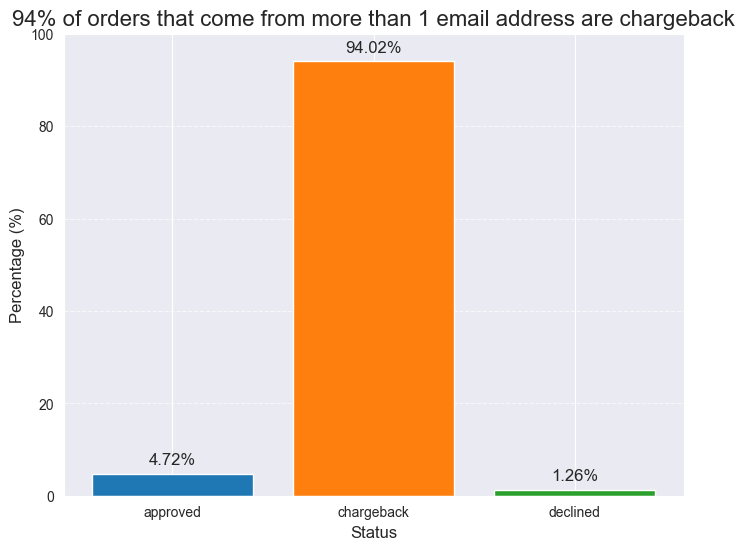

In [28]:

# Plot the histogram
plt.figure(figsize=(8, 6))
colors = plt.cm.tab10(range(len(status_distribution_multiple_email_addresses['status'])))
plt.bar(status_distribution_multiple_email_addresses['status'], status_distribution_multiple_email_addresses['percentage'], color=colors)
plt.title('94% of orders that come from more than 1 email address are chargeback', fontsize=16)
plt.xlabel('Status', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.ylim(0, 100)

# Annotate percentage values on bars
for i, v in enumerate(status_distribution_multiple_email_addresses['percentage']):
    plt.text(i, v + 2, f"{v:.2f}%", ha='center', fontsize=12)

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Save the plot as an image with a white background
# plt.savefig('status_distribution.png', dpi=300, bbox_inches='tight', facecolor='white')

plt.show()



I assume the model needs to work real-time, so that the cumulative number of email addresses per order is not available. In real time we don't know if there will be another email address connected to the same order_id. Therefore, I won't be able to use the cumulative number of email addresses per order_id in the model.

In [29]:
# for those order_id's that belong to more than 1 different email address, let's see what's the domain distribution

same_orderid_diff_email.groupby(['email_domain'], as_index=False)['order_id'].nunique().sort_values(by=['order_id'], ascending=False)

,email_domain,order_id
4,gmail,409
6,hotmail,210
17,personal_domain,122
23,yahoo,85
18,qq,27
16,outlook,21
2,aol,11
1,163,11
10,live,9
7,icloud,7


out of those order_id's that belong to more than 1 different email addresses, 42% come from gmail, 21% from hotmail, 13% from personal_domain. email domain is the same for the different email addresses in this case:

In [30]:
same_orderid_diff_email.groupby(['order_id'])['email_domain'].nunique().drop_duplicates()

order_id
63548611    1
Name: email_domain, dtype: int64

In [31]:
# the email address shared by 30 order_id's is NA@personal_domain.com
df.groupby(['email_anoni'], as_index=False)['order_id'].nunique().sort_values(by=['order_id'], ascending=False)

,email_anoni,order_id
71040,NA@personal_domain.com,30
78017,PQ@personal_domain.com,3
92419,U@personal_domain.com,3
172669,uP@personal_domain.com,2
83065,R6@personal_domain.com,2
...,...,...
63315,KcNYQY8ljrk@yahoo.com,1
63316,KcNm2bXhSWI3GAqW@gmail.com,1
63317,KcRH1Gw@aol.com,1
63318,KcRsz8WVW@hotmail.com,1


In [32]:
# let's see what's the status distribution for this email address
df[df['email_anoni']=='NA@personal_domain.com'].groupby(['status'])['order_id'].nunique()/df[df['email_anoni']=='NA@personal_domain.com'].groupby(['status'])['order_id'].nunique().sum()

status
approved      0.533333
chargeback    0.066667
declined      0.400000
Name: order_id, dtype: float64

it seems like for this address we have 53% of approved legitimate transactions and 40% of declines transactions, but only 6% chargeback.

In [33]:
# extract year, month (season), day of week (weekday/weekend)
# Convert the 'date' column to datetime
df['created_at'] = pd.to_datetime(df['created_at'])

# Extract year
df['year'] = df['created_at'].dt.year

# Extract month and map to season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['month'] = df['created_at'].dt.month
df['season'] = df['month'].apply(get_season)

# Extract day of the week and categorize as weekday/weekend
df['day_of_week'] = df['created_at'].dt.day_name()
df['is_weekend'] = df['created_at'].dt.dayofweek >= 5

In [34]:
df[df['email_anoni']=='NA@personal_domain.com'].is_weekend.value_counts()/df[df['email_anoni']=='NA@personal_domain.com'].is_weekend.value_counts().sum()

is_weekend
False    0.766667
True     0.233333
Name: count, dtype: float64

it seems like NA@personal_domain.com are mostly active during the week.

In [35]:
# how many order_id's do we have per weekeday/season
df.groupby(['day_of_week'])['order_id'].nunique().std()/df.groupby(['day_of_week'])['order_id'].nunique().mean()
#

0.12517328599439054

The coefficient of variation is 12.5% between number of order_id's per weekday, meaning that each day of the week gets more or less the same portion of order_id's: there is not a day with more order_id's than others.

In [36]:
# status distribution per weekday: in which day do we have the majority of chargebacks/approved/declined?

df.groupby(['day_of_week','status'])['order_id'].nunique()/df.groupby(['day_of_week'])['order_id'].nunique()

day_of_week  status    
Friday       approved      0.887393
             chargeback    0.018735
             declined      0.093871
Monday       approved      0.865141
             chargeback    0.019066
             declined      0.115792
Saturday     approved      0.877686
             chargeback    0.017986
             declined      0.104328
Sunday       approved      0.881817
             chargeback    0.018078
             declined      0.100105
Thursday     approved      0.883275
             chargeback    0.020838
             declined      0.095887
Tuesday      approved      0.865100
             chargeback    0.020498
             declined      0.114402
Wednesday    approved      0.862331
             chargeback    0.019645
             declined      0.118024
Name: order_id, dtype: float64

the distribution of status per weekday is quite constant: every day we have 86-88% of approved, around 2% chargeback and 10-11% of declined.

In [37]:
df.groupby(['status','day_of_week'])['order_id'].nunique()/df.groupby(['status'])['order_id'].nunique()

status      day_of_week
approved    Friday         0.165808
            Monday         0.142658
            Saturday       0.121260
            Sunday         0.122391
            Thursday       0.166582
            Tuesday        0.146213
            Wednesday      0.135088
chargeback  Friday         0.158326
            Monday         0.142193
            Saturday       0.112387
            Sunday         0.113481
            Thursday       0.177741
            Tuesday        0.156686
            Wednesday      0.139185
declined    Friday         0.145137
            Monday         0.157995
            Saturday       0.119272
            Sunday         0.114969
            Thursday       0.149640
            Tuesday        0.159996
            Wednesday      0.152992
Name: order_id, dtype: float64

the data suggests slight patterns in status behavior by day.

In [38]:
# let's see if season/month wise we have some pattern
df.groupby(['season','status'])['order_id'].nunique()/df.groupby(['season'])['order_id'].nunique()


season  status    
Fall    approved      0.912316
        chargeback    0.014098
        declined      0.073586
Spring  approved      0.859008
        chargeback    0.022104
        declined      0.118888
Summer  approved      0.877644
        chargeback    0.021363
        declined      0.100993
Winter  approved      0.858796
        chargeback    0.019704
        declined      0.121500
Name: order_id, dtype: float64

In [39]:
df.groupby(['month','status'])['order_id'].nunique()/df.groupby(['month'])['order_id'].nunique()

month  status    
1      approved      0.859768
       chargeback    0.023056
       declined      0.117176
2      approved      0.844240
       chargeback    0.019751
       declined      0.136009
3      approved      0.833152
       chargeback    0.021605
       declined      0.145243
4      approved      0.868872
       chargeback    0.025043
       declined      0.106085
5      approved      0.871434
       chargeback    0.019898
       declined      0.108669
6      approved      0.875224
       chargeback    0.022404
       declined      0.102371
7      approved      0.882480
       chargeback    0.018852
       declined      0.098668
8      approved      0.868045
       chargeback    0.033386
       declined      0.098569
9      approved      0.915058
       chargeback    0.023237
       declined      0.061704
10     approved      0.919359
       chargeback    0.017630
       declined      0.063011
11     approved      0.908257
       chargeback    0.009762
       declined      0

season and month show stability as well.

In [40]:
# for each email domain, let's see what's the most common status
order_id_count_per_status_email_domain = (
    df.groupby(['email_domain','status'], as_index=False)['order_id']
    .nunique()
    .sort_values(by=['email_domain', 'order_id'], ascending=[True, False])
)

# Get the top 3 email domains for each status
top_email_domains = (
    order_id_count_per_status_email_domain
    .groupby('email_domain')
    .head(2)
    .reset_index(drop=True)
)

In [41]:
top_email_domains[top_email_domains.status == 'chargeback']

,email_domain,status,order_id
59,rogers,chargeback,3
71,wanadoo,chargeback,10


there is no email domain where chargeback is the most frequent status, but for "rogers" and "wanadoo" chargeback is in the top 2.

In [42]:
df['billing_country_clean'] = np.where(df['billing_country_code'] == '? string:IT ?','IT',df['billing_country_code'])
df['shipping_country_clean'] = np.where(df['shipping_country_code'] == '? string:IT ?','IT',df['shipping_country_code'])

In [43]:
# for each billing country code, what's the most frequent status?

order_id_count_per_status_billing = (
    df.groupby(['billing_country_clean', 'status'], as_index=False)['order_id']
    .nunique()
    .sort_values(by=['billing_country_clean', 'order_id'], ascending=[True, False])
)

# Get the top 3 email domains for each status
top_billing_countries = (
    order_id_count_per_status_billing
    .groupby('billing_country_clean')
    .head(2)
    .reset_index(drop=True)
)

In [44]:
top_billing_countries[top_billing_countries.status == 'chargeback'].sort_values(by=['order_id'], ascending=[False])

,billing_country_clean,status,order_id
50,BR,chargeback,736
105,FI,chargeback,10
48,BO,chargeback,4
275,RE,chargeback,2
11,AM,chargeback,1
46,BN,chargeback,1
94,DZ,chargeback,1
121,GG,chargeback,1
132,GT,chargeback,1
142,HT,chargeback,1


The billing country where chargeback is in the top 2 most frequent statuses (with higher frequency) is Brazil.

In [45]:
# for each shipping country code, what's the most frequent status?

order_id_count_per_status_shipping = (
    df.groupby(['shipping_country_clean', 'status'], as_index=False)['order_id']
    .nunique()
    .sort_values(by=['shipping_country_clean', 'order_id'], ascending=[True, False])
)

# Get the top 3 email domains for each status
top_shipping_countries = (
    order_id_count_per_status_shipping
    .groupby('shipping_country_clean')
    .head(2)
    .reset_index(drop=True)
)

In [46]:
top_shipping_countries[top_shipping_countries.status == 'chargeback'].sort_values(by=['order_id'], ascending=[False])

,shipping_country_clean,status,order_id
43,BR,chargeback,724
89,FI,chargeback,9
41,BO,chargeback,4
169,LK,chargeback,3
39,BN,chargeback,2
9,AM,chargeback,1
79,DZ,chargeback,1
114,GT,chargeback,1
190,MM,chargeback,1
245,RE,chargeback,1


For Brazil (as shipping country) - chargeback is in the top 2 most common statuses.

In [47]:
num_order_per_shipping_country_code = df.groupby(['shipping_country_clean', 'billing_country_clean'], as_index=False)['order_id'].nunique()

In [48]:
# Pivot the table
pivot_table = num_order_per_shipping_country_code.pivot(
    index='shipping_country_clean',
    columns='billing_country_clean',
    values='order_id'
)

# Reset the index to make it more readable (optional)
pivot_table = pivot_table.reset_index()

pivot_table.fillna(0, inplace=True)
# Display the pivoted table
pd.DataFrame(pivot_table)


billing_country_clean,shipping_country_clean,AD,AE,AF,AG,AI,AL,AM,AN,AO,...,VN,VU,WS,XC,XK,XXX,YT,ZA,ZM,ZW
0,AD,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AE,0.0,607.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AI,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AL,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,XK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
190,YT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
191,ZA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,187.0,1.0,0.0
192,ZM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


I see there are some country codes that need to be fixed like 'Aaland Islands', 'Croatia (Local Name: Hrvatska)'.

In [49]:
# how many unique billing and shipping country code do we have?

df.shipping_country_clean.nunique(), df.billing_country_clean.nunique()

(194, 212)

we have a mismatch in the number of unique shipping and country codes. is it just because of missing values?

In [50]:
df['shipping_country_clean'].isna().sum(), df['billing_country_clean'].isna().sum()

(279, 777)

In [51]:
shipping_billing_mismatch = df[(df['shipping_country_clean'] != df['billing_country_clean']) & (~df['shipping_country_clean'].isna()) & (~df['billing_country_clean'].isna())]

In [52]:
shipping_billing_mismatch

,order_id,status,email_anoni,billing_country_code,shipping_country_code,shipping_method,created_at,total_spent,currency_code,gateway,...,V10_cookie,V11_cookie,email_domain,year,month,season,day_of_week,is_weekend,billing_country_clean,shipping_country_clean
10,199793329,approved,940p6miq@hotmail.com,VG,US,value_2280,2017-06-11,140.88,USD,value_167,...,5.748098,8.911227,hotmail,2017,6,Summer,Sunday,True,VG,US
27,166295715,approved,2mLxkFrQE6BLSW@gmail.com,GB,US,value_1876,2017-03-07,48.94,USD,value_247,...,0.511719,0.029039,gmail,2017,3,Spring,Tuesday,False,GB,US
45,142453058,approved,47IHjmE@personal_domain.com,CA,US,value_651,2016-12-26,321.00,USD,value_129,...,0.185185,29.855625,personal_domain,2016,12,Winter,Monday,False,CA,US
63,172524848,approved,vH5LwN2XP2n36S@gmail.com,ID,US,value_1794,2017-03-26,238.95,USD,value_65,...,5.395683,276.802951,gmail,2017,3,Spring,Sunday,True,ID,US
97,118124880,approved,K77ueOj0F@yahoo.com,DE,US,value_1692,2016-11-02,290.36,USD,value_119,...,4.732691,60.252895,yahoo,2016,11,Fall,Wednesday,False,DE,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189910,152849151,declined,hOQSUDZozBwOAc@gmail.com,US,ID,value_291,2017-01-25,465.00,USD,value_181,...,25.587896,0.010914,gmail,2017,1,Winter,Wednesday,False,US,ID
189912,140231219,declined,dI69Ps2ovbyfy7c@personal_domain.com,GB,US,value_142,2016-12-19,366.47,USD,value_245,...,5.968033,NaN,personal_domain,2016,12,Winter,Monday,False,GB,US
189917,107087903,declined,jcj2Mb9uysV@yahoo.com,MK,ID,value_1878,2016-09-26,72.24,USD,value_242,...,0.565875,0.047523,yahoo,2016,9,Fall,Monday,False,MK,ID
189962,193342413,chargeback,Z0JOnLgr@yahoo.com,EC,US,value_1692,2017-05-23,292.12,USD,value_119,...,0.779221,20.909163,yahoo,2017,5,Spring,Tuesday,False,EC,US


In [96]:
shipping_billing_mismatch.shape[0]/df.shape[0] #5%

0.05449473684210526

In [53]:
shipping_billing_mismatch.groupby(['status'])['order_id'].nunique()/shipping_billing_mismatch.groupby(['status'])['order_id'].nunique().sum()
# distribution is pretty much the same one

status
approved      0.843632
chargeback    0.014162
declined      0.142206
Name: order_id, dtype: float64

In [54]:
# shipping_billing_mismatch[shipping_billing_mismatch.status == 'approved'].groupby(['billing_country_code', 'shipping_country_code'], as_index=False)['order_id'].nunique()

# shipping_billing_mismatch[shipping_billing_mismatch.status == 'declined'].groupby(['billing_country_code', 'shipping_country_code'], as_index=False)['order_id'].nunique()

shipping_billing_mismatch[shipping_billing_mismatch.status == 'chargeback'].groupby(['billing_country_clean', 'shipping_country_clean'], as_index=False)['order_id'].nunique().sort_values(by=['order_id'], ascending=[False])

,billing_country_clean,shipping_country_clean,order_id
60,US,CA,9
17,CA,US,9
12,BR,US,8
61,US,CN,7
21,CO,US,5
...,...,...,...
44,JM,US,1
45,JP,US,1
16,CA,ID,1
15,CA,GB,1


- most frequent couple of billing-shipping country for declined transaction: CA-US
- most frequent couple of billing-shipping country for chargeback transaction: US-CA
- most frequent couple of billing-shipping country for chargeback transaction: CA-US

In [55]:
df[df.status=='chargeback']['order_id'].nunique()

3657

we have 3657 unique order_id's in df_chargeback.

24% of chargeback orders come from 2 different email addresses.

In [56]:
# what's the most common status for each shipping method?

shipping_method_per_status = (
    df.groupby(['shipping_method', 'status'], as_index=False)['order_id']
    .nunique()
    .sort_values(by=['shipping_method', 'order_id'], ascending=[True, False])
)

# Get the top 3 shipping methods for each status
top_shipping_methods = (
    shipping_method_per_status
    .groupby('shipping_method')
    .head(1)
    .reset_index(drop=True)
)

In [57]:
top_shipping_methods[top_shipping_methods.status=='chargeback'].sort_values(by=['order_id'], ascending=False)

,shipping_method,status,order_id
114,value_1100,chargeback,4
2025,value_691,chargeback,4
1262,value_2134,chargeback,3
2014,value_681,chargeback,3
1922,value_599,chargeback,3
92,value_1081,chargeback,2
54,value_1047,chargeback,2
1153,value_2036,chargeback,2
1783,value_473,chargeback,2
899,value_1808,chargeback,2


it seems like chargeback is the most common status for 36 shipping methods. the top 3 being: 1100,691,2134.

In [58]:
df.shipping_method.nunique()

2367

we have 2367 unique shipping methods.

In [59]:
# to analise total_spent, we first convert all transactions into USD - and we do the analysis on total_spent_USD

df.currency_code.drop_duplicates()

0         CAD
1         EUR
3         USD
14        GBP
20        MYR
46        JPY
71        TWD
80        AUD
82        BRL
107       PLN
207       KRW
291       SGD
344       NOK
353       CHF
360       SEK
380       IDR
414       DKK
594       RUB
815       MXN
899       HKD
1191      VND
1314      NZD
1725      ILS
1854      SAR
2005      CNY
2128      AED
2737      THB
2810      ARS
8754      TRY
9476      INR
16468     CZK
32047     HRK
104414    PHP
116876    ZAR
166981    KES
Name: currency_code, dtype: object

In [60]:
# Exchange rates to USD (as of recent knowledge)
exchange_rates = {
    'CAD': 0.75,  # Canadian Dollar
    'EUR': 1.1,   # Euro
    'USD': 1.0,   # US Dollar
    'GBP': 1.26,  # British Pound
    'MYR': 0.23,  # Malaysian Ringgit
    'JPY': 0.007, # Japanese Yen
    'TWD': 0.032, # Taiwan Dollar
    'AUD': 0.65,  # Australian Dollar
    'BRL': 0.2,   # Brazilian Real
    'PLN': 0.26,  # Polish Zloty
    'KRW': 0.00078, # South Korean Won
    'SGD': 0.74,  # Singapore Dollar
    'NOK': 0.092, # Norwegian Krone
    'CHF': 1.1,   # Swiss Franc
    'SEK': 0.091, # Swedish Krona
    'IDR': 0.000065, # Indonesian Rupiah
    'DKK': 0.16,  # Danish Krone
    'RUB': 0.013, # Russian Ruble
    'MXN': 0.056, # Mexican Peso
    'HKD': 0.13,  # Hong Kong Dollar
    'VND': 0.000042, # Vietnamese Dong
    'NZD': 0.61,  # New Zealand Dollar
    'ILS': 0.26,  # Israeli Shekel
    'SAR': 0.27,  # Saudi Riyal
    'CNY': 0.14,  # Chinese Yuan
    'AED': 0.27,  # UAE Dirham
    'THB': 0.028, # Thai Baht
    'ARS': 0.0027, # Argentine Peso
    'TRY': 0.036, # Turkish Lira
    'INR': 0.012, # Indian Rupee
    'CZK': 0.044, # Czech Koruna
    'HRK': 0.14,  # Croatian Kuna
    'PHP': 0.018, # Philippine Peso
    'ZAR': 0.052, # South African Rand
    'KES': 0.0068 # Kenyan Shilling
}

# Function to convert total_spent to USD
def convert_to_usd(amount, currency):
    rate = exchange_rates.get(currency, 1)  # Default to 1 if currency not found
    return amount * rate

# Apply the conversion
df['total_spent_USD'] = df.apply(
    lambda row: convert_to_usd(row['total_spent'], row['currency_code']),
    axis=1
)


In [61]:
# let's see whats the avg total spent per shipping method, status, email domain.
df.groupby(['shipping_method'], as_index=False)['total_spent_USD'].mean().sort_values(by=['total_spent_USD'], ascending=[False]).head(3)

,shipping_method,total_spent_USD
107,value_1095,10309.26
987,value_1888,9204.20
1723,value_419,9051.06


the top 3 shipping methods with highest avg spent are 1095, 1888, 419.


In [62]:
# for each shipping method, what's the most expensive status on average?

most_expensive_status_per_shipping_method = df.groupby(['shipping_method', 'status'], as_index=False)['total_spent_USD'].mean().sort_values(by=['shipping_method','total_spent_USD'], ascending=[True, False]).groupby(['shipping_method']).head(1)

most_expensive_status_per_shipping_method[most_expensive_status_per_shipping_method.status == 'chargeback'].sort_values(by=['total_spent_USD'], ascending=False)


,shipping_method,status,total_spent_USD
2460,value_417,chargeback,6617.270000
3248,value_885,chargeback,5155.268722
1837,value_2173,chargeback,4451.180000
2649,value_534,chargeback,2405.191976
2174,value_244,chargeback,2088.281866
...,...,...,...
1390,value_1877,chargeback,51.720000
2779,value_603,chargeback,40.280000
926,value_1585,chargeback,30.910000
1387,value_1876,chargeback,26.135294


for chargebacks, the shipping method with highest average spending in USD is 417.

In [63]:
most_expensive_status_per_shipping_method_by_currency = df.groupby(['shipping_method', 'currency_code', 'status'], as_index=False)['total_spent_USD'].mean().sort_values(by=['shipping_method','currency_code','total_spent_USD'], ascending=[True, True, False]).groupby(['shipping_method','currency_code']).head(1)

most_expensive_status_per_shipping_method_by_currency[most_expensive_status_per_shipping_method_by_currency.status == 'chargeback'].sort_values(by=['total_spent_USD'], ascending=False)

,shipping_method,currency_code,status,total_spent_USD
2963,value_417,USD,chargeback,6617.270000
3900,value_885,EUR,chargeback,5155.268722
2246,value_2173,USD,chargeback,4451.180000
2622,value_244,USD,chargeback,2742.366239
638,value_1301,USD,chargeback,2580.117692
...,...,...,...,...
603,value_1301,ARS,chargeback,2.149807
1819,value_1938,JPY,chargeback,1.231529
1822,value_1938,KRW,chargeback,0.110329
1816,value_1938,IDR,chargeback,0.010712


In [64]:
df.groupby(['status'], as_index=False)['total_spent_USD'].mean().sort_values(by=['total_spent_USD'], ascending=[False]).head(3)

,status,total_spent_USD
2,declined,402.599565
1,chargeback,372.526766
0,approved,224.552243


we can see that chargeback and declined orders have higher average total spent than approved.

what's their position w.r.t. the rest of the values in the distribution?

In [65]:
df['total_spent_USD'].describe()

count    190000.000000
mean        246.844676
std         516.659394
min           0.000000
25%          61.530000
50%         126.140000
75%         246.741664
max       63520.605936
Name: total_spent_USD, dtype: float64

compared to the rest of the distribution, it seems like chargeback and declined orders are both in the upper quartile of the distribution. we can see that the average of chargeback and declined are in the top 25% of the total spent distribution as 372 and 402 are higher than 246.

In [66]:
df.groupby(['status'])['total_spent_USD'].describe()

,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
approved,165441.0,224.552243,482.221918,0.0,57.990000,117.500780,219.2900,63520.605936
chargeback,4559.0,372.526766,748.631717,0.0,95.584660,189.743861,381.0300,14971.660552
declined,20000.0,402.599565,672.798950,0.0,110.414086,218.075079,474.0125,36008.500000


let's plot the distribution of total_spent and total_spent by status

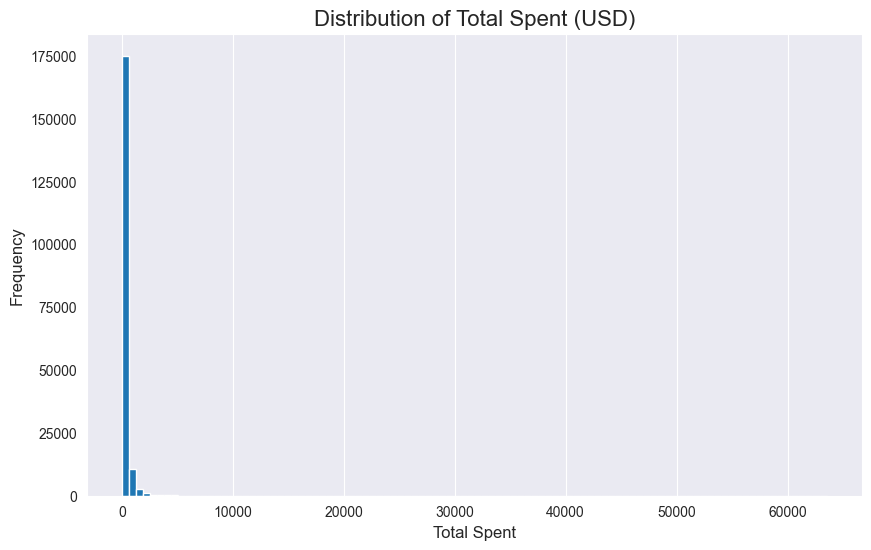

In [67]:

# Plot the overall distribution of 'total_spent'
plt.figure(figsize=(10, 6))
plt.hist(df['total_spent_USD'], bins=100)
plt.title('Distribution of Total Spent (USD)', fontsize=16)
plt.xlabel('Total Spent', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y')
plt.show()

the distribution of total spent is very skewed. if we take log(x+1) transformation - it becomes normal, which is easier to look at. We need to add 1 because we have a lot of zeros.

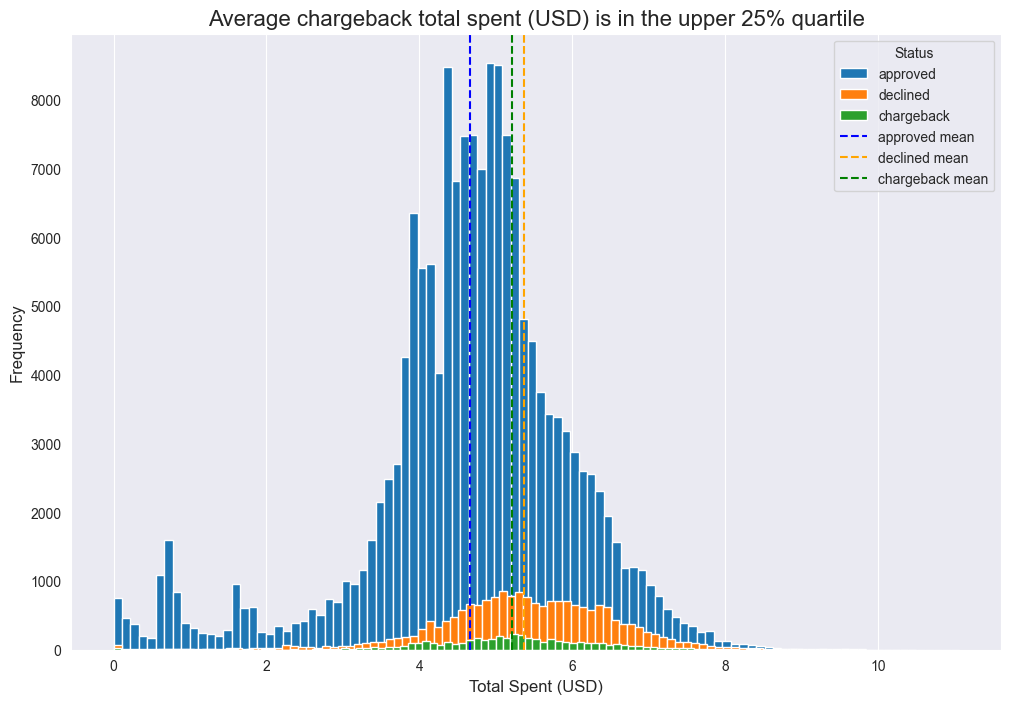

In [68]:
approved_mean = np.log(df[df.status == 'approved']['total_spent_USD'] + 1).mean()
declined_mean = np.log(df[df.status == 'declined']['total_spent_USD'] + 1).mean()
chargeback_mean = np.log(df[df.status == 'chargeback']['total_spent_USD'] + 1).mean()


# Plot the distribution of 'total_spent' by 'status'
plt.figure(figsize=(12, 8))
plt.hist(np.log(df[df.status == 'approved']['total_spent_USD']+1), bins=100, label='approved')
plt.hist(np.log(df[df.status == 'declined']['total_spent_USD']+1), bins=100, label='declined')
plt.hist(np.log(df[df.status == 'chargeback']['total_spent_USD']+1), bins=100, label='chargeback')
plt.axvline(approved_mean, color='blue', linestyle='dashed', linewidth=1.5, label='approved mean')
plt.axvline(declined_mean, color='orange', linestyle='dashed', linewidth=1.5, label='declined mean')
plt.axvline(chargeback_mean, color='green', linestyle='dashed', linewidth=1.5, label='chargeback mean')
plt.title('Average chargeback total spent (USD) is in the upper 25% quartile', fontsize=16)
plt.xlabel('Total Spent (USD)', fontsize=12) # here it's log(x+1) but for the sales report i will leave it like this for simplicity
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Status')
plt.grid(axis='y')
# Save the plot as an image with a white background
# plt.savefig('log_total_spent_distribution.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

we can see that the average total spent for chargeback and declined is in the upper quartile of the spent distribution.

there are 3 spikes on the left tail of the distribution. let's look at them.

In [69]:
# Define the threshold for the left tail
left_tail_threshold = 2

# Filter the data for approved status and log(total_spent_USD + 1) in the left tail
left_tail_approved = df[(df['status'] == 'approved') & (np.log(df['total_spent_USD'] + 1) < left_tail_threshold)]

# Define the bins used in the histogram
bins = np.linspace(0, left_tail_threshold, 100)

# Calculate log(total_spent_USD + 1) for left_tail_approved
log_total_spent = np.log(left_tail_approved['total_spent_USD'] + 1)

# Determine the bin each observation belongs to
bin_indices = np.digitize(log_total_spent, bins, right=True)

# Create a DataFrame for bin frequencies
bin_frequencies = (
    pd.DataFrame({'bin': bin_indices})
    .value_counts()
    .reset_index(name='frequency')
    .sort_values(by='frequency', ascending=False)
)

# Find the top 5 bins with the highest frequency
top_5_bins = bin_frequencies.head(5)

# Map bin indices back to bin ranges
bin_edges = pd.IntervalIndex.from_breaks(bins)
top_5_bins['bin_range'] = top_5_bins['bin'].map(lambda x: bin_edges[x - 1] if x <= len(bin_edges) else np.nan)
top_5_bins

/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_51231/1525175173.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_bins['bin_range'] = top_5_bins['bin'].map(lambda x: bin_edges[x - 1] if x <= len(bin_edges) else np.nan)


,bin,frequency,bin_range
0,35,510,"(0.686868686868687, 0.7070707070707072]"
1,33,395,"(0.6464646464646465, 0.6666666666666667]"
2,37,340,"(0.7272727272727273, 0.7474747474747475]"
3,1,335,"(0.0, 0.020202020202020204]"
4,31,300,"(0.6060606060606061, 0.6262626262626263]"


In [70]:
# Define the bins used in the histogram
bins = np.linspace(0, left_tail_threshold, 100)

# Calculate log(total_spent_USD + 1) for left_tail_approved
log_total_spent = np.log(left_tail_approved['total_spent_USD'] + 1)

# Map each observation to its respective bin
left_tail_approved['bin'] = np.digitize(log_total_spent, bins, right=True)

# Analyze data within each bin
# Example: Group by bin and analyze shipping and billing countries
bin_analysis = left_tail_approved.groupby('bin').agg({
    'total_spent_USD': [ 'min', 'mean', 'max', 'count'],
    'shipping_country_clean': lambda x: x.value_counts().head(3).to_dict(),
    'billing_country_clean': lambda x: x.value_counts().head(3).to_dict(),
    'email_domain': lambda x: x.value_counts().head(3).to_dict()
}).reset_index()

# Map bin indices back to bin ranges
bin_edges = pd.IntervalIndex.from_breaks(bins)
bin_analysis['bin_range'] = bin_analysis['bin'].map(lambda x: bin_edges[x - 1] if x <= len(bin_edges) else np.nan)

/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_51231/425213980.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_tail_approved['bin'] = np.digitize(log_total_spent, bins, right=True)


In [71]:
# Flatten the MultiIndex columns in bin_analysis
bin_analysis.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in bin_analysis.columns]

# Filter for specific bins and merge with top_4_bins on 'bin'
filtered_bin_analysis = bin_analysis[bin_analysis['bin'].isin(list(top_5_bins.bin))].reset_index(drop=True)
result = filtered_bin_analysis.merge(
    top_5_bins[['bin', 'frequency']],
    on='bin',
    how='left'
)

result.sort_values(by=['frequency'], ascending=[False], inplace=True)
result

,bin,total_spent_USD_min,total_spent_USD_mean,total_spent_USD_max,total_spent_USD_count,shipping_country_clean_<lambda>,billing_country_clean_<lambda>,email_domain_<lambda>,bin_range,frequency
3,35,0.987535,1.010235,1.028001,510,"{'JP': 488, 'HK': 6, 'US': 3}","{'JP': 486, 'HK': 6, 'US': 3}","{'gmail': 126, 'ezweb': 90, 'docomo': 77}","(0.686868686868687, 0.7070707070707072]",510
2,33,0.908800,0.926082,0.947533,395,"{'JP': 376, 'TW': 13, 'KR': 2}","{'JP': 376, 'TW': 13, 'KR': 2}","{'gmail': 113, 'docomo': 61, 'ezweb': 51}","(0.6464646464646465, 0.6666666666666667]",395
4,37,1.069605,1.092238,1.111640,340,"{'JP': 325, 'TH': 7, 'TW': 3}","{'JP': 325, 'TH': 7, 'TW': 3}","{'gmail': 90, 'docomo': 52, 'ezweb': 52}","(0.7272727272727273, 0.7474747474747475]",340
0,1,0.000884,0.008738,0.020000,335,"{'ID': 197, 'VN': 100, 'KR': 26}","{'ID': 197, 'VN': 101, 'KR': 26}","{'gmail': 186, 'yahoo': 81, 'personal_domain':...","(0.0, 0.020202020202020204]",335
1,31,0.833309,0.847104,0.869739,300,"{'JP': 290, 'TW': 2, 'TH': 1}","{'JP': 289, 'TW': 2, 'TH': 1}","{'gmail': 84, 'yahoo': 44, 'ezweb': 34}","(0.6060606060606061, 0.6262626262626263]",300


The spikes in the left tail are given by approved legitimate transactions in Asian countries like Japan (JP), Taiwan (TW), Thailand (TH), South Korea (KR), Hong Kong (HK), Indonesia (ID).

In [72]:
# Find the unique elements in 'billing_country_clean' and 'shipping_country_clean'

# Replace full names with ISO codes
df['billing_country_clean'] = df['billing_country_clean'].replace({
    'Aaland Islands': 'ALA',  # Aaland Islands to ALA (ISO code)
    'Croatia (Local Name: Hrvatska)': 'HR'  # Croatia (Hrvatska) to HR (ISO code)
})

df['shipping_country_clean'] = df['shipping_country_clean'].replace({
    'Aaland Islands': 'ALA',  # Aaland Islands to ALA (ISO code)
    'Croatia (Local Name: Hrvatska)': 'HR'  # Croatia (Hrvatska) to HR (ISO code)
})

# Define the mapping of countries to regions
country_to_region = {
    # North America
    'US': 'North America', 'CA': 'North America', 'MX': 'North America', 'GU': 'North America', 'PR': 'North America',

    # South America
    'AR': 'South America', 'BR': 'South America', 'CL': 'South America', 'CO': 'South America', 'EC': 'South America',
    'GY': 'South America', 'PE': 'South America', 'PY': 'South America', 'SR': 'South America', 'UY': 'South America',
    'VE': 'South America',

    # Europe
    'AD': 'Europe', 'AL': 'Europe', 'AM': 'Europe', 'AT': 'Europe', 'AX': 'Europe', 'BA': 'Europe', 'BE': 'Europe',
    'BG': 'Europe', 'BY': 'Europe', 'CH': 'Europe', 'CY': 'Europe', 'CZ': 'Europe', 'DE': 'Europe', 'DK': 'Europe',
    'EE': 'Europe', 'ES': 'Europe', 'FI': 'Europe', 'FR': 'Europe', 'FX': 'Europe', 'GB': 'Europe', 'GG': 'Europe',
    'GI': 'Europe', 'GR': 'Europe', 'HR': 'Europe', 'HU': 'Europe', 'IE': 'Europe', 'IM': 'Europe', 'IS': 'Europe',
    'IT': 'Europe', 'JE': 'Europe', 'LI': 'Europe', 'LT': 'Europe', 'LU': 'Europe', 'LV': 'Europe', 'MC': 'Europe',
    'MD': 'Europe', 'ME': 'Europe', 'MK': 'Europe', 'MT': 'Europe', 'NL': 'Europe', 'NO': 'Europe', 'PL': 'Europe',
    'PT': 'Europe', 'RO': 'Europe', 'RS': 'Europe', 'RU': 'Europe', 'SE': 'Europe', 'SI': 'Europe', 'SK': 'Europe',
    'SM': 'Europe', 'UA': 'Europe', 'VA': 'Europe',

    # Africa
    'AO': 'Africa', 'BF': 'Africa', 'BI': 'Africa', 'BJ': 'Africa', 'BW': 'Africa', 'CD': 'Africa', 'CF': 'Africa',
    'CG': 'Africa', 'CI': 'Africa', 'CM': 'Africa', 'CV': 'Africa', 'DJ': 'Africa', 'DZ': 'Africa', 'EG': 'Africa',
    'EH': 'Africa', 'ER': 'Africa', 'ET': 'Africa', 'GA': 'Africa', 'GH': 'Africa', 'GM': 'Africa', 'GN': 'Africa',
    'GQ': 'Africa', 'GW': 'Africa', 'KE': 'Africa', 'KM': 'Africa', 'LS': 'Africa', 'LR': 'Africa', 'LY': 'Africa',
    'MA': 'Africa', 'MG': 'Africa', 'ML': 'Africa', 'MR': 'Africa', 'MU': 'Africa', 'MW': 'Africa', 'MZ': 'Africa',
    'NA': 'Africa', 'NE': 'Africa', 'NG': 'Africa', 'RW': 'Africa', 'SC': 'Africa', 'SD': 'Africa', 'SH': 'Africa',
    'SL': 'Africa', 'SN': 'Africa', 'SO': 'Africa', 'ST': 'Africa', 'SZ': 'Africa', 'TD': 'Africa', 'TG': 'Africa',
    'TN': 'Africa', 'TZ': 'Africa', 'UG': 'Africa', 'YT': 'Africa', 'ZA': 'Africa', 'ZM': 'Africa', 'ZW': 'Africa',

    # Middle East
    'AE': 'Middle East', 'BH': 'Middle East', 'IL': 'Middle East', 'IQ': 'Middle East', 'IR': 'Middle East',
    'JO': 'Middle East', 'KW': 'Middle East', 'LB': 'Middle East', 'OM': 'Middle East', 'PS': 'Middle East',
    'QA': 'Middle East', 'SA': 'Middle East', 'SY': 'Middle East', 'YE': 'Middle East',

    # Asia
    'CN': 'Asia', 'HK': 'Asia', 'JP': 'Asia', 'KR': 'Asia', 'MO': 'Asia', 'TW': 'Asia',
    'BN': 'Asia', 'KH': 'Asia', 'ID': 'Asia', 'LA': 'Asia', 'MY': 'Asia',
    'MM': 'Asia', 'PH': 'Asia', 'SG': 'Asia', 'TH': 'Asia', 'VN': 'Asia',
    'AF': 'Asia', 'BD': 'Asia', 'BT': 'Asia', 'IN': 'Asia', 'LK': 'Asia', 'MV': 'Asia',
    'NP': 'Asia', 'PK': 'Asia',

    # Oceania
    'AU': 'Oceania', 'FJ': 'Oceania', 'NC': 'Oceania', 'NZ': 'Oceania', 'PG': 'Oceania', 'VU': 'Oceania',

    # Uncategorized / Default
    'nan': 'Uncategorized', 'XXX': 'Uncategorized', 'UN': 'Uncategorized'
}

# Map the regions
df['billing_region'] = df['billing_country_clean'].map(country_to_region)
df['shipping_region'] = df['shipping_country_clean'].map(country_to_region)


In [73]:
billing_region_common_status = df.groupby(['billing_region','status'], as_index=False)['order_id'].nunique().sort_values(by=['billing_region','order_id'], ascending=[True, False]).groupby(['billing_region']).head(2)

billing_region_common_status[billing_region_common_status.status == 'chargeback']

,billing_region,status,order_id
19,South America,chargeback,784


In [74]:
shipping_region_common_status = df.groupby(['shipping_region', 'status'], as_index=False)['order_id'].nunique().sort_values(
    by=['shipping_region', 'order_id'], ascending=[True, False]).groupby(['shipping_region']).head(2)

shipping_region_common_status[shipping_region_common_status.status == 'chargeback']

,shipping_region,status,order_id
19,South America,chargeback,762


south american is the region where chargeback is in the top 2 most frquent statuses - for both shipping and billing.

In [75]:
# check shipping methods per shipping continent

df.groupby(['shipping_region', 'shipping_method'], as_index=False)['order_id'].nunique().sort_values(by=['shipping_region','order_id'],ascending=[True, False]).groupby(['shipping_region']).head(1)

,shipping_region,shipping_method,order_id
48,Africa,value_1938,54
273,Asia,value_1938,9073
822,Europe,value_1609,5745
1492,Middle East,value_1938,276
1993,North America,value_1645,18222
3289,Oceania,value_291,2033
3419,South America,value_1301,1239


it's interesting to see that for africa, asia and middle east shipping method 1938 is the most common.

In [76]:
# for each email domain, what's the most expensive status?
avg_total_spent_per_domain = (
    df.groupby(['email_domain','status'], as_index=False)['total_spent_USD']
    .mean()
)

# Optional: Do the same for all statuses
top_domains_by_status = (
    avg_total_spent_per_domain
    .sort_values(by=['email_domain','total_spent_USD'], ascending=[True, False])
    .groupby('email_domain')
    .head(1)  # Get the domain with the highest avg total_spent for each status
    .reset_index(drop=True)
)

top_domains_by_status[top_domains_by_status.status == 'chargeback'].sort_values(by=['total_spent_USD'], ascending=[False])


,email_domain,status,total_spent_USD
13,hanmail,chargeback,1333.710000
32,sina,chargeback,830.142004
0,126,chargeback,746.469765
22,me,chargeback,743.951527
2,aol,chargeback,727.496041
28,qq,chargeback,652.285067
5,btinternet,chargeback,633.194100
31,shaw,chargeback,581.320000
1,163,chargeback,561.284021
25,orange,chargeback,544.030399


Hanmail is the email domain where chargeback is the most expensive status.

In [77]:
# Filter for 'chargeback' status and sort by average 'total_spent' in descending order
chargeback_top_domain = (
    top_domains_by_status[top_domains_by_status.status == 'chargeback'].sort_values(by=['total_spent_USD'], ascending=[False])
    .head(5)  # Get the domain with the highest avg total_spent for chargeback
)

In [78]:
chargeback_top_domain

,email_domain,status,total_spent_USD
13,hanmail,chargeback,1333.710000
32,sina,chargeback,830.142004
0,126,chargeback,746.469765
22,me,chargeback,743.951527
2,aol,chargeback,727.496041


In [79]:
chargeback_top_domain['percentage'] = (chargeback_top_domain['total_spent_USD'] / chargeback_top_domain['total_spent_USD'].sum())*100

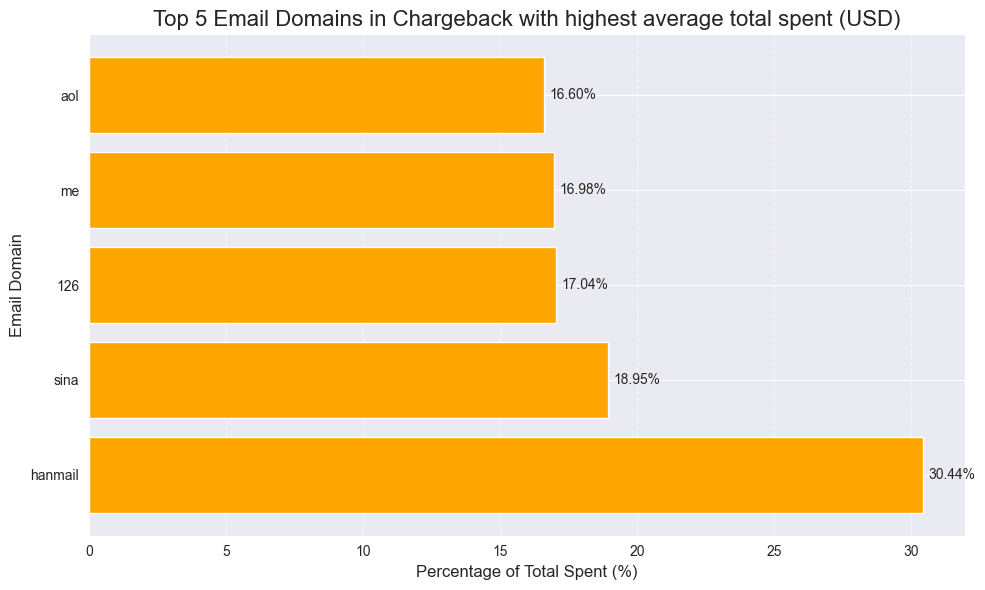

In [80]:
# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(chargeback_top_domain['email_domain'], chargeback_top_domain['percentage'], color='orange')

# Add labels and title
plt.title('Top 5 Email Domains in Chargeback with highest average total spent (USD)', fontsize=16)
plt.xlabel('Percentage of Total Spent (%)', fontsize=12)
plt.ylabel('Email Domain', fontsize=12)

# Annotate the bars with percentage values
for i, (percentage, domain) in enumerate(zip(chargeback_top_domain['percentage'], chargeback_top_domain['email_domain'])):
    plt.text(percentage + 0.2, i, f"{percentage:.2f}%", va='center', fontsize=10)

# Adjust the layout and show the plot
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.savefig('email_domain_chargeback_spent.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


For chargeback transactions, the domains with highest average total spent are hanmail and sina. So Riskified as a company should be careful with these domains as they might be the most expensive for the company.

In [81]:
df['currency_code'].value_counts(dropna=False)
# we have 35 different currencies

currency_code
USD    124681
EUR     27356
GBP     11874
CAD      6493
JPY      5633
BRL      3393
TWD      2481
AUD      1343
DKK       932
HKD       759
KRW       687
NOK       566
SEK       548
CHF       535
SGD       509
MYR       447
THB       313
PLN       249
IDR       241
MXN       174
RUB       125
NZD       123
VND       110
AED       101
ARS        86
CNY        85
SAR        80
ILS        21
CZK        18
PHP        15
INR         8
TRY         6
ZAR         5
HRK         2
KES         1
Name: count, dtype: int64

In [82]:
# what's the most common status per currency?

currency_per_status = (
    df.groupby(['currency_code', 'status'], as_index=False,  dropna=False)['order_id']
    .nunique()
    .sort_values(by=['currency_code', 'order_id'], ascending=[True, False])
)

# Get the top 3 shipping methods for each status
top_currencies = (
    currency_per_status
    .groupby('currency_code')
    .head(2)
    .reset_index(drop=True)
)

top_currencies[top_currencies.status == 'chargeback'].sort_values(by='order_id', ascending=[False])

,currency_code,status,order_id
7,BRL,chargeback,674
39,MYR,chargeback,18
28,ILS,chargeback,6
1,AED,chargeback,3
51,SAR,chargeback,1
66,ZAR,chargeback,1


Chargeback is in the top 2 most common status for Brazilian Real (BRL).

In [83]:
# for which currency chargeback is the most expensive status?

currency_expensive_status = df.groupby(['currency_code', 'status'], as_index=False)['total_spent_USD'].mean().sort_values(by=['currency_code','total_spent_USD'], ascending=[True, False]).groupby(['currency_code']).head(1)

currency_expensive_status[currency_expensive_status.status == 'chargeback'].sort_values(by=['total_spent_USD'], ascending=[False])

,currency_code,status,total_spent_USD
30,GBP,chargeback,804.828404
13,CAD,chargeback,439.068024
86,USD,chargeback,397.433331
33,HKD,chargeback,170.345151
71,SAR,chargeback,150.099096
58,NOK,chargeback,40.388340
55,MYR,chargeback,38.124994
52,MXN,chargeback,15.768329
92,ZAR,chargeback,8.056848
64,PHP,chargeback,4.980585


The currency where chargebacks are the most expensive transactions on average is the british pound.

In [84]:
# count number of billing-shipping mismatch per status (mismatch is not a factor in chargeback)
df['billing_shipping_mismatch'] = np.where(df['billing_country_clean']!=df['shipping_country_clean'], 1, 0)
df.groupby(['status'])['billing_shipping_mismatch'].sum()/df.groupby(['status'])['billing_shipping_mismatch'].sum().sum()

status
approved      0.838468
chargeback    0.017830
declined      0.143702
Name: billing_shipping_mismatch, dtype: float64

In [85]:
# it's not a discriminative feature so we can drop it

df.drop(columns=['billing_shipping_mismatch'], inplace=True)

In [86]:
# for which gateway - chargeback is the most common status?
gateway_common_status = df.groupby(['gateway', 'status'], as_index=False)['order_id'].nunique().sort_values(by=['gateway','order_id'], ascending=[True, False]).groupby('gateway').head(1)

gateway_common_status[gateway_common_status.status == 'chargeback'].sort_values(by=['order_id'], ascending=False)

,gateway,status,order_id
335,value_29,chargeback,180
409,value_64,chargeback,6
340,value_32,chargeback,1


gateway 29, 64, 32 are the ones where chargeback is the top 1 more frequent status.

In [87]:
df.head()

,order_id,status,email_anoni,billing_country_code,shipping_country_code,shipping_method,created_at,total_spent,currency_code,gateway,...,year,month,season,day_of_week,is_weekend,billing_country_clean,shipping_country_clean,total_spent_USD,billing_region,shipping_region
0,176079577,approved,shRbsUOPGM@qq.com,CA,CA,value_1620,2017-04-06,758.471274,CAD,value_100,...,2017,4,Spring,Thursday,False,CA,CA,568.853455,North America,North America
1,201560820,approved,hEjasTK8Vpq6sR@gmail.com,IT,IT,value_1639,2017-06-16,48.319175,EUR,value_169,...,2017,6,Summer,Friday,False,IT,IT,53.151092,Europe,Europe
2,164072492,approved,KOWpxkDYDF@gmail.com,BE,BE,value_244,2017-03-01,1123.094534,EUR,value_151,...,2017,3,Spring,Wednesday,False,BE,BE,1235.403987,Europe,Europe
3,174595495,approved,hKOMNS3@me.com,CH,CH,value_1879,2017-04-02,12.530000,USD,value_247,...,2017,4,Spring,Sunday,True,CH,CH,12.530000,Europe,Europe
4,213517818,approved,PrP6SYm5Q5nMs1tj@hotmail.com,HK,HK,value_291,2017-07-11,480.000000,USD,value_148,...,2017,7,Summer,Tuesday,False,HK,HK,480.000000,Asia,Asia


So far we looked at marginal or join distribution between 2 features. Let's look now at profiles. For this purpose I start by looking at the join distribution of multiple categorical features.

In [88]:
# most common status per profile
grouped_data = df.groupby(['gateway', 'currency_code', 'billing_country_clean', 'shipping_country_clean', 'shipping_method', 'V1_link',
                'V6_avs_result', 'V7_bill_ship_name_match','email_domain','season','is_weekend', 'status'], as_index=False)['order_id'].nunique().sort_values(by=['gateway', 'currency_code', 'billing_country_clean', 'shipping_country_clean', 'shipping_method', 'V1_link',
                'V6_avs_result', 'V7_bill_ship_name_match','email_domain','season','is_weekend','order_id'], ascending=[True,True,True,True,True,True,True,True,True,True,True,False]).head(1)

grouped_data[grouped_data.status == 'chargeback']



,gateway,currency_code,billing_country_clean,shipping_country_clean,shipping_method,V1_link,V6_avs_result,V7_bill_ship_name_match,email_domain,season,is_weekend,status,order_id
0,value_1,USD,BR,US,value_1509,False,Missing,NO_MATCH,personal_domain,Spring,False,chargeback,1


Since we got only one profile where chargeback is the only status: value_1,USD,BR,US,value_1509,False,Missing,NO_MATCH,personal_domain,Spring,False,chargeback, we'll look at profiles with less features, which were found out to be relevant in the analyses above.


In [89]:
# profiles per chargeback is the number 1 most common status
grouped_data = df.groupby(['gateway', 'currency_code', 'billing_country_clean', 'shipping_method',
                'V6_avs_result', 'V7_bill_ship_name_match', 'status'], as_index=False)['order_id'].nunique().sort_values(by=['gateway', 'currency_code', 'billing_country_clean', 'shipping_method',
                'V6_avs_result', 'V7_bill_ship_name_match','order_id'], ascending=[True,True,True,True,True,True,False]).groupby(['gateway', 'currency_code', 'billing_country_clean', 'shipping_method',
                'V6_avs_result', 'V7_bill_ship_name_match']).head(1)

grouped_data[grouped_data.status == 'chargeback'].sort_values(by=['order_id'], ascending=False)

,gateway,currency_code,billing_country_clean,shipping_method,V6_avs_result,V7_bill_ship_name_match,status,order_id
18056,value_29,EUR,DE,value_2132,Missing,FL,chargeback,123
18052,value_29,EUR,DE,value_1938,Missing,FL,chargeback,56
16845,value_242,USD,MX,value_1878,Unsupported,FL,chargeback,21
11867,value_196,USD,MX,value_74,Missing,FL,chargeback,13
16485,value_22,EUR,DE,value_515,Unsupported,FL,chargeback,11
...,...,...,...,...,...,...,...,...
13988,value_201,USD,IE,value_1692,Unsupported,FL,chargeback,1
3403,value_162,USD,ZA,value_121,Unsupported,FL,chargeback,1
3396,value_162,USD,US,value_505,Missing,FL,chargeback,1
14088,value_201,USD,SE,value_1692,Unsupported,NO_MATCH,chargeback,1


this aggregation focuses on risky combinations where the likelihood of chargebacks is the highest. The top 5:
- value_29, EUR, DE, value_2132, Missing, FL
- value_29, EUR, DE, value_1938, Missing, FL
- value_242, USD, MX, value_1878, Unsupported, FL
- value_196, USD, MX, value_74, Missing, FL
- value_22, EUR, DE, value_515, Unsupported, FL

In these profiles, we have transaction where the billing country is Mexico or Germany, where gateway 29 is the most common. The transactions are in EUR/USD, and the level of matching between billing address in transaction and CC is either missing or unsupported, even if both name and surname match.


/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_51231/2342432079.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


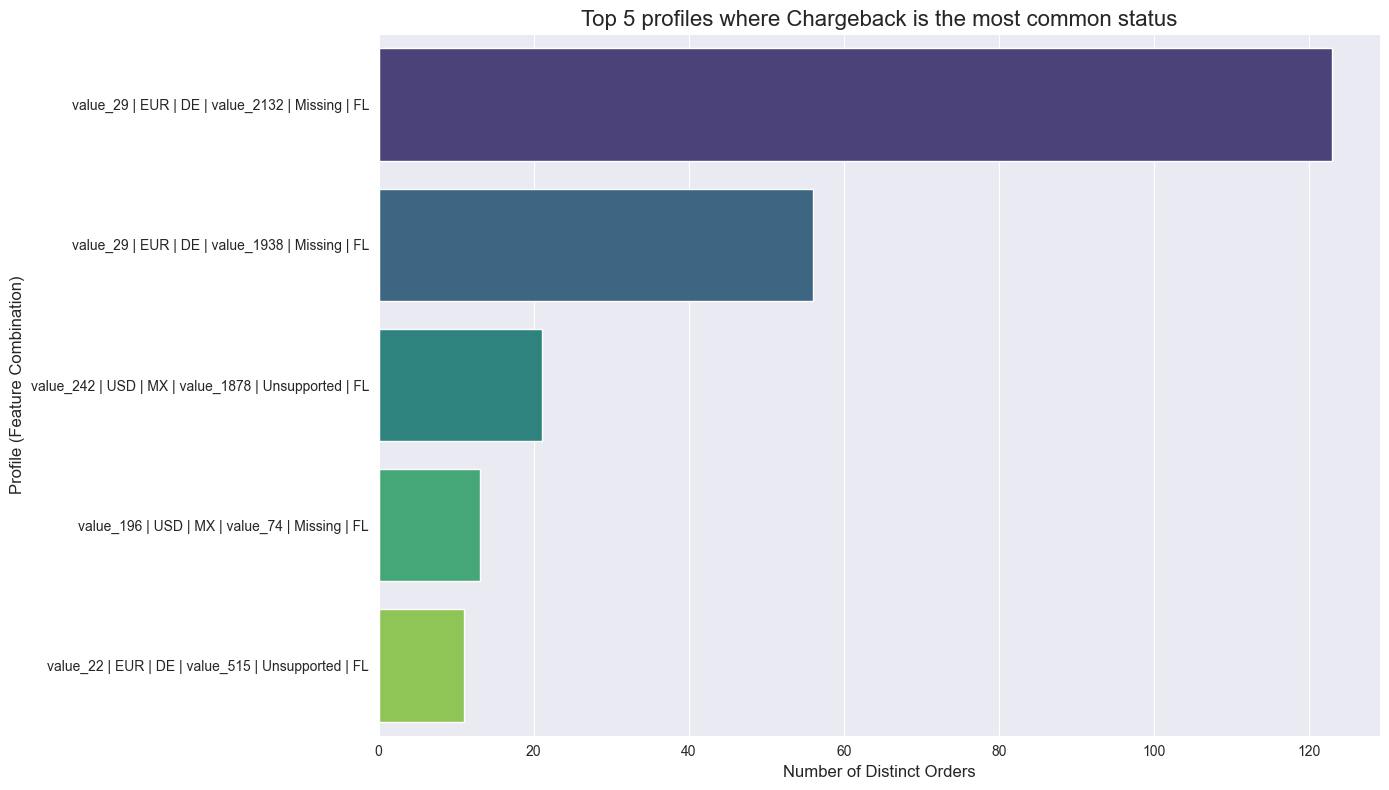

In [90]:
# Assuming 'most_common_status' is the DataFrame with the chargeback profiles
chargeback_profiles = grouped_data[grouped_data.status == 'chargeback'].sort_values(by=['order_id'], ascending=False).head(5)

# Create a new column to represent the profile as a single label
chargeback_profiles['profile'] = (
    chargeback_profiles['gateway'] + " | " +
    chargeback_profiles['currency_code'] + " | " +
    chargeback_profiles['billing_country_clean'] + " | " +
    chargeback_profiles['shipping_method'] + " | " +
    chargeback_profiles['V6_avs_result'] + " | " +
    chargeback_profiles['V7_bill_ship_name_match']
)

# Sort profiles by distinct_orders
chargeback_profiles = chargeback_profiles.sort_values(by='order_id', ascending=False)

# Plot the bar chart
plt.figure(figsize=(14, 8))
sns.barplot(
    data=chargeback_profiles,
    x='order_id',
    y='profile',  # Use the concatenated profile label
    palette='viridis'
)

# Add labels and title
plt.title('Top 5 profiles where Chargeback is the most common status', fontsize=16)
plt.xlabel('Number of Distinct Orders', fontsize=12)
plt.ylabel('Profile (Feature Combination)', fontsize=12)
plt.tight_layout()

# plt.savefig('top5_profiles_chargeback_common.png', dpi=300, bbox_inches='tight', facecolor='white')
# Show the plot
plt.show()


In [92]:
chargeback_profiles.columns

Index(['gateway', 'currency_code', 'billing_country_clean', 'shipping_method',
       'V6_avs_result', 'V7_bill_ship_name_match', 'status', 'order_id',
       'profile'],
      dtype='object')

In [97]:
# for each profile, identify the highest spending status.
grouped_data = df.groupby(['gateway', 'currency_code', 'billing_country_clean', 'shipping_method',
                'V6_avs_result', 'V7_bill_ship_name_match', 'status'], as_index=False)['total_spent_USD'].mean().sort_values(by=['gateway', 'currency_code', 'billing_country_clean', 'shipping_method',
                'V6_avs_result', 'V7_bill_ship_name_match','total_spent_USD'], ascending=[True,True,True,True,True,True,False]).groupby(['gateway', 'currency_code', 'billing_country_clean', 'shipping_method',
                'V6_avs_result', 'V7_bill_ship_name_match']).head(1)

grouped_data[grouped_data.status == 'chargeback'].sort_values(by=['total_spent_USD'], ascending=False)

,gateway,currency_code,billing_country_clean,shipping_method,V6_avs_result,V7_bill_ship_name_match,status,total_spent_USD
19000,value_4,USD,AE,value_1301,Unsupported,FL,chargeback,11327.430000
18559,value_4,EUR,IL,value_1301,Unsupported,FL,chargeback,7504.714581
18267,value_4,EUR,AE,value_1301,Unsupported,FL,chargeback,7483.172708
21343,value_47,USD,CA,value_417,Full Match,FL,chargeback,6617.270000
18912,value_4,GBP,PT,value_1301,Unsupported,FL,chargeback,5878.048259
...,...,...,...,...,...,...,...,...
15503,value_21,JPY,JP,value_1938,Unsupported,FL,chargeback,1.231529
15534,value_21,KRW,KR,value_1938,Full Match,FL,chargeback,0.110329
15468,value_21,IDR,CA,value_1938,Full Match,NO_MATCH,chargeback,0.011892
15472,value_21,IDR,ID,value_1938,Unsupported,FL,chargeback,0.010588


/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_51231/90301755.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


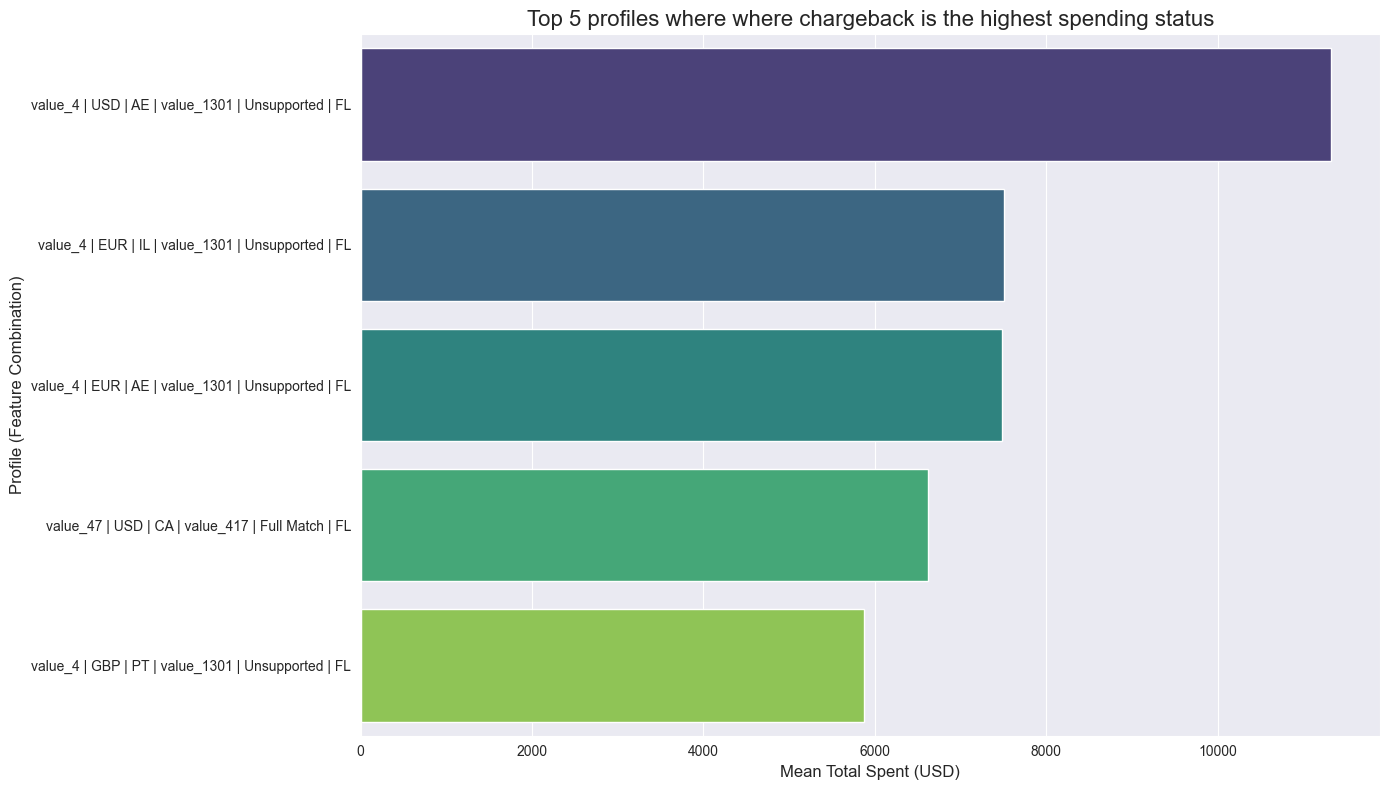

In [98]:
# Get the top 5 spending profiles
top_5_spending_profiles = grouped_data[grouped_data.status == 'chargeback'].sort_values(by=['total_spent_USD'], ascending=False).head(5)

# Create a new column to represent the profile as a single label
top_5_spending_profiles['profile'] = (
    top_5_spending_profiles['gateway'] + " | " +
    top_5_spending_profiles['currency_code'] + " | " +
    top_5_spending_profiles['billing_country_clean'] + " | " +
    top_5_spending_profiles['shipping_method'] + " | " +
    top_5_spending_profiles['V6_avs_result'] + " | " +
    top_5_spending_profiles['V7_bill_ship_name_match']
)

# Plot the bar chart
plt.figure(figsize=(14, 8))
sns.barplot(
    data=top_5_spending_profiles,
    x='total_spent_USD',
    y='profile',
    palette='viridis'
)

# Add labels and title
plt.title('Top 5 profiles where where chargeback is the highest spending status', fontsize=16)
plt.xlabel('Mean Total Spent (USD)', fontsize=12)
plt.ylabel('Profile (Feature Combination)', fontsize=12)
plt.tight_layout()
# plt.savefig('top5_profiles_chargeback_spent.png', dpi=300, bbox_inches='tight', facecolor='white')
# Show the plot
plt.show()


Cost wise - Transactions done in USD or EUR through gateway 4 and shipping method 1301 where the billing country is either Israel or the Emirates, are the most expensive chargeback transactions. For these transactions as well the billing address match between transaction and credit card file is unsupported. Even if both name and surname match.

In [130]:
risky_segments_ratio_analysis = df.groupby(['gateway', 'currency_code', 'billing_country_clean', 'shipping_method',
                'V6_avs_result', 'V7_bill_ship_name_match', 'status'], as_index=False).agg(average_total_spent_USD=('total_spent_USD','mean'), overall_total_spent_USD=('total_spent_USD','sum'), total_orders=('order_id','nunique'))

approved_chargeback_per_profile = risky_segments_ratio_analysis[((risky_segments_ratio_analysis.status == 'chargeback') & (risky_segments_ratio_analysis.total_orders >= 40)) | ((risky_segments_ratio_analysis.status == 'approved') & (risky_segments_ratio_analysis.total_orders >= 175))] #40 is the sample size per segment for stat signif inference on chargeback and 175 for approved.

# Group by the relevant profile columns (assuming "profile_columns" contain the identifiers)
profile_columns = ['gateway', 'currency_code', 'billing_country_clean', 'shipping_method',
                   'V6_avs_result', 'V7_bill_ship_name_match']

# Filter profiles that contain both 'approved' and 'chargeback'
filtered_profiles = approved_chargeback_per_profile.groupby(profile_columns).filter(
    lambda group: set(group['status']) == {'approved', 'chargeback'}
)

filtered_profiles

,gateway,currency_code,billing_country_clean,shipping_method,V6_avs_result,V7_bill_ship_name_match,status,average_total_spent_USD,overall_total_spent_USD,total_orders
17300,value_245,USD,US,value_1059,Unsupported,FL,approved,170.241100,311030.490000,1827
17301,value_245,USD,US,value_1059,Unsupported,FL,chargeback,211.998814,37523.790000,165
18209,value_4,BRL,BR,value_1301,Unsupported,FL,approved,88.358848,55577.715598,629
18210,value_4,BRL,BR,value_1301,Unsupported,FL,chargeback,90.527956,24804.659947,197
23490,value_65,USD,US,value_1794,Unsupported,FL,approved,388.666667,88616.000000,228
23491,value_65,USD,US,value_1794,Unsupported,FL,chargeback,427.950000,20113.650000,44


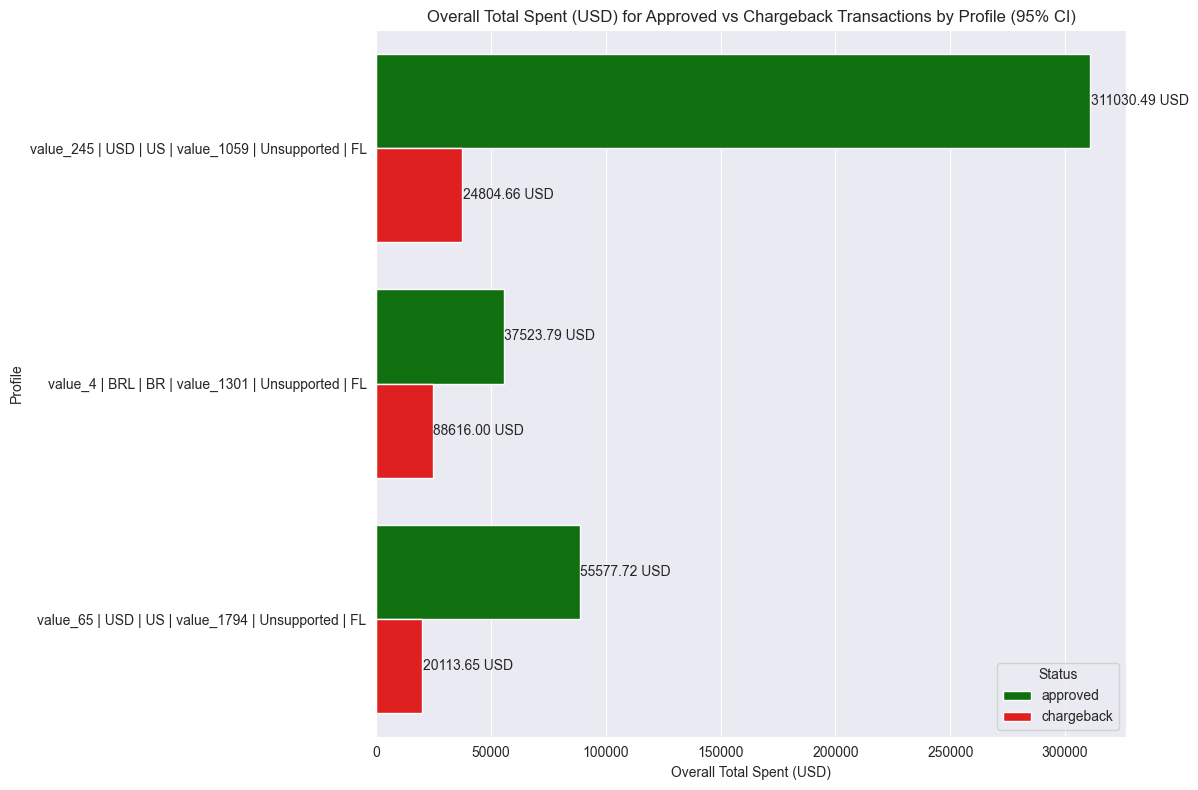

In [138]:
# Pivot the filtered profiles to get 'approved' and 'chargeback' values side-by-side
pivoted = filtered_profiles.pivot_table(
    index=profile_columns,
    columns='status',
    values='overall_total_spent_USD',
    aggfunc='sum'
).reset_index()

# Combine profile columns into a single string for easier visualization
pivoted['profile'] = pivoted[profile_columns].astype(str).agg(' | '.join, axis=1)

# Keep only relevant columns for plotting
plot_data = pivoted[['profile', 'approved', 'chargeback']].melt(
    id_vars='profile',
    var_name='status',
    value_name='overall_total_spent_USD'
)

# Sort by chargeback for better visualization
plot_data = plot_data.sort_values(by=['profile', 'status'])

# Create the bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=plot_data,
    y='profile',
    x='overall_total_spent_USD',
    hue='status',
    palette=['green', 'red']
)

# Add annotations for each bar
for bar, overall in zip(ax.patches, plot_data['overall_total_spent_USD']):
    x = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    ax.text(
        x + 50, y,
        f'{overall:.2f} USD',
        ha='left', va='center', fontsize=10
    )

# Finalize plot
plt.title('Overall Total Spent (USD) for Approved vs Chargeback Transactions by Profile (95% CI)')
plt.xlabel('Overall Total Spent (USD)')
plt.ylabel('Profile')
plt.legend(title='Status', loc='lower right')
plt.tight_layout()
plt.savefig('top3_profiles_approved_vs_chargeback_total_spent.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


In [122]:
# Pivot the filtered profiles to calculate the total spent for approved and chargeback transactions
pivoted = filtered_profiles.pivot_table(
    index=profile_columns,
    columns='status',
    values='overall_total_spent_USD',
    aggfunc='sum'
).reset_index()

# Combine profile columns into a single string for easier visualization
pivoted['profile'] = pivoted[profile_columns].astype(str).agg(' | '.join, axis=1)

# Compute the loss index: chargebacks / approved
pivoted['loss_index'] = pivoted['chargeback'] / pivoted['approved']

# Handle cases where 'approved' is 0 to avoid division by zero
pivoted['loss_index'] = pivoted['loss_index'].fillna(0)  # If 'approved' is 0, set loss index to 0

# Display the result
pivoted_loss_index = pivoted[['profile', 'approved', 'chargeback', 'loss_index']]
pivoted_loss_index.sort_values(by=['loss_index'], ascending=False)


status,profile,approved,chargeback,loss_index
1,value_4 | BRL | BR | value_1301 | Unsupported ...,55577.715598,24804.659947,0.446306
2,value_65 | USD | US | value_1794 | Unsupported...,88616.000000,20113.650000,0.226975
0,value_245 | USD | US | value_1059 | Unsupporte...,311030.490000,37523.790000,0.120643


The loss index quantifies the relative financial loss due to chargebacks compared to the revenue from approved transactions for each profile. Here's how to interpret it:

High Loss Index:

A high value (e.g., near or above 0.5) indicates that a significant portion of the profile's total transaction value is lost due to chargebacks.
Profiles with high loss indices are highly risky because chargebacks are eroding a large proportion of the potential revenue from approved transactions


Low Loss Index:

A low value (e.g., near 0.1 or lower) means the financial loss due to chargebacks is small relative to the revenue from approved transactions.
These profiles are less risky and might be performing relatively well in terms of fraud detection or prevention.

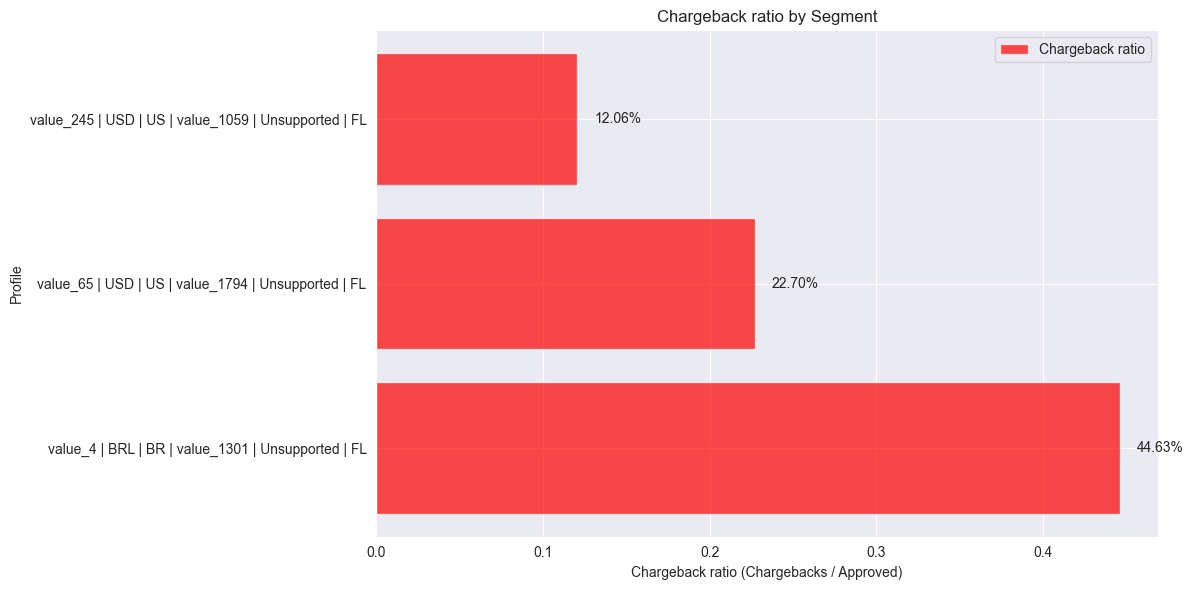

In [589]:
# Sort profiles by loss Chargeback ratio for better visualization
pivoted_loss_index = pivoted_loss_index.sort_values(by='loss_index', ascending=False)

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.barh(
    pivoted_loss_index['profile'],
    pivoted_loss_index['loss_index'],
    color='red',
    alpha=0.7,
    label='Chargeback ratio'
)

# Annotate the bars with Chargeback ratio values
for i, value in enumerate(pivoted_loss_index['loss_index']):
    plt.text(value + 0.01, i, f'{value*100:.2f}%', va='center', fontsize=10)

# Add titles and labels
plt.title('Chargeback ratio by Segment')
plt.xlabel('Chargeback ratio (Chargebacks / Approved)')
plt.ylabel('Profile')
plt.legend()
plt.tight_layout()
plt.savefig('top3_profiles_loss_index.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


the total value of chargebacks is 45% of the total value of approved transactions for this profile.
Breakdown:
Approved Transactions: This profile generates approximately $55,577.72 from approved transactions.
Chargebacks: It incurs about $24,804.66 in losses due to chargebacks.
Loss Index (0.45): For every $1 of approved transactions, approximately 45 cents are lost to chargebacks.
--> suggests a risky profile where chargebacks constitute a large fraction of the approved transaction value.

In [140]:
risky_segments_ratio_analysis

,gateway,currency_code,billing_country_clean,shipping_method,V6_avs_result,V7_bill_ship_name_match,status,average_total_spent_USD,overall_total_spent_USD,total_orders
0,value_1,USD,BR,value_1509,Missing,NO_MATCH,chargeback,1004.5900,1004.59,1
1,value_1,USD,MX,value_919,Missing,F,approved,139.9500,139.95,1
2,value_1,USD,US,value_1509,Missing,F,declined,186.9900,186.99,1
3,value_1,USD,US,value_1509,Missing,FL,approved,924.8900,1849.78,2
4,value_1,USD,US,value_1509,Missing,FL,declined,824.7400,824.74,1
...,...,...,...,...,...,...,...,...,...,...
25515,value_99,USD,US,value_514,Full Match,NO_MATCH,approved,193.7850,387.57,2
25516,value_99,USD,US,value_514,No Match,FL,approved,79.4800,79.48,1
25517,value_99,USD,US,value_514,Unsupported,FL,approved,168.3660,2525.49,15
25518,value_99,USD,US,value_514,Unsupported,FL,declined,172.0775,688.31,4


In [143]:
filtered_profiles_all = risky_segments_ratio_analysis.groupby(profile_columns).filter(
    lambda group: set(group['status']) == {'approved', 'chargeback'}
)

# Pivot the filtered profiles to calculate the total spent for approved and chargeback transactions
pivoted_all = filtered_profiles_all.pivot_table(
    index=profile_columns,
    columns='status',
    values='overall_total_spent_USD',
    aggfunc='sum'
).reset_index()

# Combine profile columns into a single string for easier visualization
pivoted_all['profile'] = pivoted_all[profile_columns].astype(str).agg(' | '.join, axis=1)

# Compute the loss index: chargebacks / approved
pivoted_all['loss_index'] = pivoted_all['chargeback'] / pivoted_all['approved']

# Handle cases where 'approved' is 0 to avoid division by zero
pivoted_all['loss_index'] = pivoted_all['loss_index'].fillna(0)  # If 'approved' is 0, set loss index to 0

# Display the result
pivoted_all_loss_index = pivoted_all[['profile', 'approved', 'chargeback', 'loss_index']]
pivoted_all_loss_index.sort_values(by=['loss_index'], ascending=False, inplace=True)

/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_51231/2291497700.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivoted_all_loss_index.sort_values(by=['loss_index'], ascending=False, inplace=True)


In [152]:
pivoted_all_loss_index

status,profile,approved,chargeback,loss_index
276,value_98 | GBP | AE | value_515 | Unsupported ...,242.480718,6259.279161,25.813513
176,value_242 | USD | RU | value_1878 | Unsupporte...,39.240000,980.730000,24.993119
69,value_181 | CAD | CA | value_1946 | Unsupporte...,68.660060,1009.506076,14.702959
231,value_54 | EUR | IT | value_1081 | Missing | FL,74.854613,955.378299,12.763119
39,value_16 | USD | VN | value_1273 | Unsupported...,149.960000,1834.560000,12.233662
...,...,...,...,...
51,value_169 | USD | CA | value_2185 | Full Match...,8190.300000,84.000000,0.010256
191,value_4 | EUR | AT | value_1609 | Missing | FL,45434.045692,424.957370,0.009353
242,value_65 | USD | CA | value_522 | Full Match | FL,28141.950000,164.400000,0.005842
22,value_131 | CAD | CA | value_219 | Zip Match | FL,9141.900471,29.944230,0.003275


In [686]:
pivoted_all_loss_index[pivoted_all_loss_index.chargeback > pivoted_all_loss_index.approved]

status,profile,approved,chargeback,loss_index
276,value_98 | GBP | AE | value_515 | Unsupported ...,242.480718,6259.279161,25.813513
176,value_242 | USD | RU | value_1878 | Unsupporte...,39.240000,980.730000,24.993119
69,value_181 | CAD | CA | value_1946 | Unsupporte...,68.660060,1009.506076,14.702959
231,value_54 | EUR | IT | value_1081 | Missing | FL,74.854613,955.378299,12.763119
39,value_16 | USD | VN | value_1273 | Unsupported...,149.960000,1834.560000,12.233662
...,...,...,...,...
131,value_201 | EUR | DE | value_369 | Missing | FL,498.563495,514.554757,1.032075
232,value_54 | USD | US | value_1620 | Missing | FL,686.150000,707.000000,1.030387
10,value_120 | USD | CA | value_1692 | Zip Match ...,4152.560000,4231.600000,1.019034
121,value_196 | USD | US | value_19 | Zip Match | ...,144.440000,146.980000,1.017585


In [153]:
pivoted_all_loss_index.head(3)

status,profile,approved,chargeback,loss_index
276,value_98 | GBP | AE | value_515 | Unsupported ...,242.480718,6259.279161,25.813513
176,value_242 | USD | RU | value_1878 | Unsupporte...,39.240000,980.730000,24.993119
69,value_181 | CAD | CA | value_1946 | Unsupporte...,68.660060,1009.506076,14.702959


In [162]:
pivoted_all_loss_index.head(3)['loss_index'].mean()/pivoted_all_loss_index.iloc[3:,:]['loss_index'].mean()

19.960671654063738

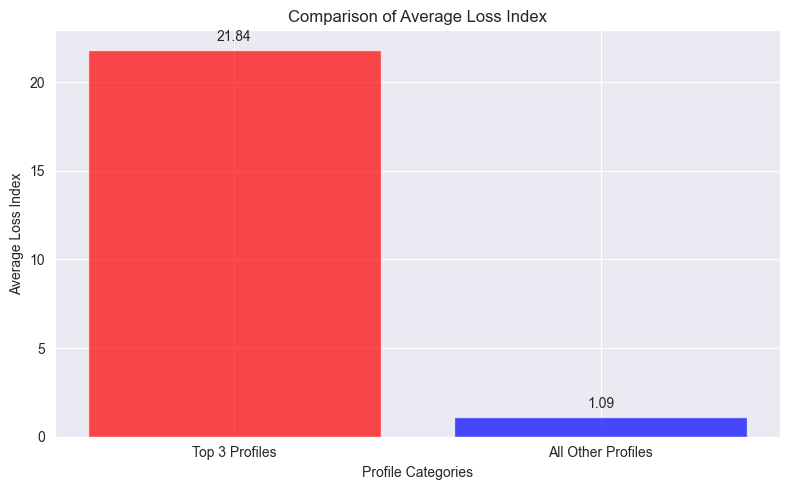

In [169]:
# Identify the top 3 profiles with the highest loss index
top_3_profiles = pivoted_all_loss_index.nlargest(3, 'loss_index')

# Calculate the average loss index for the top 3 profiles
average_loss_index_top_3 = top_3_profiles['loss_index'].mean()

# Calculate the average loss index for all other profiles
average_loss_index_others = pivoted_all_loss_index[~pivoted_all_loss_index['profile'].isin(top_3_profiles['profile'])]['loss_index'].mean()

# Data for plotting
categories = ['Top 3 Profiles', 'All Other Profiles']
averages = [average_loss_index_top_3, average_loss_index_others]

# Create the bar chart
plt.figure(figsize=(8, 5))
plt.bar(categories, averages, color=['red', 'blue'], alpha=0.7)

# Add value annotations
for i, value in enumerate(averages):
    plt.text(i, value + 0.5, f'{value:.2f}', ha='center', fontsize=10)

# Add titles and labels
plt.title('Comparison of Average Loss Index')
plt.ylabel('Average Loss Index')
plt.xlabel('Profile Categories')
plt.tight_layout()
plt.savefig('top3_profiles_non_signif_loss_index.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


In [183]:
# chargeback rate by shipping country
# Group data by shipping country and status, counting the number of orders
chargeback_rate_by_shipping_country = df.groupby(['shipping_country_clean', 'status'], as_index=False)['order_id'].nunique()

# Pivot the data to separate 'chargeback' and 'approved' counts into columns
chargeback_approved_pivot = chargeback_rate_by_shipping_country.pivot(
    index='shipping_country_clean',
    columns='status',
    values='order_id'
).fillna(0)  # Replace NaN with 0 for countries without certain statuses

# Calculate the chargeback rate
chargeback_approved_pivot['chargeback_rate'] = round((chargeback_approved_pivot['chargeback'] / (
    chargeback_approved_pivot['chargeback'] + chargeback_approved_pivot['approved']
))*100, 2)

# Reset the index to make the shipping country a column
chargeback_rate_results = chargeback_approved_pivot.reset_index()


In [185]:
signif_chargeback_Rate_per_shipping_country = chargeback_rate_results[(chargeback_rate_results.approved >= 175) & (chargeback_rate_results.chargeback >=40)].sort_values(by=['chargeback_rate'], ascending=False)

signif_chargeback_Rate_per_shipping_country.head(5)

status,shipping_country_clean,approved,chargeback,declined,chargeback_rate
127,MX,421.0,136.0,787.0,24.42
25,BR,2587.0,724.0,400.0,21.87
45,DE,5775.0,228.0,362.0,3.80
58,FR,7793.0,216.0,655.0,2.70
89,IT,3444.0,79.0,240.0,2.24


/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_51231/1684967860.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


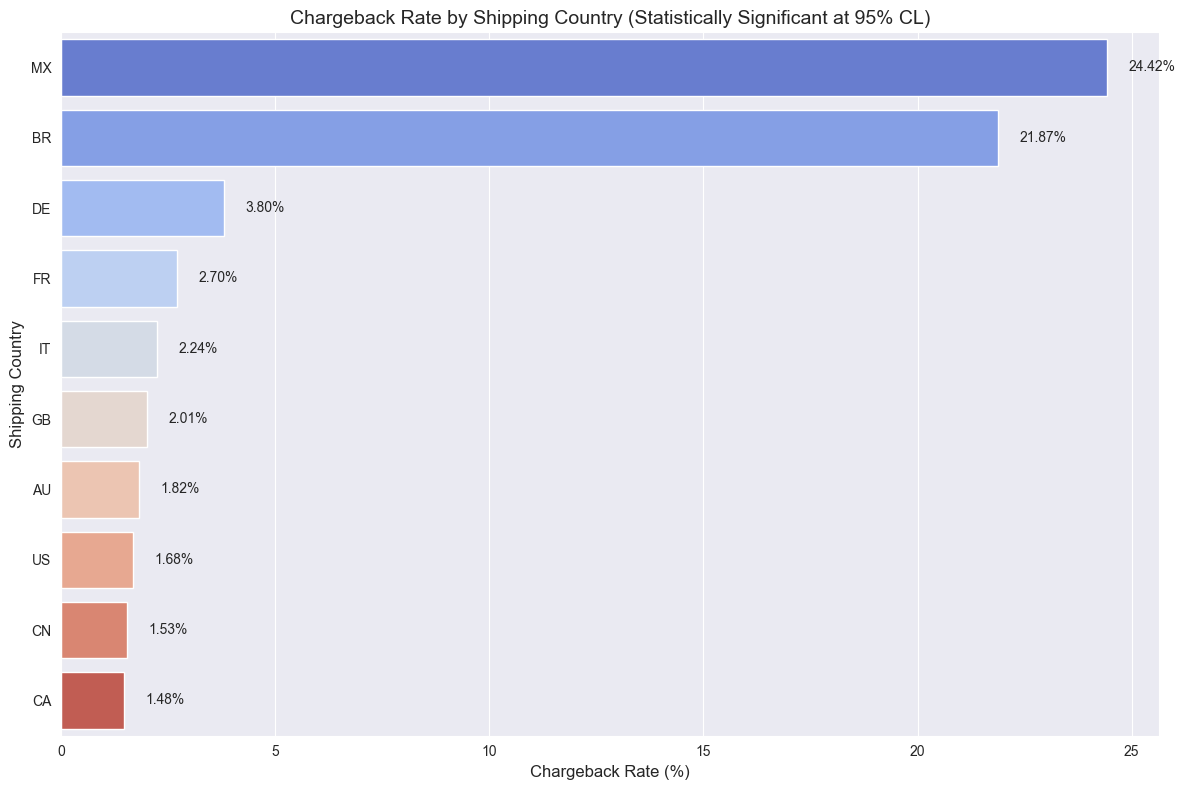

In [187]:
# Plot the chargeback rate by shipping country
plt.figure(figsize=(12, 8))
sns.barplot(
    data=signif_chargeback_Rate_per_shipping_country,
    x='chargeback_rate',
    y='shipping_country_clean',
    palette='coolwarm'
)

# Add value annotations to the bars
for i, value in enumerate(signif_chargeback_Rate_per_shipping_country['chargeback_rate']):
    plt.text(value + 0.5, i, f'{value:.2f}%', va='center', fontsize=10)

# Add titles and labels
plt.title('Chargeback Rate by Shipping Country (Statistically Significant at 95% CL)', fontsize=14)
plt.xlabel('Chargeback Rate (%)', fontsize=12)
plt.ylabel('Shipping Country', fontsize=12)
plt.tight_layout()
plt.savefig('chargeback_rate_by_shipping_country.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_51231/3989689041.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat_significant_methods['approval_rate'] = stat_significant_methods['approved'] / (
/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_51231/3989689041.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat_significant_methods['chargeback_rate'] = stat_significant_methods['chargeback'] / (


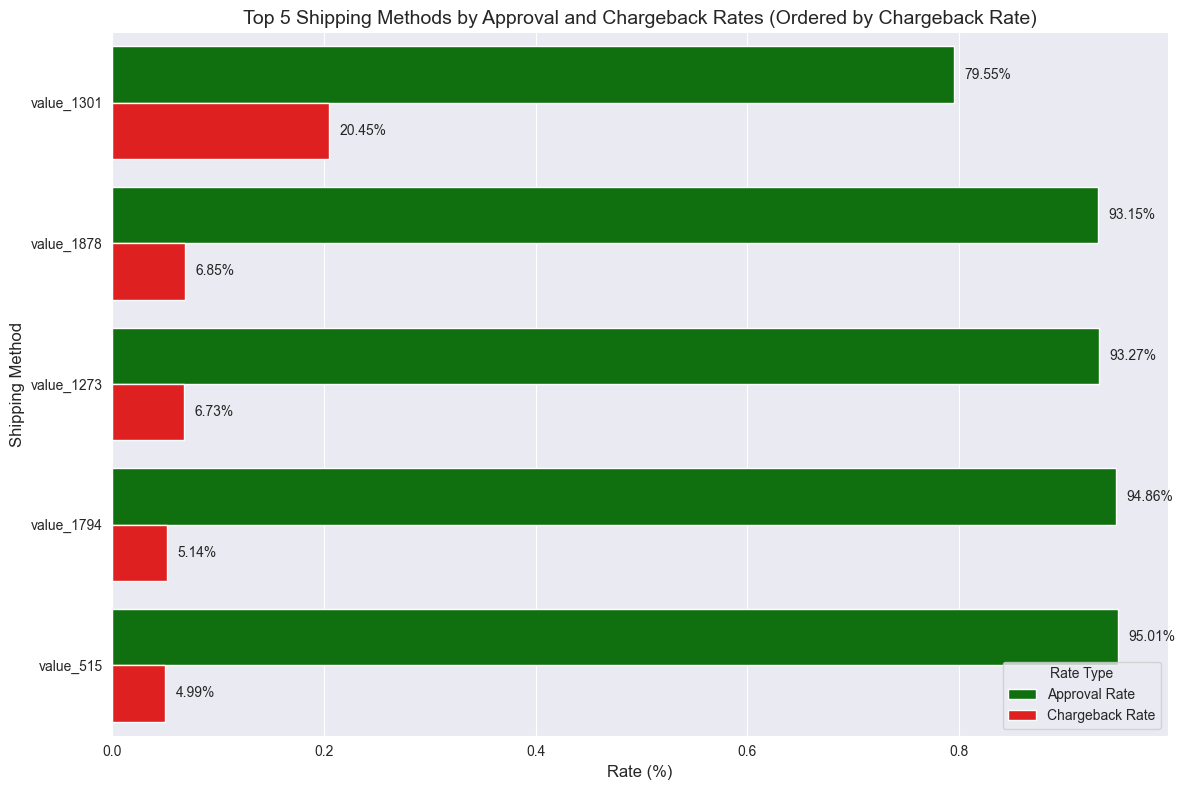

In [201]:


# Step 1: Group by shipping method and status, counting the number of orders
approval_chargeback_rate_by_shipping_method = df.groupby(['shipping_method', 'status'], as_index=False)['order_id'].nunique()

# Step 2: Pivot the data to create separate columns for approval and chargeback counts
pivoted_shipping_method = approval_chargeback_rate_by_shipping_method.pivot(
    index='shipping_method',
    columns='status',
    values='order_id'
).fillna(0)  # Replace NaN with 0 for missing statuses

# Step 3: Filter for statistical significance (at least 40 chargebacks and 175 approvals)
stat_significant_methods = pivoted_shipping_method[
    (pivoted_shipping_method['approved'] >= 175) &
    (pivoted_shipping_method['chargeback'] >= 40)
]

# Step 4: Calculate approval and chargeback rates
stat_significant_methods['approval_rate'] = stat_significant_methods['approved'] / (
    stat_significant_methods['approved'] + stat_significant_methods['chargeback']
)
stat_significant_methods['chargeback_rate'] = stat_significant_methods['chargeback'] / (
    stat_significant_methods['approved'] + stat_significant_methods['chargeback']
)

# Step 5: Reset index for easier plotting
stat_significant_methods = stat_significant_methods.reset_index()

# Step 6: Take the top 5 shipping methods based on chargeback rate (sorted in decreasing order)
top_5_methods = stat_significant_methods.nlargest(5, 'chargeback_rate')

# Step 7: Prepare data for plotting
plot_data = top_5_methods.melt(
    id_vars='shipping_method',
    value_vars=['approval_rate', 'chargeback_rate'],
    var_name='rate_type',
    value_name='rate'
)

# Step 8: Create the barplot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=plot_data,
    x='rate',
    y='shipping_method',
    hue='rate_type',
    order=top_5_methods.sort_values(by='chargeback_rate', ascending=False)['shipping_method'],  # Order by chargeback rate
    palette=['green', 'red']
)

# Add value annotations on bars
for bar in plt.gca().patches:
    if bar.get_width() > 0:  # Only annotate non-zero bars
        plt.gca().text(
            bar.get_width() + 0.01,  # Position slightly to the right of the bar
            bar.get_y() + bar.get_height() / 2,  # Center vertically
            f'{bar.get_width():.2%}',  # Format as percentage
            ha='left', va='center', fontsize=10
        )

# Add titles and labels
plt.title('Top 5 Shipping Methods by Approval and Chargeback Rates (Ordered by Chargeback Rate)', fontsize=14)
plt.xlabel('Rate (%)', fontsize=12)
plt.ylabel('Shipping Method', fontsize=12)

# Update legend to match colors and place it in the bottom-right corner
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    handles=handles,
    labels=['Approval Rate', 'Chargeback Rate'],  # Custom labels
    title='Rate Type',
    loc='lower right'  # Position bottom-right
)

plt.tight_layout()
plt.savefig('chargeback_rate_approval_rate_by_shipping_method.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


In [202]:
# v2 and v3 vs status
df[['V2_distance','V3_distance']].corr()

,V2_distance,V3_distance
V2_distance,1.000000,0.836016
V3_distance,0.836016,1.000000


these two datapoints seem to be highly correlated. in what are they different then?

In [203]:
df.groupby(['status'])['V2_distance'].mean()

status
approved      1026.969190
chargeback    1182.608684
declined      2496.907695
Name: V2_distance, dtype: float64

In [204]:
df.groupby(['status'])['V3_distance'].mean()

status
approved      1125.988939
chargeback    1177.587253
declined      2481.158861
Name: V3_distance, dtype: float64

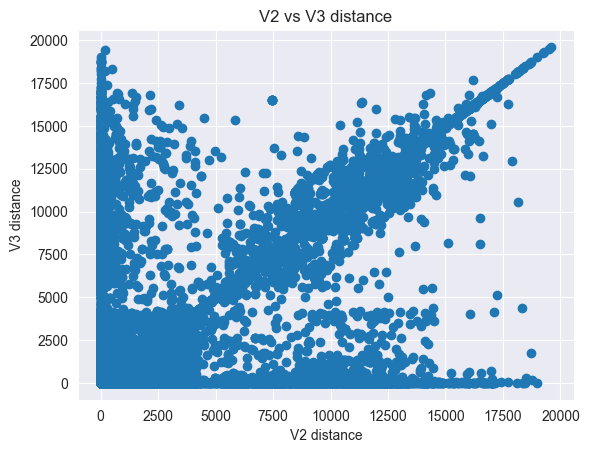

In [205]:
plt.scatter(df.V2_distance, df.V3_distance)
plt.xlabel('V2 distance')
plt.ylabel('V3 distance')
plt.title('V2 vs V3 distance')
plt.show()

it seems like the correlation is not perfect because of the datapoints that lay above and below the main diagonal x=y.

In [206]:
df[['V2_distance', 'V3_distance']].describe()

,V2_distance,V3_distance
count,157964.000000,158957.000000
mean,1176.859443,1262.328208
std,3088.102927,3206.620899
min,0.000000,0.000000
25%,4.000000,4.000000
50%,13.000000,13.000000
75%,174.000000,198.000000
max,19610.000000,19610.000000


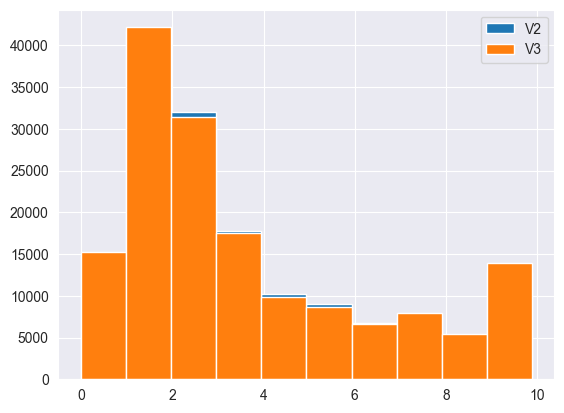

In [207]:
plt.hist(np.log(df.V2_distance + 1), label='V2')
plt.hist(np.log(df.V3_distance + 1), label='V3')
plt.legend()
plt.show()

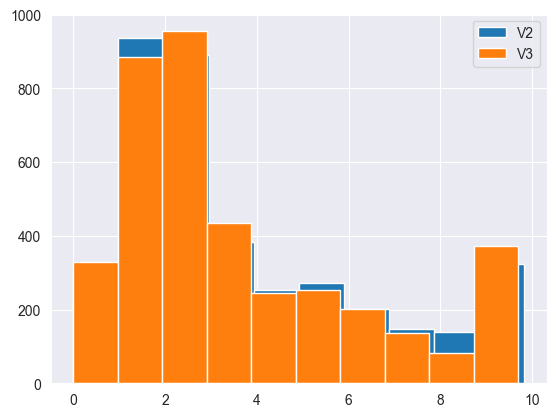

In [208]:
plt.hist(np.log(df[df.status=='chargeback'].V2_distance + 1), label='V2')
plt.hist(np.log(df[df.status=='chargeback'].V3_distance + 1), label='V3')
plt.legend()
plt.show()

In [209]:
df.isna().sum()/df.shape[0]

order_id                   0.000000
status                     0.000000
email_anoni                0.000000
billing_country_code       0.004089
shipping_country_code      0.001468
shipping_method            0.023889
created_at                 0.000000
total_spent                0.000000
currency_code              0.000000
gateway                    0.000726
V1_link                    0.000037
V2_distance                0.168611
V3_distance                0.163384
V4_our_age                 0.000037
V5_merchant_age            0.000037
V6_avs_result              0.000037
V7_bill_ship_name_match    0.000037
V8_ip                      0.025621
V9_cookie                  0.000968
V10_cookie                 0.009747
V11_cookie                 0.414237
email_domain               0.000000
year                       0.000000
month                      0.000000
season                     0.000000
day_of_week                0.000000
is_weekend                 0.000000
billing_country_clean      0

these 2 features have around 16-17% of missing values each, but their distribution is almost identical.

In [210]:
df[df.V2_distance > df.V3_distance].groupby(['status'])['order_id'].nunique()

status
approved      9886
chargeback     273
declined      2268
Name: order_id, dtype: int64

In [211]:
df[df.V2_distance < df.V3_distance].groupby(['status'])['order_id'].nunique()

status
approved      10248
chargeback      178
declined       1731
Name: order_id, dtype: int64

we have 53% more chargebacks when V2_distance > V3_distance compared to V2_distance < V3_distance. I will add this as feature:

In [212]:
df['V2_distance>V3_distance'] = np.where(df['V2_distance']>df['V3_distance'],1,0)
# since these features are highly correlated with each other, I will engineer 2 different features
df['V2_V3_avg_distance'] = (df['V2_distance'] + df['V3_distance'])/2 # average because the distribution is quite similar
df['V2_V3_interaction'] = (df['V2_distance'] * df['V3_distance']) #interaction, if v2 depends on v3 or vicevers

In [213]:
# let's check if these 3 features are discriminative

df.groupby(['status','V2_distance>V3_distance'])['order_id'].nunique()/df.groupby(['status'])['order_id'].nunique() #no

status      V2_distance>V3_distance
approved    0                          0.940228
            1                          0.059772
chargeback  0                          0.925349
            1                          0.074651
declined    0                          0.886532
            1                          0.113468
Name: order_id, dtype: float64

In [214]:

df.groupby('status')['V2_V3_avg_distance'].mean()['chargeback']/df.groupby('status')['V2_V3_avg_distance'].mean()['approved'] #on average the average of V2,V3 for chargeback is 1.09 the approved - let's keep it

1.0970955459202367

In [215]:

df.groupby('status')['V2_V3_interaction'].mean()['chargeback']/df.groupby('status')['V2_V3_interaction'].mean()['approved'] #on average the interaction term for chargeback is 1.18 the approved - let's keep it



1.1849632635071496

let's see if v2 and v3 are correlated to other numerical features:

In [216]:
df[['total_spent_USD','V2_distance', 'V3_distance','V4_our_age','V5_merchant_age', 'V8_ip', 'V9_cookie', 'V10_cookie', 'V11_cookie','V2_V3_avg_distance','V2_V3_interaction']].corr()

,total_spent_USD,V2_distance,V3_distance,V4_our_age,V5_merchant_age,V8_ip,V9_cookie,V10_cookie,V11_cookie,V2_V3_avg_distance,V2_V3_interaction
total_spent_USD,1.000000,0.049105,0.044297,0.061216,0.013702,0.045617,0.047896,0.179606,0.087058,0.049009,0.032568
V2_distance,0.049105,1.000000,0.836016,0.049671,0.005155,0.118455,0.039970,0.044467,0.013824,0.956644,0.908450
V3_distance,0.044297,0.836016,1.000000,0.052180,0.002498,0.109975,0.044392,0.034327,0.023297,0.959585,0.870694
V4_our_age,0.061216,0.049671,0.052180,1.000000,0.007440,-0.009750,0.019174,0.053236,0.136960,0.052692,0.040890
V5_merchant_age,0.013702,0.005155,0.002498,0.007440,1.000000,-0.002669,0.007346,0.022975,0.049137,0.003964,0.000607
V8_ip,0.045617,0.118455,0.109975,-0.009750,-0.002669,1.000000,0.102816,0.099466,-0.031715,0.119903,0.076594
V9_cookie,0.047896,0.039970,0.044392,0.019174,0.007346,0.102816,1.000000,-0.037776,0.255656,0.044903,0.032105
V10_cookie,0.179606,0.044467,0.034327,0.053236,0.022975,0.099466,-0.037776,1.000000,-0.124429,0.041024,0.029753
V11_cookie,0.087058,0.013824,0.023297,0.136960,0.049137,-0.031715,0.255656,-0.124429,1.000000,0.019520,0.004758
V2_V3_avg_distance,0.049009,0.956644,0.959585,0.052692,0.003964,0.119903,0.044903,0.041024,0.019520,1.000000,0.928098


In [217]:
# since v2, v3 are highly correlated with each other - we drop them. since V2_distance>V3_distance does not discriminate, we drop it. and since V2_V3_interaction seems to disciminate better than V2_V3_avg_distance and they are correlated (0.93) - we drop V2_V3_avg_distance.

df.drop(columns=['V2_distance', 'V3_distance','V2_distance>V3_distance', 'V2_V3_avg_distance'], inplace=True)

all the other correlations seem quite low.

In [218]:
# V4 and V5
df[['V4_our_age','V5_merchant_age']].describe()

,V4_our_age,V5_merchant_age
count,189993.000000,189993.000000
mean,653.947451,216.220645
std,2046.051781,6976.480661
min,0.000000,-323.000000
25%,0.000000,0.000000
50%,51.000000,1.000000
75%,692.000000,82.000000
max,730603.000000,736666.000000


In [219]:
df[['V4_our_age','V5_merchant_age']].corr()

,V4_our_age,V5_merchant_age
V4_our_age,1.00000,0.00744
V5_merchant_age,0.00744,1.00000


In [220]:
df.groupby(['status'])['V4_our_age'].mean()

status
approved      653.083143
chargeback    801.660377
declined      627.429164
Name: V4_our_age, dtype: float64

In [221]:
df.groupby(['status'])['V5_merchant_age'].mean()

status
approved      243.197566
chargeback     59.256033
declined       28.814372
Name: V5_merchant_age, dtype: float64

In [222]:
df['V4_our_age'].value_counts()/df['V4_our_age'].value_counts().sum()

V4_our_age
0.0       0.424031
1.0       0.006516
2.0       0.003558
3.0       0.002821
6.0       0.002584
            ...   
5351.0    0.000005
5946.0    0.000005
6434.0    0.000005
3563.0    0.000005
4633.0    0.000005
Name: count, Length: 6324, dtype: float64

In [223]:
df['V5_merchant_age'].value_counts()/df['V5_merchant_age'].value_counts().sum()

V5_merchant_age
 0.0       0.334344
 1.0       0.257773
 2.0       0.011864
 3.0       0.008227
 4.0       0.006295
             ...   
 3576.0    0.000005
 2609.0    0.000005
 2701.0    0.000005
 2638.0    0.000005
-12.0      0.000005
Name: count, Length: 2920, dtype: float64

42% of the values of V4_our_age are zeros, 33% of the values of V5_merchant_age are zeros. both distributions are very skewed.

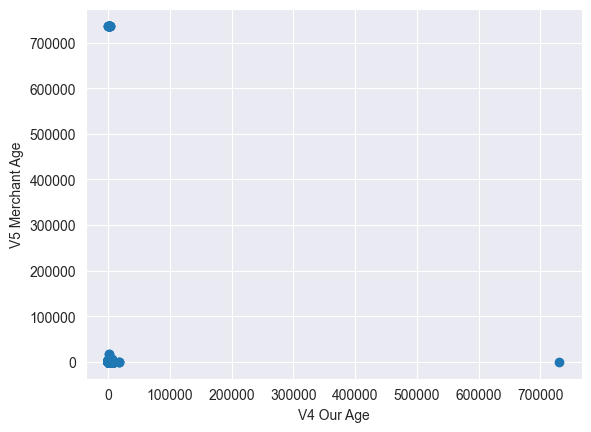

In [224]:
plt.scatter(df['V4_our_age'], df['V5_merchant_age'])
plt.xlabel('V4 Our Age')
plt.ylabel('V5 Merchant Age')
plt.show()

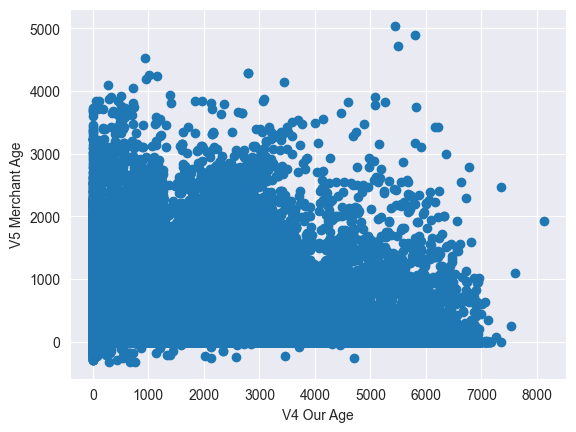

In [225]:
plt.scatter(df[(df['V4_our_age']<15000) & (df['V5_merchant_age']<15000)]['V4_our_age'], df[(df['V4_our_age']<15000) & (df['V5_merchant_age']<15000)]['V5_merchant_age'])
plt.xlabel('V4 Our Age')
plt.ylabel('V5 Merchant Age')
plt.show()

In [226]:
df[(df['V4_our_age']<15000) & (df['V5_merchant_age']<15000)][['V4_our_age','V5_merchant_age']].corr()

,V4_our_age,V5_merchant_age
V4_our_age,1.000000,0.195469
V5_merchant_age,0.195469,1.000000


when we drop some outliers based on the scatterplot, the correlation increases.

In [227]:
df[(df['V4_our_age']<15000) & (df['V5_merchant_age']<15000)].shape[0]/df.shape[0]

0.9998421052631579

removing these outliers would still allow us to keep 99% of the data.

In [228]:
df.groupby(['status'])['V4_our_age'].mean()

status
approved      653.083143
chargeback    801.660377
declined      627.429164
Name: V4_our_age, dtype: float64

In [229]:
df.groupby(['status'])['V5_merchant_age'].mean()

status
approved      243.197566
chargeback     59.256033
declined       28.814372
Name: V5_merchant_age, dtype: float64

dropping the outliers would not change drastically the average value of the feature per status, even if the increase in correlation after dropping the outliers is significant. chargeback transactions have a higher average value of V4_our_age, but lower values for V5_merchant_age.

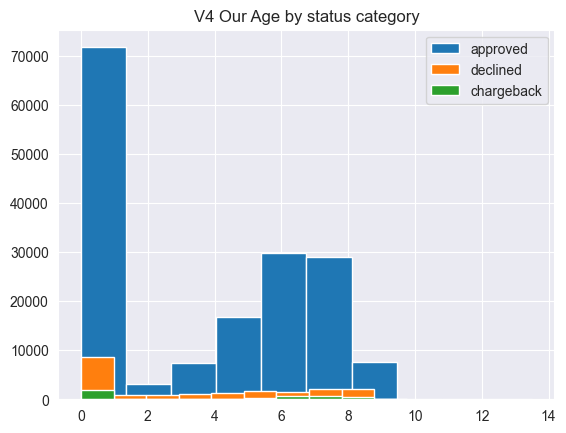

In [230]:
plt.hist(np.log(df[df.status=='approved']['V4_our_age'] + 1), bins=10, label='approved')
plt.hist(np.log(df[df.status=='declined']['V4_our_age'] + 1), bins=10, label='declined')
plt.hist(np.log(df[df.status=='chargeback']['V4_our_age'] + 1), bins=10, label='chargeback')
plt.legend()
plt.title('V4 Our Age by status category')
plt.show()

In [231]:
# for each matching level, what's the most common status?
df.groupby(['V6_avs_result','status'], as_index=False)['order_id'].nunique().sort_values(by=['V6_avs_result','order_id'], ascending=[True, False]).groupby(['V6_avs_result']).head(1)

,V6_avs_result,status,order_id
0,Address Match,approved,1356
3,Full Match,approved,41681
6,Missing,approved,52815
9,No Match,approved,5012
12,Other,approved,257
15,Unsupported,approved,57788
18,Zip Match,approved,6484


there is no category of V6_avs_result where chargeback is the most common status.

In [232]:
df.groupby(['V7_bill_ship_name_match', 'status'], as_index=False)['order_id'].nunique().sort_values(by=['V7_bill_ship_name_match','order_id'], ascending=[True, False]).groupby(['V7_bill_ship_name_match']).head(2)

,V7_bill_ship_name_match,status,order_id
0,F,approved,3151
2,F,declined,414
3,FL,approved,147721
5,FL,declined,15572
6,L,approved,4290
8,L,declined,757
9,NO_MATCH,approved,10231
11,NO_MATCH,declined,3242


there is no category of V7_bill_ship_name_match where chargeback is the most common status.

In [233]:
df['V8_ip'].value_counts() # i address it as continuous

V8_ip
0.00    177296
1.80      4995
3.00      1131
1.00       213
1.29       152
         ...  
0.96         1
2.34         1
2.58         1
0.85         1
2.63         1
Name: count, Length: 160, dtype: int64

In [234]:
df['V8_ip'].describe() # very skewed

count    185132.000000
mean          0.076579
std           0.387298
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.000000
Name: V8_ip, dtype: float64

In [235]:
df.groupby(['status'])['V8_ip'].describe()

,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
approved,161147.0,0.028921,0.231741,0.0,0.0,0.0,0.0,3.0
chargeback,4484.0,0.071215,0.366775,0.0,0.0,0.0,0.0,3.0
declined,19501.0,0.471633,0.880057,0.0,0.0,0.0,0.0,4.0


In [236]:
df.groupby(['status'], as_index=False)['V8_ip'].mean() # it seems hard to discriminate with this feature between approved and chargeback distribution (in the histogram they overlap as well).

,status,V8_ip
0,approved,0.028921
1,chargeback,0.071215
2,declined,0.471633


chargeback transactions have an average ip risk score which is way higher than approved.

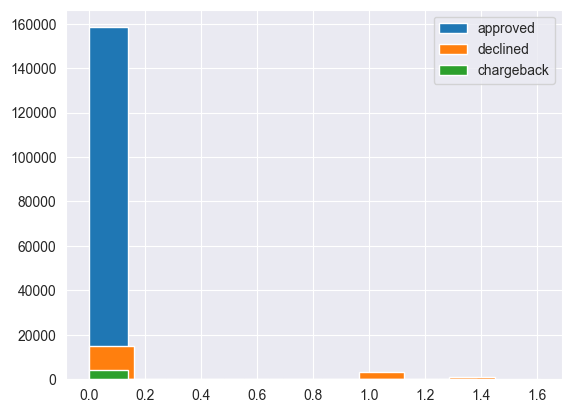

In [237]:
plt.hist(np.log(df[df.status == 'approved']['V8_ip']+1), label='approved')
plt.hist(np.log(df[df.status == 'declined']['V8_ip']+1), label='declined')
plt.hist(np.log(df[df.status == 'chargeback']['V8_ip']+1), label='chargeback')
plt.legend()
plt.show()

In [238]:
# is there a connection between IP address risk score and shipping method/shipping country and avg total_spent_USD?

# for higher risk scores (around 3-4) what are the most frequent countries?
df[df.V8_ip >= 3].groupby('shipping_country_clean', as_index=False)['order_id'].nunique().sort_values(by=['order_id'], ascending=False)

,shipping_country_clean,order_id
67,US,667
7,CA,64
23,GB,58
13,DE,39
21,FR,37
...,...,...
38,LB,1
39,LK,1
41,LV,1
43,MK,1


higher risk scores belong to western countries like:
- US
- CA
- GB
- DE
- FR


In [239]:
df[df.V8_ip >= 3].groupby(['shipping_method','shipping_country_clean'], as_index=False)['order_id'].nunique().sort_values(by=['order_id'], ascending=False)

,shipping_method,shipping_country_clean,order_id
0,value_1059,US,276
273,value_434,US,96
59,value_1273,US,38
138,value_1692,US,32
310,value_529,US,19
...,...,...,...
150,value_1853,US,1
145,value_1794,CA,1
144,value_1794,AU,1
143,value_178,CA,1


high IPs risk scores are linked to 3 shipping methods:
- value_1059
- value_434
- value_1273
which all deliver to US.

In [240]:
# is there a correlation between IP risk score and total_spent_USD? no it doesn't seem to be.
df[['V8_ip','total_spent_USD']].corr()

,V8_ip,total_spent_USD
V8_ip,1.000000,0.045617
total_spent_USD,0.045617,1.000000


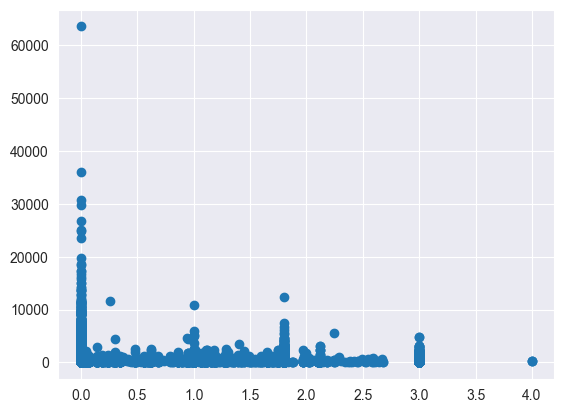

In [241]:
plt.scatter(df['V8_ip'], df['total_spent_USD'])
plt.show()

In [242]:
df[['V9_cookie','V10_cookie','V11_cookie']].corr()

,V9_cookie,V10_cookie,V11_cookie
V9_cookie,1.000000,-0.037776,0.255656
V10_cookie,-0.037776,1.000000,-0.124429
V11_cookie,0.255656,-0.124429,1.000000


In [243]:
df.groupby(['status'])['V9_cookie'].mean()

status
approved      81.792318
chargeback    74.655006
declined      87.376480
Name: V9_cookie, dtype: float64

In [244]:
df.groupby(['status'])['V10_cookie'].mean()

status
approved       4.407578
chargeback    13.729512
declined      10.902953
Name: V10_cookie, dtype: float64

In [245]:
df.groupby(['status'])['V11_cookie'].mean()

status
approved      52.028068
chargeback    13.169760
declined      16.770325
Name: V11_cookie, dtype: float64

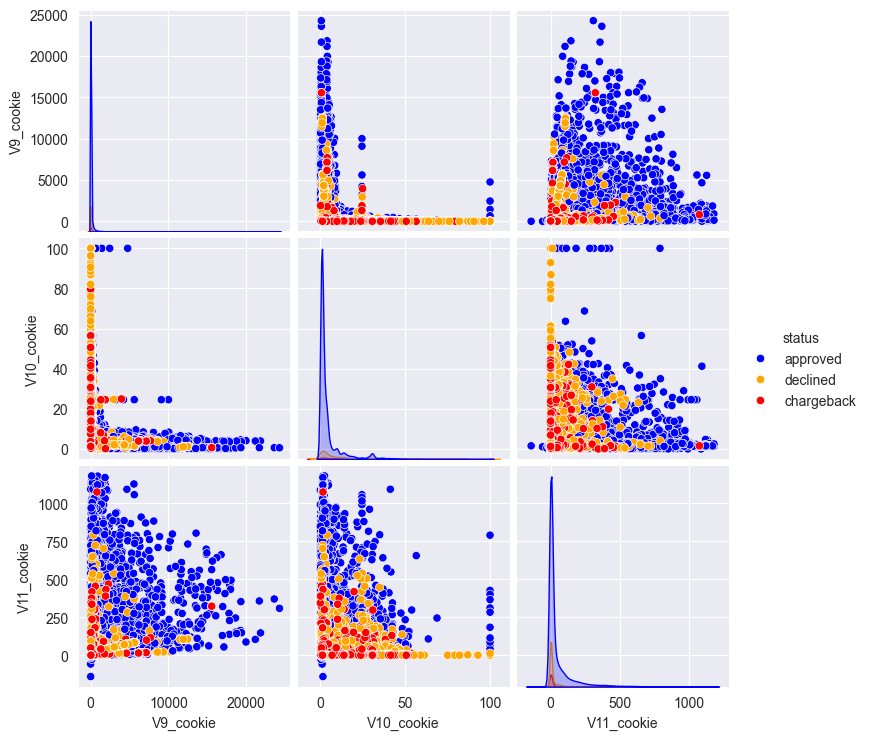

In [246]:
sns.pairplot(df[['V9_cookie', 'V10_cookie', 'V11_cookie', 'status']], hue='status', palette={'approved': 'blue', 'chargeback': 'red', 'declined': 'orange'})
plt.show()

the categories overlap in each plot, so that it's a bit hard to use v9, v10, v11 to discriminate between the classes.

## Examples of segments with sub-optimal performance (e.g. segments where they could safely approve more than they currently are)

To understand which segments could have safely been approved, I want to see if there are some profiles shared by approved and declined orders. Basically what we're trying to do here is to isolate the FN, meaning transactions that were potentially legitimate (their real label was positive) but that were blocked by the merchant's model (prediction was negative) by looking at common profiles between approved and declined transactions.



In [247]:
df_approved = df[df.status == 'approved']
df_declined = df[df.status == 'declined']

In [248]:
columns_suboptimal = ['shipping_method','currency_code','gateway','V1_link','V6_avs_result', 'V7_bill_ship_name_match','email_domain','season', 'is_weekend', 'billing_region','shipping_region']


In [249]:
df_approved_aggregate = df_approved.groupby(columns_suboptimal, as_index=False).agg(avg_total_spent_USD=('total_spent_USD','mean'))


In [250]:
df_declined_aggregate = df_declined.groupby(columns_suboptimal, as_index=False).agg(avg_total_spent_USD=('total_spent_USD','mean'))


To isolate FN, I will look at declined segments with high average total_spend_USD and see if we find a subset of features with the same values in the table of approved transactions.

In [251]:
df_declined_aggregate.sort_values(by=['avg_total_spent_USD'], ascending=False, inplace=True)

In [252]:
def find_common_segments_optimized(df_declined_aggregate, df_approved_aggregate, columns_suboptimal):
    """
    Optimized approach to find common segments between declined and approved datasets.

    Parameters:
        df_declined_aggregate (pd.DataFrame): Declined aggregated dataframe.
        df_approved_aggregate (pd.DataFrame): Approved aggregated dataframe.
        columns_suboptimal (list): List of columns to consider.

    Returns:
        list: List of common segments with feature combinations.
    """
    # Perform an inner join using all columns in columns_suboptimal
    merged = pd.merge(
        df_declined_aggregate[columns_suboptimal],
        df_approved_aggregate[columns_suboptimal],
        on=columns_suboptimal,
        how='inner'
    )

    # Sort the merged dataframe by the specificity of matches (most specific first)
    merged = merged.drop_duplicates().sort_values(by=columns_suboptimal)

    # Track segments that are specific and exclude redundant ones
    common_segments = []
    seen_segments = set()

    for _, row in merged.iterrows():
        segment = tuple((col, row[col]) for col in columns_suboptimal if pd.notnull(row[col]))

        # If no broader segment exists, add this one
        if not any(set(segment).issubset(set(existing)) for existing in seen_segments):
            common_segments.append(dict(segment))
            seen_segments.add(segment)

    return common_segments

segments = find_common_segments_optimized(df_declined_aggregate, df_approved_aggregate, columns_suboptimal)

segments_df = pd.DataFrame(segments)

In [253]:
segments_df.shape, segments_df.drop_duplicates().shape

((3701, 11), (3701, 11))

To see which segments should have been approved - I look at the common categorical combinations between approved and declines:

In [254]:
segments_df.head()

,shipping_method,currency_code,gateway,V1_link,V6_avs_result,V7_bill_ship_name_match,email_domain,season,is_weekend,billing_region,shipping_region
0,value_103,USD,value_196,False,Missing,FL,gmail,Winter,False,Europe,Europe
1,value_103,USD,value_196,False,Missing,FL,hotmail,Winter,True,Europe,Europe
2,value_1039,GBP,value_196,False,Missing,FL,gmail,Spring,False,Europe,Europe
3,value_105,USD,value_169,False,Missing,FL,personal_domain,Winter,True,Europe,Europe
4,value_1056,MXN,value_85,False,Missing,FL,gmail,Fall,False,North America,North America


In [255]:
def calculate_declined_metrics(segments_df, df_declined_aggregate, columns_suboptimal):
    """
    Calculate the number of declined orders and total spent for each segment.

    Parameters:
        segments_df (pd.DataFrame): DataFrame of identified segments.
        df_declined_aggregate (pd.DataFrame): Declined aggregated DataFrame.
        columns_suboptimal (list): List of columns to consider for the join.

    Returns:
        pd.DataFrame: Segments DataFrame with declined order counts and total spent.
    """
    # Perform a left join to find matching declined orders for each segment
    merged = pd.merge(
        segments_df,
        df_declined,
        on=columns_suboptimal,
        how='left'
    )

    # Group by the segment columns and calculate metrics
    metrics = merged.groupby(columns_suboptimal).agg(
        declined_order_count=('order_id', 'nunique'),
        total_declined_spent=('total_spent_USD', 'sum'),
        avg_declined_spent=('total_spent_USD', 'mean')
    ).reset_index()

    # Merge metrics back with the segments DataFrame
    result = pd.merge(segments_df, metrics, on=columns_suboptimal, how='left')

    return result

segments_with_metrics = calculate_declined_metrics(segments_df, df_declined_aggregate, columns_suboptimal)



In [256]:
segments_with_metrics

,shipping_method,currency_code,gateway,V1_link,V6_avs_result,V7_bill_ship_name_match,email_domain,season,is_weekend,billing_region,shipping_region,declined_order_count,total_declined_spent,avg_declined_spent
0,value_103,USD,value_196,False,Missing,FL,gmail,Winter,False,Europe,Europe,1,120.000000,120.000000
1,value_103,USD,value_196,False,Missing,FL,hotmail,Winter,True,Europe,Europe,1,155.000000,155.000000
2,value_1039,GBP,value_196,False,Missing,FL,gmail,Spring,False,Europe,Europe,1,83.184687,83.184687
3,value_105,USD,value_169,False,Missing,FL,personal_domain,Winter,True,Europe,Europe,1,145.000000,145.000000
4,value_1056,MXN,value_85,False,Missing,FL,gmail,Fall,False,North America,North America,1,6.672841,6.672841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3696,value_964,USD,value_47,False,Unsupported,FL,gmail,Summer,False,North America,North America,1,121.960000,121.960000
3697,value_985,USD,value_249,False,Missing,FL,gmail,Winter,False,Asia,Asia,1,315.600000,315.600000
3698,value_996,USD,value_205,False,Full Match,FL,gmail,Summer,False,North America,North America,1,203.250000,203.250000
3699,value_998,USD,value_201,False,Unsupported,FL,gmail,Winter,False,North America,North America,1,190.500000,190.500000


In [257]:
top5_segments_frequency = segments_with_metrics.sort_values(by=['declined_order_count'], ascending=False).head(5)
top5_segments_frequency

,shipping_method,currency_code,gateway,V1_link,V6_avs_result,V7_bill_ship_name_match,email_domain,season,is_weekend,billing_region,shipping_region,declined_order_count,total_declined_spent,avg_declined_spent
276,value_1059,USD,value_245,False,Unsupported,FL,gmail,Winter,False,North America,North America,139,33944.49,244.204964
212,value_1059,USD,value_245,False,No Match,FL,gmail,Spring,False,North America,North America,120,21742.49,181.187417
272,value_1059,USD,value_245,False,Unsupported,FL,gmail,Spring,False,North America,North America,117,37688.31,322.122308
308,value_1059,USD,value_245,False,Unsupported,FL,qq,Spring,False,North America,North America,97,47374.58,488.397732
266,value_1059,USD,value_245,False,Unsupported,FL,163,Winter,False,North America,North America,86,46675.99,542.744070


In [258]:
top5_segments_frequency.groupby(['shipping_method', 'currency_code','gateway','V1_link','V7_bill_ship_name_match', 'is_weekend','billing_region','shipping_region'], as_index=False).agg(total_declined=('declined_order_count', 'sum'), total_declined_spent=('total_declined_spent', 'sum'))

,shipping_method,currency_code,gateway,V1_link,V7_bill_ship_name_match,is_weekend,billing_region,shipping_region,total_declined,total_declined_spent
0,value_1059,USD,value_245,False,FL,False,North America,North America,559,187425.86


/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_51231/2943543354.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


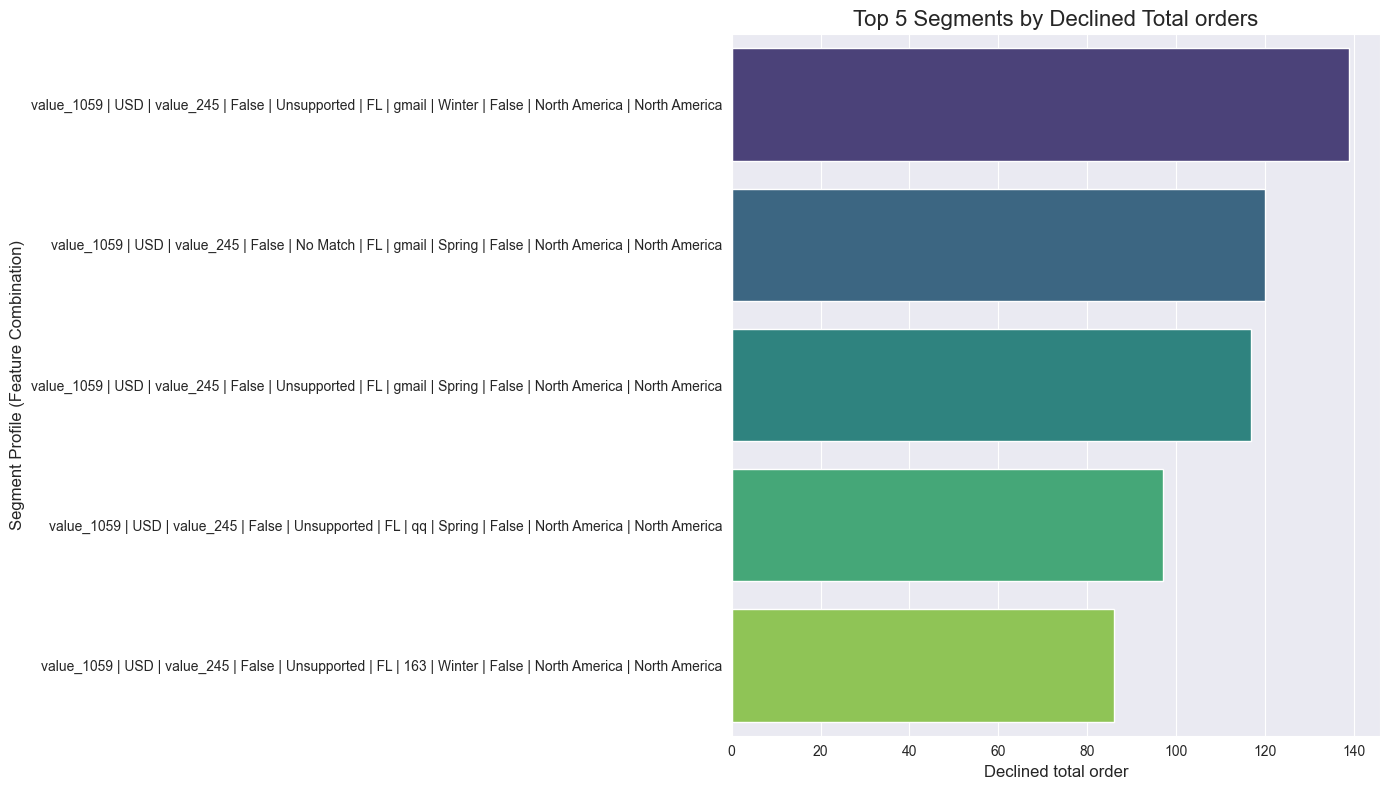

In [259]:


def plot_top_5_segments_with_metrics(top5_segments_frequency):
    """
    Plot the top 5 segments with their profiles and attach declined order count and total declined spent to the bars.

    Parameters:
        top5_segments_frequency (pd.DataFrame): DataFrame containing the top 5 segments with metrics.
    """
    # Convert boolean columns to strings if necessary
    for col in top5_segments_frequency.columns:
        if top5_segments_frequency[col].dtype == 'bool':
            top5_segments_frequency[col] = top5_segments_frequency[col].astype(str)

    # Create a new column to represent the profile as a single label
    top5_segments_frequency['profile'] = (
        top5_segments_frequency['shipping_method'] + " | " +
        top5_segments_frequency['currency_code'] + " | " +
        top5_segments_frequency['gateway'] + " | " +
        top5_segments_frequency['V1_link'] + " | " +
        top5_segments_frequency['V6_avs_result'] + " | " +
        top5_segments_frequency['V7_bill_ship_name_match'] + " | " +
        top5_segments_frequency['email_domain'] + " | " +
        top5_segments_frequency['season'] + " | " +
        top5_segments_frequency['is_weekend'].astype(str) + " | " +
        top5_segments_frequency['billing_region'] + " | " +
        top5_segments_frequency['shipping_region']
    )

    # Plot the bar chart
    plt.figure(figsize=(14, 8))
    sns.barplot(
        data=top5_segments_frequency,
        x='declined_order_count',
        y='profile',
        palette='viridis'
    )

    # Add labels and title
    plt.title('Top 5 Segments by Declined Total orders', fontsize=16)
    plt.xlabel('Declined total order', fontsize=12)
    plt.ylabel('Segment Profile (Feature Combination)', fontsize=12)
    plt.tight_layout()
    # plt.savefig('top5_segments_declined_count.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

# Assuming top5_segments_frequency is a DataFrame with the required columns
# Replace it with your actual DataFrame containing the necessary data
plot_top_5_segments_with_metrics(top5_segments_frequency)

In [269]:
top5_segments_cost = segments_with_metrics[segments_with_metrics.declined_order_count >= 39].sort_values(by=['total_declined_spent'], ascending=False).head(5)
top5_segments_cost

,shipping_method,currency_code,gateway,V1_link,V6_avs_result,V7_bill_ship_name_match,email_domain,season,is_weekend,billing_region,shipping_region,declined_order_count,total_declined_spent,avg_declined_spent
308,value_1059,USD,value_245,False,Unsupported,FL,qq,Spring,False,North America,North America,97,47374.58,488.397732
266,value_1059,USD,value_245,False,Unsupported,FL,163,Winter,False,North America,North America,86,46675.99,542.744070
262,value_1059,USD,value_245,False,Unsupported,FL,163,Spring,False,North America,North America,74,39501.31,533.801486
272,value_1059,USD,value_245,False,Unsupported,FL,gmail,Spring,False,North America,North America,117,37688.31,322.122308
276,value_1059,USD,value_245,False,Unsupported,FL,gmail,Winter,False,North America,North America,139,33944.49,244.204964


In [270]:
top5_segments_cost.declined_order_count.sum()

513

In [271]:
top5_segments_cost.total_declined_spent.sum()

205184.68

/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_51231/1741781387.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


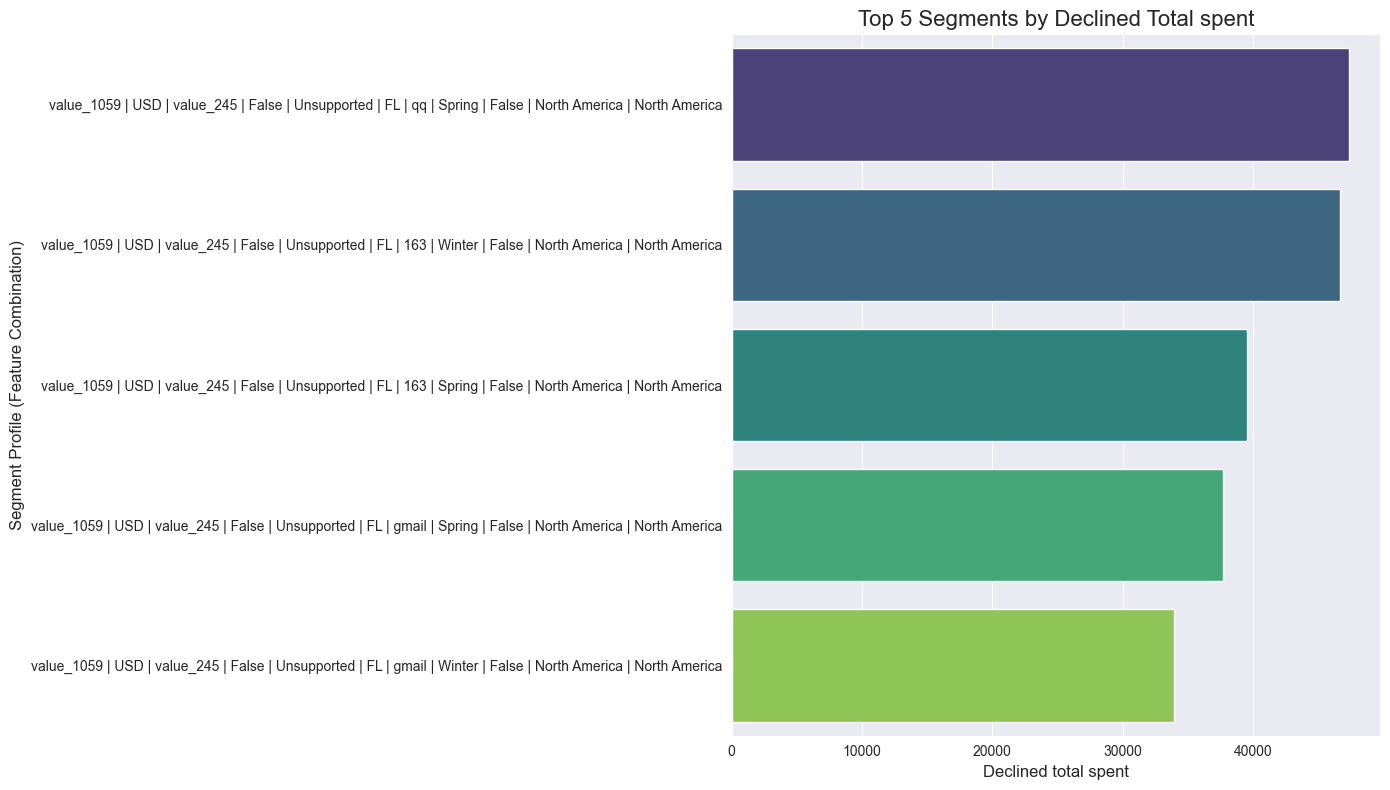

In [263]:


def plot_top_5_segments_with_metrics(top5_segments_frequency):
    """
    Plot the top 5 segments with their profiles and attach declined order count and total declined spent to the bars.

    Parameters:
        top5_segments_frequency (pd.DataFrame): DataFrame containing the top 5 segments with metrics.
    """
    # Convert boolean columns to strings if necessary
    for col in top5_segments_frequency.columns:
        if top5_segments_frequency[col].dtype == 'bool':
            top5_segments_frequency[col] = top5_segments_frequency[col].astype(str)

    # Create a new column to represent the profile as a single label
    top5_segments_frequency['profile'] = (
        top5_segments_frequency['shipping_method'] + " | " +
        top5_segments_frequency['currency_code'] + " | " +
        top5_segments_frequency['gateway'] + " | " +
        top5_segments_frequency['V1_link'] + " | " +
        top5_segments_frequency['V6_avs_result'] + " | " +
        top5_segments_frequency['V7_bill_ship_name_match'] + " | " +
        top5_segments_frequency['email_domain'] + " | " +
        top5_segments_frequency['season'] + " | " +
        top5_segments_frequency['is_weekend'].astype(str) + " | " +
        top5_segments_frequency['billing_region'] + " | " +
        top5_segments_frequency['shipping_region']
    )

    # Plot the bar chart
    plt.figure(figsize=(14, 8))
    sns.barplot(
        data=top5_segments_frequency,
        x='total_declined_spent',
        y='profile',
        palette='viridis'
    )

    # Add labels and title
    plt.title('Top 5 Segments by Declined Total spent', fontsize=16)
    plt.xlabel('Declined total spent', fontsize=12)
    plt.ylabel('Segment Profile (Feature Combination)', fontsize=12)
    plt.tight_layout()
    # plt.savefig('top5_segments_declined_spent.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

# Assuming top5_segments_frequency is a DataFrame with the required columns
# Replace it with your actual DataFrame containing the necessary data
plot_top_5_segments_with_metrics(top5_segments_cost)

In [692]:
#1. Split Data Into Approved+Chargeback vs. Declined
df_declined = df[df["status"] == "declined"].copy()
df_approved_chargeback = df[df["status"] != "declined"].copy()

#2. Add Helper Columns (Optional)
df["is_approved_or_cb"] = df["status"].isin(["approved", "chargeback"]).astype(int)
df["is_chargeback"] = (df["status"] == "chargeback").astype(int)

# 3. Compute Segment-Level Metrics on All Data
# group_cols = ['shipping_method','currency_code','gateway','V1_link','V6_avs_result', 'V7_bill_ship_name_match','email_domain','season', 'is_weekend', 'billing_region','shipping_region']

group_cols = ['shipping_method', 'currency_code',  'gateway','V1_link',
           'V6_avs_result', 'V7_bill_ship_name_match', 'email_domain', 'billing_region','shipping_region']

grouped = (
    df
    .groupby(group_cols)
    .agg(
        total_orders = ("order_id", "count"),
        total_approved_cb = ("is_approved_or_cb", "sum"),     # #approved + #chargeback
        total_chargebacks = ("is_chargeback", "sum"),
        sum_total_spent = ("total_spent", "sum")  # optional
    )
    .reset_index()
)

# Approval Rate within each segment
grouped["approval_rate"] = grouped["total_approved_cb"] / grouped["total_orders"]

# Chargeback Rate among those that were (approved or cb)
# to avoid division by zero:
grouped["chargeback_rate"] = (
    grouped["total_chargebacks"] / grouped["total_approved_cb"]
).fillna(0)

grouped = grouped[grouped["total_orders"] >= 100]

# 4. Compute Global Averages (Approval & Chargeback Rates)
n_total_orders = len(df)
n_approved_cb = df["is_approved_or_cb"].sum()  # (approved + cb)
n_chargebacks = df["is_chargeback"].sum()

global_approval_rate = n_approved_cb / n_total_orders # 88%
global_cb_rate = n_chargebacks / n_approved_cb  # 2.6%

THRESH_APPROVAL = grouped["approval_rate"].describe()['mean']-0.5*grouped["approval_rate"].describe()['std'] # who's above 80% approval rate
THRESH_CB = grouped["chargeback_rate"].describe()['mean']-0.2*grouped["chargeback_rate"].describe()['std'] # and below 1.12% chargeback rate --> is a lost good deal

selected_segments = grouped[
    (grouped["approval_rate"] <= THRESH_APPROVAL) &
    (grouped["chargeback_rate"] <= THRESH_CB)
].copy()

selected_segments.sort_values("approval_rate", ascending=False, inplace=True)

print("Number of 'high-approval, low-chargeback' segments:", len(selected_segments))


df_declined_grouped = df_declined.groupby(group_cols, as_index=False).agg(total_orders=('order_id', 'nunique'), total_transaction_value=('total_spent_USD','sum'))


declined_in_good_segments = pd.merge(df_declined_grouped, selected_segments[group_cols + ['approval_rate', 'chargeback_rate']], how='inner', on=group_cols)


print("Number of declined orders in these 'safe' segments:", declined_in_good_segments.total_orders.sum())

print("Total value of declined orders in these 'safe' segments:", declined_in_good_segments["total_transaction_value"].sum())

print("Average approval and chargeback rate for sub-optimal transactions:", declined_in_good_segments.approval_rate.mean(), declined_in_good_segments.chargeback_rate.mean())

Number of 'high-approval, low-chargeback' segments: 14
Number of declined orders in these 'safe' segments: 2002
Total value of declined orders in these 'safe' segments: 551517.7300000001
Average approval and chargeback rate for sub-optimal transactions: 0.3837542693574217 0.000993162122730229


In [693]:
grouped

,shipping_method,currency_code,gateway,V1_link,V6_avs_result,V7_bill_ship_name_match,email_domain,billing_region,shipping_region,total_orders,total_approved_cb,total_chargebacks,sum_total_spent,approval_rate,chargeback_rate
536,value_1059,USD,value_136,False,Full Match,FL,gmail,North America,North America,156,68,4,27072.44,0.435897,0.058824
539,value_1059,USD,value_136,False,Full Match,FL,personal_domain,North America,North America,205,84,8,41776.97,0.409756,0.095238
540,value_1059,USD,value_136,False,Full Match,FL,yahoo,North America,North America,159,68,1,33254.39,0.427673,0.014706
549,value_1059,USD,value_136,False,Full Match,NO_MATCH,personal_domain,North America,North America,110,36,18,19158.75,0.327273,0.500000
565,value_1059,USD,value_136,False,No Match,FL,gmail,North America,North America,133,3,0,36861.89,0.022556,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25336,value_522,USD,value_65,False,No Match,FL,gmail,North America,North America,237,230,26,22956.59,0.970464,0.113043
25392,value_522,USD,value_65,False,Zip Match,FL,gmail,North America,North America,337,337,7,31258.37,1.000000,0.020772
25404,value_522,USD,value_65,False,Zip Match,FL,yahoo,North America,North America,131,130,7,14271.48,0.992366,0.053846
25518,value_524,USD,value_65,False,Unsupported,FL,gmail,Asia,Asia,124,121,0,15355.31,0.975806,0.000000


(array([  1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   1.,   0.,
          0.,   0.,   2.,   0.,   1.,   0.,   0.,   0.,   3.,   1.,   0.,
          1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,
          1.,   1.,   2.,   2.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   1.,   0.,   1.,   1.,   1.,   2.,   3.,   1.,   2.,
          4.,   3.,   4.,   4.,   5.,   5.,   5.,   7.,   8.,  12.,  34.,
        106.]),
 array([0.02255639, 0.03233083, 0.04210526, 0.0518797 , 0.06165414,
        0.07142857, 0.08120301, 0.09097744, 0.10075188, 0.11052632,
        0.12030075, 0.13007519, 0.13984962, 0.14962406, 0.1593985 ,
        0.16917293, 0.17894737, 0.1887218 , 0.19849624, 0.20827068,
        0.21804511, 0.22781955, 0.23759398, 0.

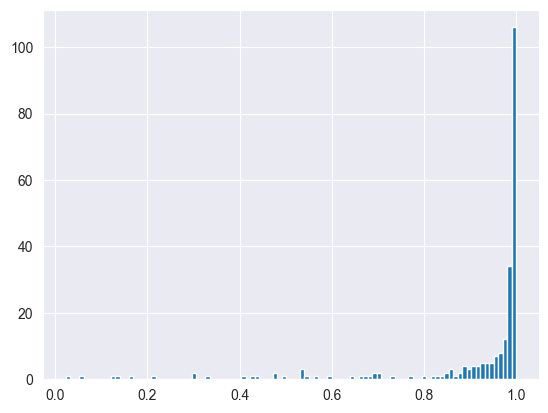

In [694]:
plt.hist(grouped["approval_rate"], bins=100)

In [695]:
grouped["approval_rate"].describe()

count    240.000000
mean       0.907207
std        0.188674
min        0.022556
25%        0.925507
50%        0.985436
75%        0.997767
max        1.000000
Name: approval_rate, dtype: float64

In [696]:
grouped["approval_rate"].describe()['mean']-0.5*grouped["approval_rate"].describe()['std']

0.8128697965953907

(array([125.,  25.,  18.,  14.,  12.,   4.,   5.,   6.,   1.,   1.,   4.,
          2.,   3.,   1.,   1.,   0.,   0.,   0.,   0.,   2.,   1.,   0.,
          3.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
        0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
        0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
        0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
        0.18 , 0.185, 0.19 , 0.195

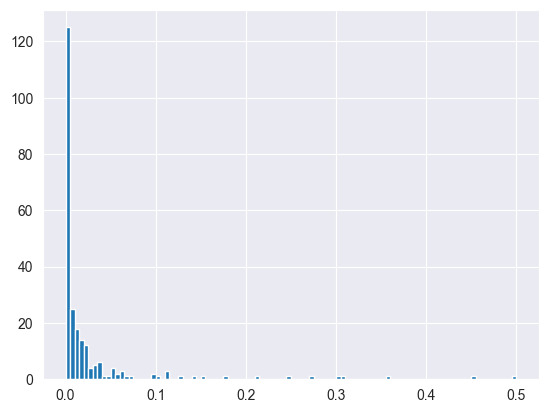

In [697]:
plt.hist(grouped["chargeback_rate"], bins=100)

In [698]:
grouped["chargeback_rate"].describe()

count    240.000000
mean       0.025508
std        0.065561
min        0.000000
25%        0.000000
50%        0.004133
75%        0.018913
max        0.500000
Name: chargeback_rate, dtype: float64

In [699]:
grouped["chargeback_rate"].describe()['mean']-0.2*grouped["chargeback_rate"].describe()['std']

0.012395854672528635

In [700]:
top5_segments_suboptimal_freq = declined_in_good_segments.sort_values("total_orders", ascending=False).head(5)

In [701]:
top5_segments_suboptimal_freq.approval_rate.mean(), top5_segments_suboptimal_freq.chargeback_rate.mean()

(0.37228904227928256, 0.000664451827242525)

/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_51231/1274266027.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


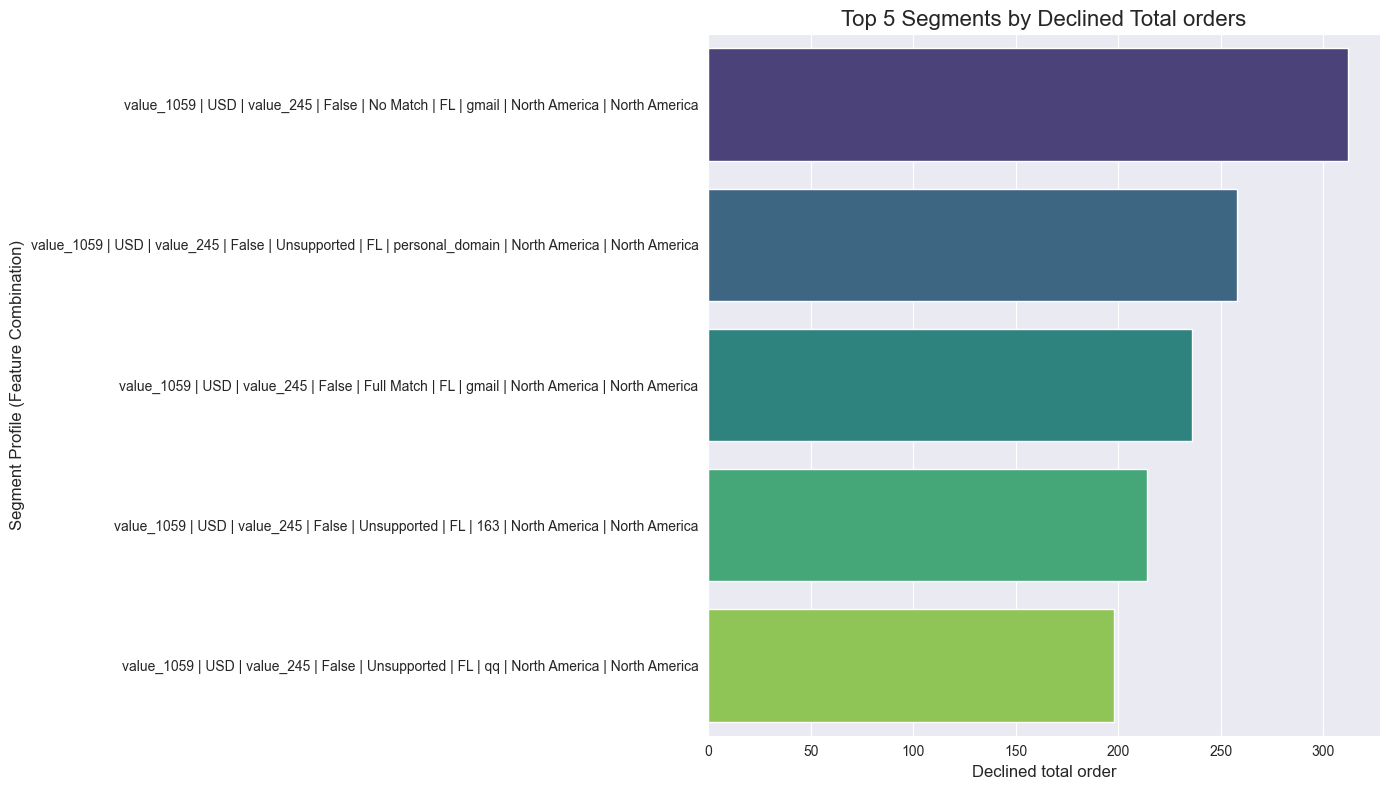

In [702]:
for col in top5_segments_suboptimal_freq.columns:
    if top5_segments_suboptimal_freq[col].dtype == 'bool':
        top5_segments_suboptimal_freq[col] = top5_segments_suboptimal_freq[col].astype(str)

# Create a new column to represent the profile as a single label
top5_segments_suboptimal_freq['profile'] = (
    top5_segments_suboptimal_freq['shipping_method'].astype(str) + " | " +
    top5_segments_suboptimal_freq['currency_code'].astype(str) + " | " +
    top5_segments_suboptimal_freq['gateway'].astype(str) + " | " +
    top5_segments_suboptimal_freq['V1_link'].astype(str) + " | " +
    top5_segments_suboptimal_freq['V6_avs_result'].astype(str) + " | " +
    top5_segments_suboptimal_freq['V7_bill_ship_name_match'].astype(str) + " | " +
    top5_segments_suboptimal_freq['email_domain'].astype(str) + " | " +
    top5_segments_suboptimal_freq['billing_region'].astype(str) + " | " +
    top5_segments_suboptimal_freq['shipping_region'].astype(str)
)

# Plot the bar chart
plt.figure(figsize=(14, 8))
sns.barplot(
    data=top5_segments_suboptimal_freq,
    x='total_orders',
    y='profile',
    palette='viridis'
)

# Add labels and title
plt.title('Top 5 Segments by Declined Total orders', fontsize=16)
plt.xlabel('Declined total order', fontsize=12)
plt.ylabel('Segment Profile (Feature Combination)', fontsize=12)
plt.tight_layout()
plt.savefig('top5_segments_declined_count_rate_thresholds.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [703]:
top_segments_suboptimal_cost = declined_in_good_segments.sort_values("total_transaction_value", ascending=False).head(5)

In [704]:
top_segments_suboptimal_cost.total_transaction_value.sum()

359407.58

In [705]:
top_segments_suboptimal_cost.columns

Index(['shipping_method', 'currency_code', 'gateway', 'V1_link',
       'V6_avs_result', 'V7_bill_ship_name_match', 'email_domain',
       'billing_region', 'shipping_region', 'total_orders',
       'total_transaction_value', 'approval_rate', 'chargeback_rate'],
      dtype='object')

/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_51231/36311218.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


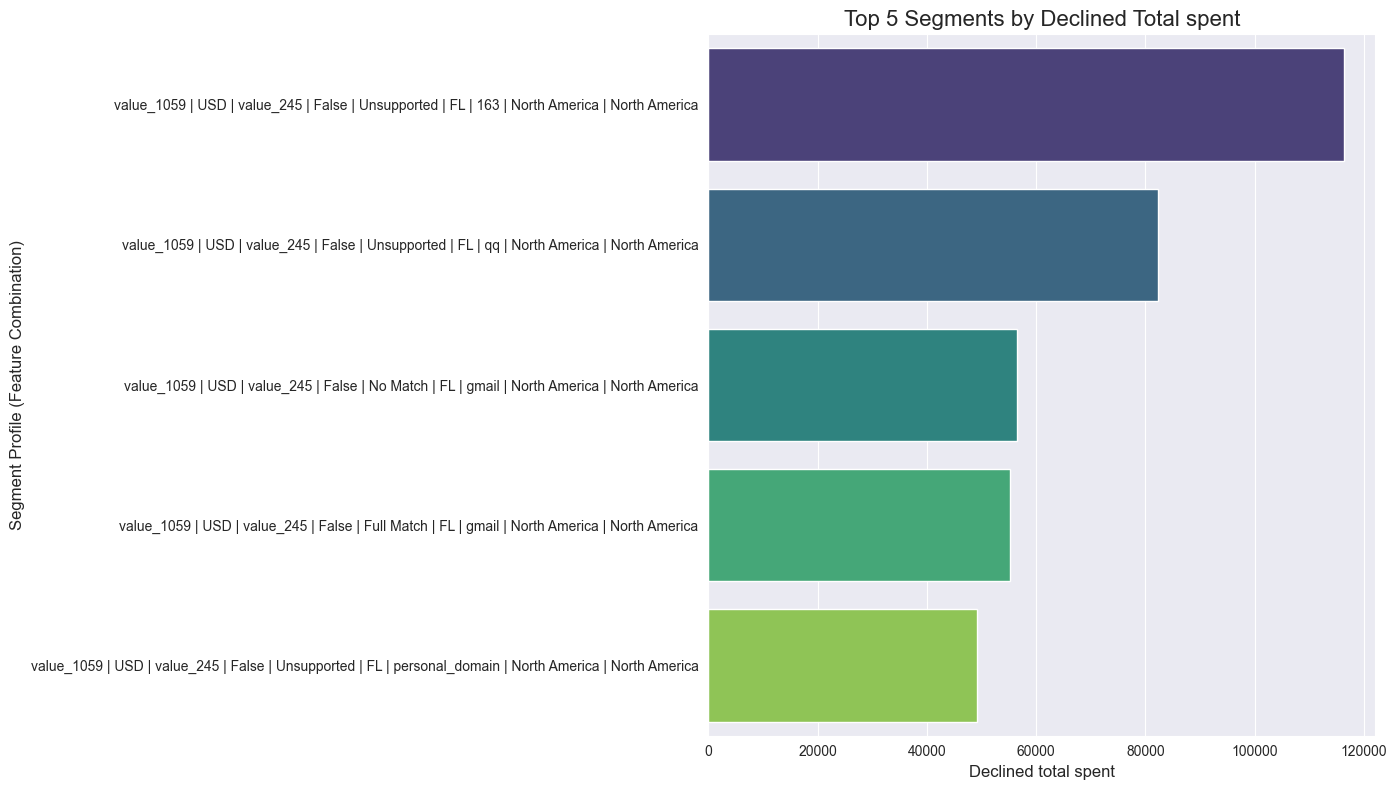

In [706]:
for col in top_segments_suboptimal_cost.columns:
    if top_segments_suboptimal_cost[col].dtype == 'bool':
        top_segments_suboptimal_cost[col] = top_segments_suboptimal_cost[col].astype(str)

# Create a new column to represent the profile as a single label
top_segments_suboptimal_cost['profile'] = (
    top_segments_suboptimal_cost['shipping_method'].astype(str) + " | " +
    top_segments_suboptimal_cost['currency_code'].astype(str) + " | " +
    top_segments_suboptimal_cost['gateway'].astype(str) + " | " +
    top_segments_suboptimal_cost['V1_link'].astype(str) + " | " +
    top_segments_suboptimal_cost['V6_avs_result'].astype(str) + " | " +
    top_segments_suboptimal_cost['V7_bill_ship_name_match'].astype(str) + " | " +
    top_segments_suboptimal_cost['email_domain'].astype(str) + " | " +
    top_segments_suboptimal_cost['billing_region'].astype(str) + " | " +
    top_segments_suboptimal_cost['shipping_region'].astype(str)
)

# Plot the bar chart
plt.figure(figsize=(14, 8))
sns.barplot(
    data=top_segments_suboptimal_cost,
    x='total_transaction_value',
    y='profile',
    palette='viridis'
)

# Add labels and title
plt.title('Top 5 Segments by Declined Total spent', fontsize=16)
plt.xlabel('Declined total spent', fontsize=12)
plt.ylabel('Segment Profile (Feature Combination)', fontsize=12)
plt.tight_layout()
plt.savefig('top5_segments_declined_spent_rate_threshold.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# 2. Train a predictive model. Based on this model, prepare a short report to send to the sales team explaining the expected performance of the model. The sales team requests an approval rate of 90%

In [403]:
df_model = df[df.status != 'declined']
df_model['label'] = np.where(df_model['status']=='approved',1,0)

/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_51231/1852453588.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['label'] = np.where(df_model['status']=='approved',1,0)


In [404]:
df_model.head()

,order_id,status,email_anoni,billing_country_code,shipping_country_code,shipping_method,created_at,total_spent,currency_code,gateway,...,is_weekend,billing_country_clean,shipping_country_clean,total_spent_USD,billing_region,shipping_region,V2_V3_interaction,is_approved_or_cb,is_chargeback,label
0,176079577,approved,shRbsUOPGM@qq.com,CA,CA,value_1620,2017-04-06,758.471274,CAD,value_100,...,False,CA,CA,568.853455,North America,North America,NaN,1,0,1
1,201560820,approved,hEjasTK8Vpq6sR@gmail.com,IT,IT,value_1639,2017-06-16,48.319175,EUR,value_169,...,False,IT,IT,53.151092,Europe,Europe,4.0,1,0,1
2,164072492,approved,KOWpxkDYDF@gmail.com,BE,BE,value_244,2017-03-01,1123.094534,EUR,value_151,...,False,BE,BE,1235.403987,Europe,Europe,9844.0,1,0,1
3,174595495,approved,hKOMNS3@me.com,CH,CH,value_1879,2017-04-02,12.530000,USD,value_247,...,True,CH,CH,12.530000,Europe,Europe,1.0,1,0,1
4,213517818,approved,PrP6SYm5Q5nMs1tj@hotmail.com,HK,HK,value_291,2017-07-11,480.000000,USD,value_148,...,False,HK,HK,480.000000,Asia,Asia,1.0,1,0,1


In [405]:
df_model.columns

Index(['order_id', 'status', 'email_anoni', 'billing_country_code',
       'shipping_country_code', 'shipping_method', 'created_at', 'total_spent',
       'currency_code', 'gateway', 'V1_link', 'V4_our_age', 'V5_merchant_age',
       'V6_avs_result', 'V7_bill_ship_name_match', 'V8_ip', 'V9_cookie',
       'V10_cookie', 'V11_cookie', 'email_domain', 'year', 'month', 'season',
       'day_of_week', 'is_weekend', 'billing_country_clean',
       'shipping_country_clean', 'total_spent_USD', 'billing_region',
       'shipping_region', 'V2_V3_interaction', 'is_approved_or_cb',
       'is_chargeback', 'label'],
      dtype='object')

From the EDA above we can clearly see that the setting is non linear, so I will be using Catboost as my baseline, with all the features. The reason why I chose to use catboost:
- handles categorical variables
- handles missing values
- robust to outliers and skewed features
- trees don't need scaling of numerical features
- it's robust to correlated features, but correlated features V2 and V3 were addressed before and were replaced by their interaction term.

In addition I will drop the outliers identified during EDA and perform hyperparameter tuning.

In [406]:
baseline_columns = ['shipping_method',
       'currency_code', 'gateway', 'V1_link', 'V4_our_age', 'V5_merchant_age',
         'V6_avs_result',
       'V7_bill_ship_name_match', 'V8_ip', 'V9_cookie', 'V10_cookie',
       'V11_cookie', 'email_domain','year','month','season','day_of_week','is_weekend', 'billing_country_clean',
       'shipping_country_clean', 'total_spent_USD', 'billing_region', 'shipping_region', 'V2_V3_interaction',
    'label']

baseline_columns_top10 = ['total_spent_USD', 'gateway', 'V10_cookie', 'V2_V3_interaction',
       'V5_merchant_age', 'V4_our_age', 'shipping_method', 'V11_cookie',
       'email_domain', 'V6_avs_result','label']

In [407]:
df_model.drop_duplicates()['label'].value_counts()/df_model.drop_duplicates()['label'].value_counts().sum()

label
1    0.973182
0    0.026818
Name: count, dtype: float64

In [408]:
categorical_columns = [
    'shipping_method', 'currency_code', 'gateway', 'V1_link', 'V6_avs_result',
    'V7_bill_ship_name_match', 'email_domain', 'year','month','season','day_of_week','is_weekend',
    'billing_country_clean', 'shipping_country_clean', 'billing_region', 'shipping_region'
]

categorical_columns_top10 = [
    'shipping_method', 'gateway', 'V6_avs_result',
 'email_domain']

# Split into train-dev-test sets
target_column = 'label'
data = df_model[baseline_columns]

# Convert categorical columns and NaN values to strings
for col in categorical_columns:
    data[col] = data[col].astype(str)


# split needs to be stratified by y and consequential by  time
train_dev_data, test_data = train_test_split(data, test_size=0.03, random_state=42, stratify=data[target_column])
train_data, dev_data = train_test_split(train_dev_data, test_size=0.2, random_state=42, stratify=train_dev_data[target_column])

/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_51231/1045074807.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].astype(str)
/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_51231/1045074807.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].astype(str)
/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_51231/1045074807.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Leakage check and repeated order_ids

In [409]:
# Find common rows (inner join on columns A and B by default)
common_rows_train_dev = pd.merge(train_data, dev_data, how='inner')
common_rows_train_dev

,shipping_method,currency_code,gateway,V1_link,V4_our_age,V5_merchant_age,V6_avs_result,V7_bill_ship_name_match,V8_ip,V9_cookie,...,season,day_of_week,is_weekend,billing_country_clean,shipping_country_clean,total_spent_USD,billing_region,shipping_region,V2_V3_interaction,label
0,value_1059,USD,value_245,False,731.0,587.0,Unsupported,FL,0.0,625.0,...,Spring,Wednesday,False,US,US,219.000000,North America,North America,159138225.0,0
1,value_1794,USD,value_65,False,0.0,2.0,Unsupported,FL,0.0,2.0,...,Spring,Thursday,False,AU,AU,276.640000,Oceania,Oceania,1521.0,0
2,nan,BRL,value_4,False,0.0,115.0,Unsupported,FL,0.0,1.0,...,Spring,Monday,False,BR,BR,52.945405,South America,South America,196.0,0
3,value_1301,BRL,value_4,False,856.0,0.0,Unsupported,FL,0.0,6.0,...,Spring,Sunday,True,BR,BR,105.074166,South America,South America,100.0,0
4,value_1645,USD,value_65,False,62.0,57.0,Zip Match,NO_MATCH,0.0,0.0,...,Spring,Friday,False,US,US,148.000000,North America,North America,330.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,value_1165,ILS,value_64,True,1485.0,1.0,Missing,FL,0.0,0.0,...,Winter,Wednesday,False,IL,IL,1.801108,Middle East,Middle East,0.0,0
314,nan,BRL,value_4,False,1101.0,0.0,Unsupported,FL,0.0,1.0,...,Spring,Monday,False,BR,BR,118.197000,South America,South America,9.0,0
315,value_1645,USD,value_169,False,0.0,0.0,Missing,FL,0.0,0.0,...,Summer,Monday,False,US,US,48.000000,North America,North America,25.0,1
316,nan,BRL,value_4,False,2595.0,0.0,Unsupported,FL,0.0,1.0,...,Spring,Tuesday,False,BR,BR,77.601476,South America,South America,NaN,0


In [410]:
common_rows_train_test = pd.merge(train_data, test_data, how='inner')
common_rows_train_test

,shipping_method,currency_code,gateway,V1_link,V4_our_age,V5_merchant_age,V6_avs_result,V7_bill_ship_name_match,V8_ip,V9_cookie,...,season,day_of_week,is_weekend,billing_country_clean,shipping_country_clean,total_spent_USD,billing_region,shipping_region,V2_V3_interaction,label
0,value_291,USD,value_181,False,298.0,383.0,Full Match,FL,0.0,29.0,...,Summer,Wednesday,False,US,US,220.000000,North America,North America,71385601.0,1
1,nan,BRL,value_4,False,2184.0,0.0,Unsupported,FL,0.0,3.0,...,Spring,Thursday,False,BR,BR,68.536345,South America,South America,100.0,0
2,value_1059,USD,value_136,False,385.0,0.0,Zip Match,FL,0.0,0.0,...,Spring,Friday,False,US,US,432.730000,North America,North America,25.0,0
3,value_522,USD,value_65,False,0.0,0.0,Full Match,FL,0.0,0.0,...,Winter,Friday,False,CA,CA,82.200000,North America,North America,5537.0,0
4,value_1165,ILS,value_64,False,2008.0,252.0,Missing,FL,0.0,0.0,...,Winter,Thursday,False,PL,PL,1.802887,Europe,Europe,NaN,0
5,value_1165,ILS,value_64,False,2008.0,252.0,Missing,FL,0.0,0.0,...,Winter,Thursday,False,PL,PL,1.802887,Europe,Europe,NaN,0
6,value_1794,USD,value_65,False,3386.0,1.0,Unsupported,FL,0.0,919.0,...,Summer,Wednesday,False,US,US,203.950000,North America,North America,1.0,0
7,value_483,USD,value_196,False,0.0,5.0,Missing,FL,0.0,0.0,...,Spring,Friday,False,PE,PE,100.000000,South America,South America,49.0,0
8,nan,BRL,value_4,False,9.0,0.0,Unsupported,FL,0.0,1.0,...,Spring,Friday,False,BR,BR,466.980178,South America,South America,3364.0,0
9,value_2339,USD,value_181,False,1223.0,1708.0,Unsupported,FL,0.0,128.0,...,Fall,Saturday,True,SA,US,2420.000000,Middle East,North America,0.0,1


In [411]:
common_rows_dev_test = pd.merge(dev_data, test_data, how='inner')
common_rows_dev_test

,shipping_method,currency_code,gateway,V1_link,V4_our_age,V5_merchant_age,V6_avs_result,V7_bill_ship_name_match,V8_ip,V9_cookie,...,season,day_of_week,is_weekend,billing_country_clean,shipping_country_clean,total_spent_USD,billing_region,shipping_region,V2_V3_interaction,label
0,value_2132,EUR,value_21,False,2467.0,1.0,Unsupported,FL,0.0,4.0,...,Spring,Sunday,True,IT,IT,48.079887,Europe,Europe,2809.0,0
1,value_1301,GBP,value_4,False,0.0,0.0,Full Match,FL,0.0,1.0,...,Spring,Saturday,True,GB,GB,205.035385,Europe,Europe,225.0,0
2,value_1692,USD,value_201,False,0.0,112.0,Unsupported,NO_MATCH,0.0,9.0,...,Fall,Thursday,False,FR,FR,265.000000,Europe,Europe,529.0,1
3,value_291,JPY,value_181,False,0.0,0.0,Unsupported,FL,0.0,0.0,...,Spring,Friday,False,JP,JP,1.497208,Asia,Asia,NaN,0
4,value_1301,BRL,value_4,False,653.0,0.0,Unsupported,FL,0.0,2.0,...,Spring,Sunday,True,BR,BR,207.360455,South America,South America,16.0,0
5,value_522,USD,value_65,False,0.0,0.0,Full Match,FL,0.0,0.0,...,Spring,Sunday,True,US,US,298.000000,North America,North America,5928.0,0
6,nan,BRL,value_4,False,2080.0,0.0,Unsupported,FL,0.0,1.0,...,Spring,Sunday,True,BR,BR,72.126968,South America,South America,16.0,0
7,value_2337,USD,value_181,False,0.0,12.0,Address Match,FL,0.0,1958.0,...,Spring,Friday,False,US,CN,1155.000000,North America,Asia,23346.0,0
8,value_1692,USD,value_201,False,634.0,305.0,Zip Match,NO_MATCH,0.0,0.0,...,Fall,Wednesday,False,KR,US,785.000000,Asia,North America,NaN,0
9,nan,BRL,value_4,False,864.0,0.0,Unsupported,FL,0.0,1.0,...,Spring,Friday,False,BR,BR,310.849507,South America,South America,441.0,0


In [412]:
df_model.shape, train_data.shape, dev_data.shape, test_data.shape

((170000, 34), (131920, 25), (32980, 25), (5100, 25))

318 out of 131,920 (Train) is about 0.24%.
46 out of 131,920 (Train) is about 0.035%.
11 out of 32,980 (Dev) is about 0.033%.
These overlaps are extremely small compared to your total data.

Should you drop these overlapping rows?

Option A: Remove from Dev or Test.
Typically, you want to keep your Train set as large as possible for better model training.
You could remove duplicates from Dev and Test so that the model cannot “peek” at data it was trained on. This ensures your Dev/Test metrics remain unbiased.
Option B: Remove from Train.
Another approach is to remove the duplicates from the Train set so that your Dev and Test sets remain exactly as collected. However, this reduces your training data slightly.
Given that the overlap is tiny, either approach will have minimal impact on the overall dataset. Practically, people often remove from the Dev/Test sets to avoid biased model evaluation.

What if the model needs to work in real-time?

In real-world (real-time) applications, you often encounter data that “looks like” or exactly matches data that was used in training. This is not necessarily wrong—it just reflects reality.
The key question is: Do you want your validation metrics to remain “pure”? If so, ensure Dev and Test are unique.
It’s fine in real-time scenarios to have new data points that happen to be repeats or near-duplicates of training data. What matters is that your Dev/Test sets give you a realistic estimate of performance on new data.
Conclusion

The overlaps are very small. They’re unlikely to drastically affect your model’s metrics.
For best practice in research or performance reporting, remove the duplicate rows from either Dev or Test (so that these rows appear only in the Train set). This way, your validation metrics remain as unbiased as possible.
If for some reason you must preserve Dev and Test data exactly as-is (e.g., a time-split scenario), you could drop them from the Train set instead. But usually the simplest approach is to remove them from the smaller Dev/Test sets.

In [413]:
# drop duplicates from dev and test set
# Convert each 'common' DataFrame to a set of row tuples
train_dev_tuples  = set(tuple(row) for row in common_rows_train_dev.to_numpy())
train_test_tuples = set(tuple(row) for row in common_rows_train_test.to_numpy())
dev_test_tuples   = set(tuple(row) for row in common_rows_dev_test.to_numpy())

# A small helper function to convert a row to a tuple
def row_to_tuple(r):
    return tuple(r)

# Drop duplicates from dev_data
dev_data = dev_data[~dev_data.apply(row_to_tuple, axis=1).isin(train_dev_tuples)]
dev_data = dev_data[~dev_data.apply(row_to_tuple, axis=1).isin(dev_test_tuples)]

# Drop duplicates from test_data
test_data = test_data[~test_data.apply(row_to_tuple, axis=1).isin(train_test_tuples)]
test_data = test_data[~test_data.apply(row_to_tuple, axis=1).isin(dev_test_tuples)]


In [414]:
# Find common rows (inner join on columns A and B by default)
common_rows_train_dev = pd.merge(train_data, dev_data, how='inner')
common_rows_train_dev

,shipping_method,currency_code,gateway,V1_link,V4_our_age,V5_merchant_age,V6_avs_result,V7_bill_ship_name_match,V8_ip,V9_cookie,...,season,day_of_week,is_weekend,billing_country_clean,shipping_country_clean,total_spent_USD,billing_region,shipping_region,V2_V3_interaction,label


In [415]:
common_rows_train_test = pd.merge(train_data, test_data, how='inner')
common_rows_train_test

,shipping_method,currency_code,gateway,V1_link,V4_our_age,V5_merchant_age,V6_avs_result,V7_bill_ship_name_match,V8_ip,V9_cookie,...,season,day_of_week,is_weekend,billing_country_clean,shipping_country_clean,total_spent_USD,billing_region,shipping_region,V2_V3_interaction,label


In [416]:
common_rows_dev_test = pd.merge(dev_data, test_data, how='inner')
common_rows_dev_test

,shipping_method,currency_code,gateway,V1_link,V4_our_age,V5_merchant_age,V6_avs_result,V7_bill_ship_name_match,V8_ip,V9_cookie,...,season,day_of_week,is_weekend,billing_country_clean,shipping_country_clean,total_spent_USD,billing_region,shipping_region,V2_V3_interaction,label


In [417]:
df_model.shape, train_data.shape, dev_data.shape, test_data.shape

((170000, 34), (131920, 25), (32660, 25), (5046, 25))

In [418]:
# Separate features and target
X_train, y_train = train_data.drop(columns=[target_column]), train_data[target_column]
X_dev, y_dev = dev_data.drop(columns=[target_column]), dev_data[target_column]
X_test, y_test = test_data.drop(columns=[target_column]), test_data[target_column]

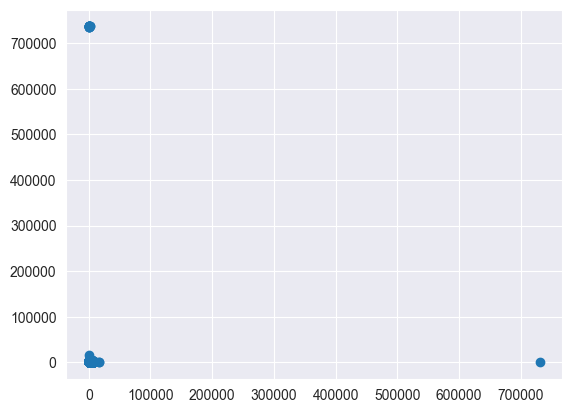

In [419]:
# check outliers on train
plt.scatter(X_train['V4_our_age'], X_train['V5_merchant_age'])
plt.show()

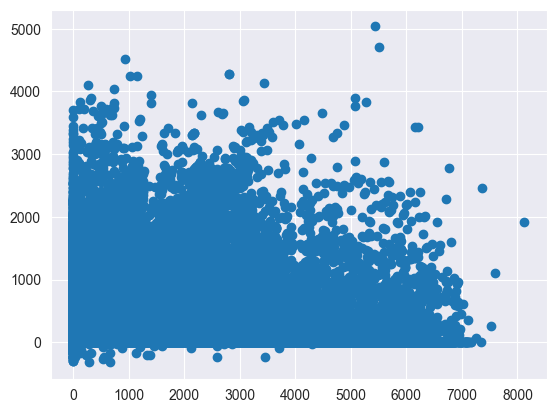

In [420]:
# check outliers on train
plt.scatter(X_train[(X_train['V4_our_age']<15000) & (X_train['V5_merchant_age']<15000)]['V4_our_age'], X_train[(X_train['V4_our_age']<15000) & (X_train['V5_merchant_age']<15000)]['V5_merchant_age'])
plt.show()

In [421]:
# apply outlier on train and dev
X_train = X_train[(X_train['V4_our_age']<15000) & (X_train['V5_merchant_age']<15000)]
X_dev = X_dev[(X_dev['V4_our_age']<15000) & (X_dev['V5_merchant_age']<15000)]
y_train = y_train[y_train.index.isin(X_train.index)]
y_dev = y_dev[y_dev.index.isin(X_dev.index)]

In [422]:
X_train.head()

,shipping_method,currency_code,gateway,V1_link,V4_our_age,V5_merchant_age,V6_avs_result,V7_bill_ship_name_match,V8_ip,V9_cookie,...,month,season,day_of_week,is_weekend,billing_country_clean,shipping_country_clean,total_spent_USD,billing_region,shipping_region,V2_V3_interaction
86460,value_291,USD,value_172,False,1249.0,1107.0,Missing,F,0.0,1100.0,...,6,Summer,Saturday,True,TW,TW,805.000000,Asia,Asia,36.0
144467,value_2132,EUR,value_21,False,0.0,1.0,Unsupported,NO_MATCH,0.0,13.0,...,11,Fall,Monday,False,FR,FR,167.876636,Europe,Europe,1755.0
59261,value_1609,GBP,value_4,False,5015.0,1622.0,Missing,FL,0.0,145.0,...,5,Spring,Sunday,True,GB,GB,101.843405,Europe,Europe,84.0
110167,value_1938,USD,value_21,False,0.0,1.0,Full Match,FL,0.0,15.0,...,6,Summer,Thursday,False,CA,CA,183.000000,North America,North America,49.0
122745,value_1645,USD,value_65,False,0.0,0.0,Full Match,FL,1.8,0.0,...,5,Spring,Saturday,True,US,US,44.200000,North America,North America,NaN


In [423]:
X_train.columns

Index(['shipping_method', 'currency_code', 'gateway', 'V1_link', 'V4_our_age',
       'V5_merchant_age', 'V6_avs_result', 'V7_bill_ship_name_match', 'V8_ip',
       'V9_cookie', 'V10_cookie', 'V11_cookie', 'email_domain', 'year',
       'month', 'season', 'day_of_week', 'is_weekend', 'billing_country_clean',
       'shipping_country_clean', 'total_spent_USD', 'billing_region',
       'shipping_region', 'V2_V3_interaction'],
      dtype='object')

In [424]:
correlation = pd.DataFrame(X_train[['V4_our_age', 'V5_merchant_age', 'V8_ip', 'V9_cookie', 'V10_cookie', 'V11_cookie', 'total_spent_USD', 'V2_V3_interaction']]).corrwith(pd.Series(y_train))
print(correlation)

V4_our_age          -0.019694
V5_merchant_age      0.044705
V8_ip               -0.029651
V9_cookie            0.001651
V10_cookie          -0.177541
V11_cookie           0.060760
total_spent_USD     -0.046689
V2_V3_interaction   -0.008966
dtype: float64


The fact that the correlations are this low but total_spent_USD, V10_cookie, V2_V3_interaction, V5_merchant_age, V4_our_age, V11_cookie are in the top 10 most important features - confirms that the setting is not linear!

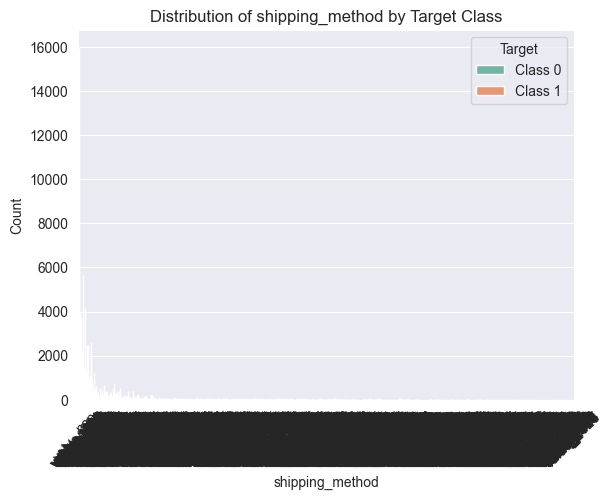

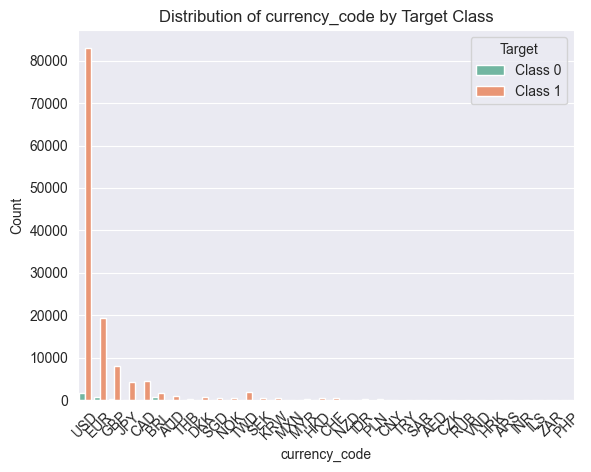

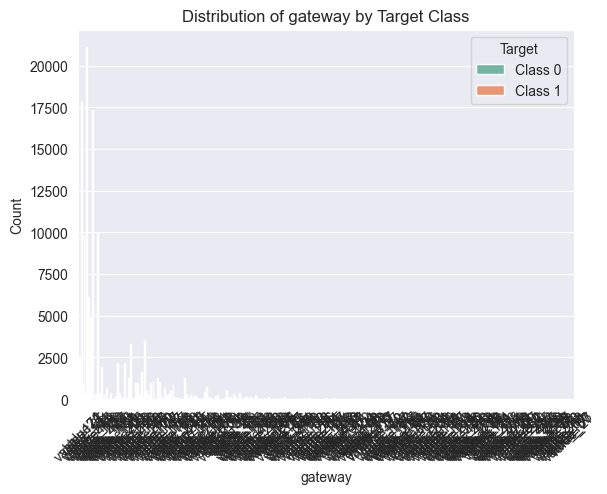

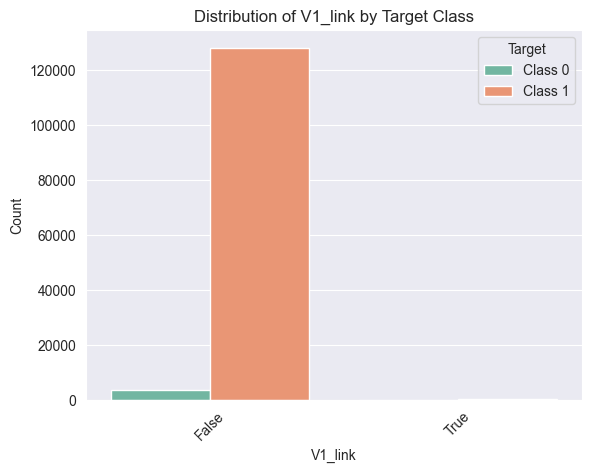

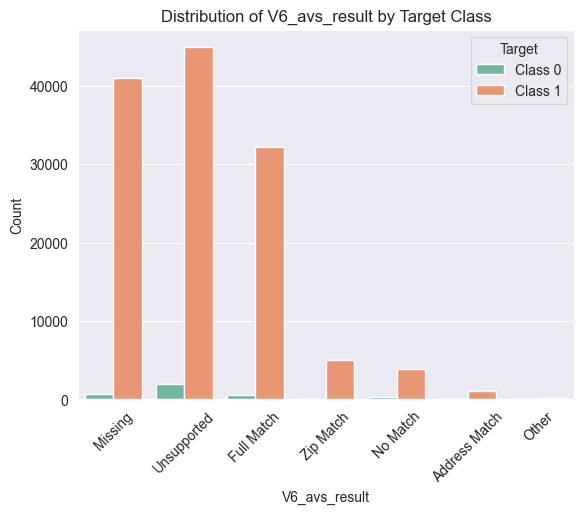

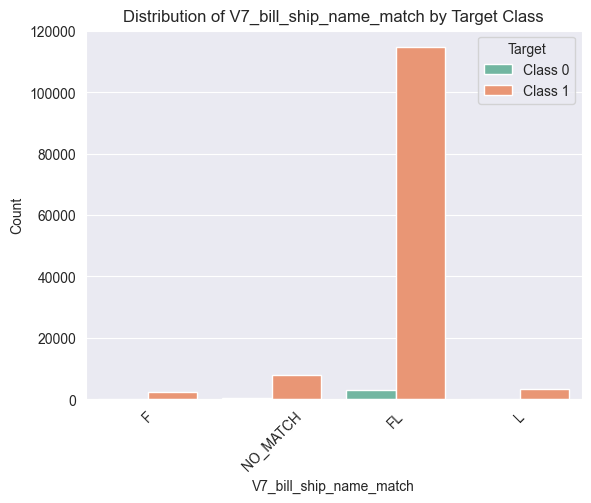

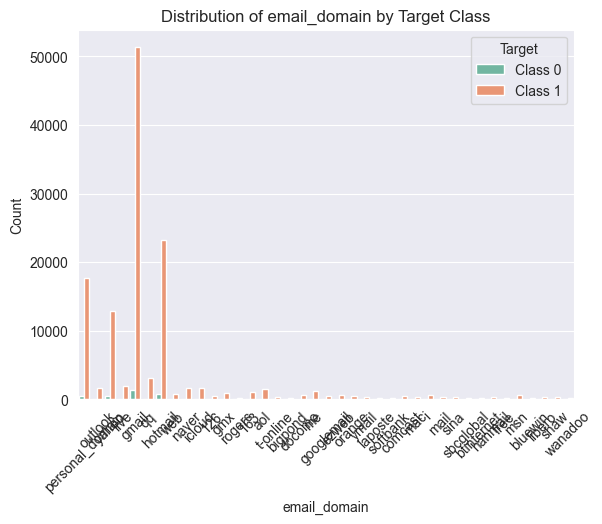

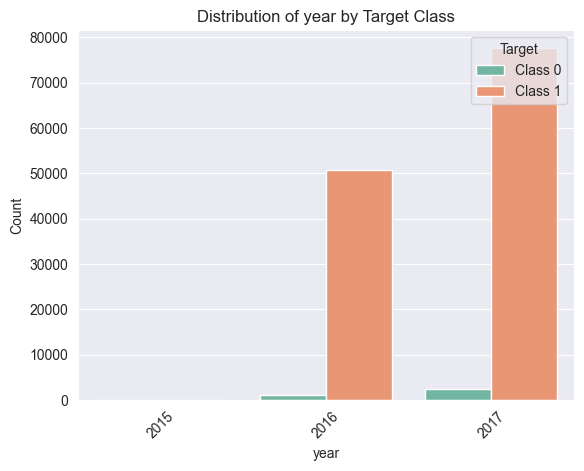

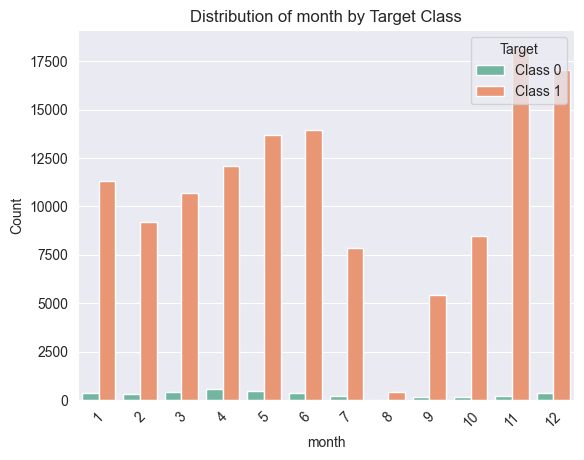

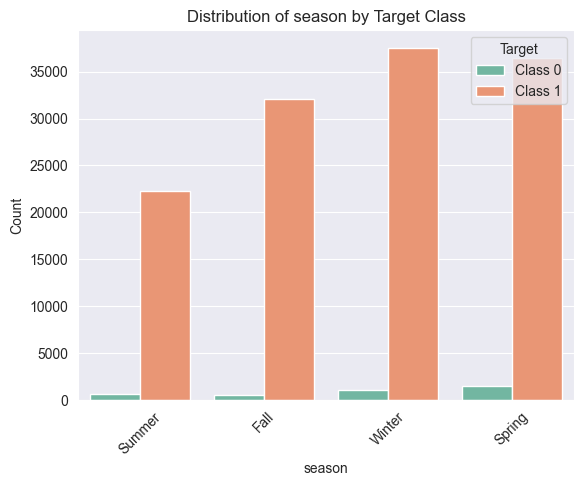

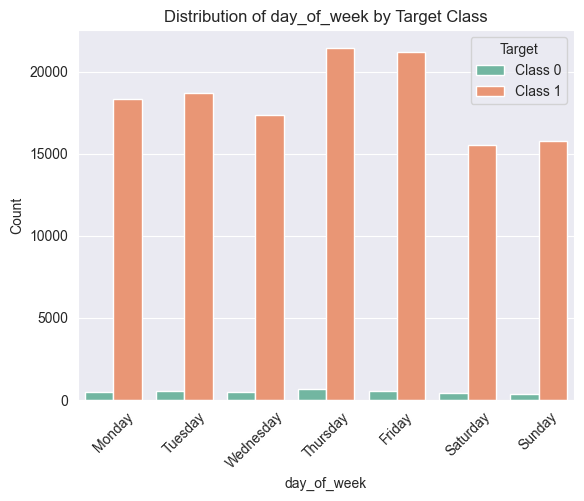

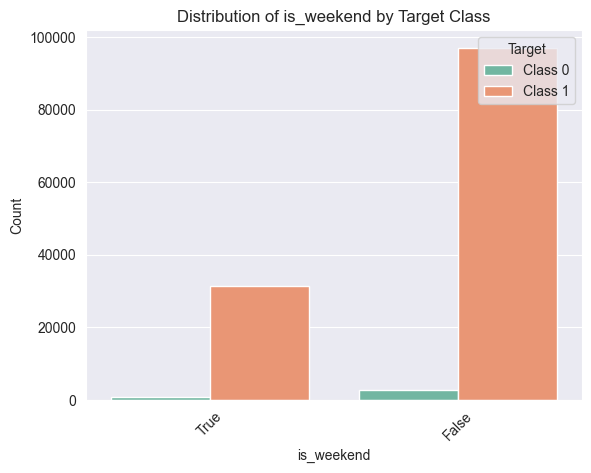

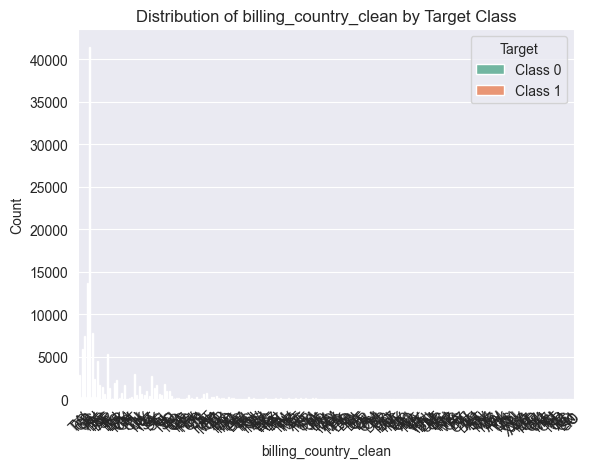

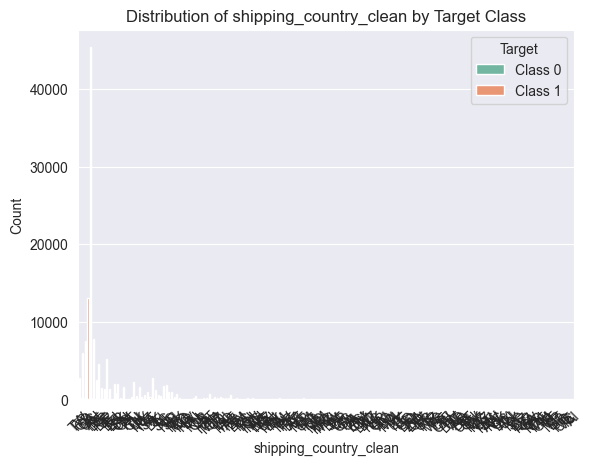

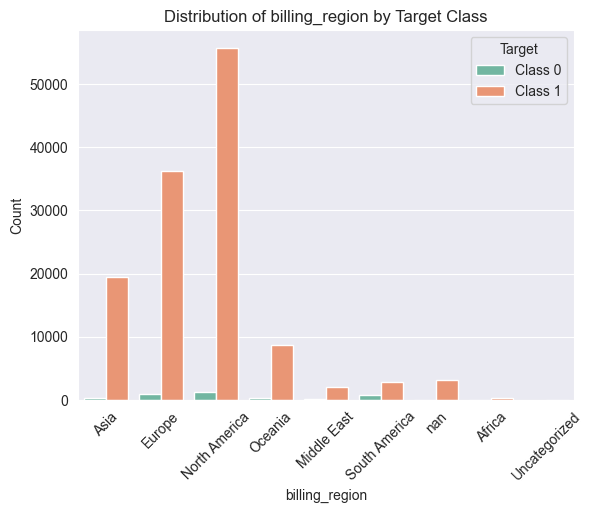

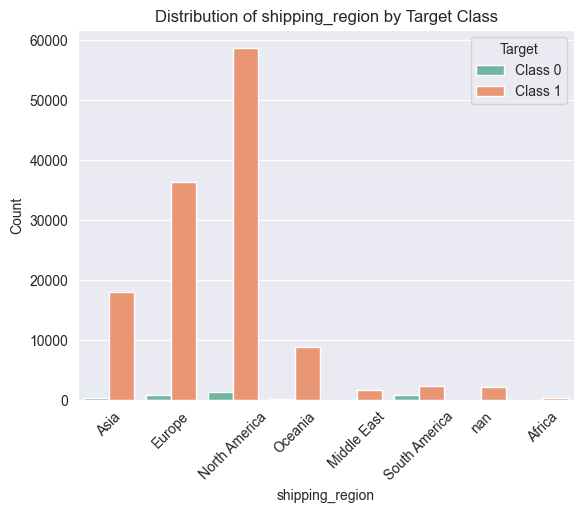

In [716]:

cat_order = {
    'year': [2015, 2016, 2017],
    'month': list(range(1, 13)),  # [1..12]
    'season': ['Summer', 'Fall', 'Winter', 'Spring'],
    'day_of_week': ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
}

categorical_features = [
    'shipping_method', 'currency_code', 'gateway', 'V1_link', 'V6_avs_result',
    'V7_bill_ship_name_match', 'email_domain', 'year', 'month', 'season',
    'day_of_week', 'is_weekend', 'billing_country_clean', 'shipping_country_clean',
    'billing_region', 'shipping_region'
]

for feature in categorical_features:
    # If this feature has a custom order, use it; otherwise pass None
    order = cat_order.get(feature, None)

    sns.countplot(
        data=X_train,
        x=feature,
        hue=y_train,
        palette='Set2',
        order=order
    )

    plt.title(f'Distribution of {feature} by Target Class')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='Target', loc='upper right', labels=['Class 0', 'Class 1'])
    plt.xticks(rotation=45)
    plt.show()

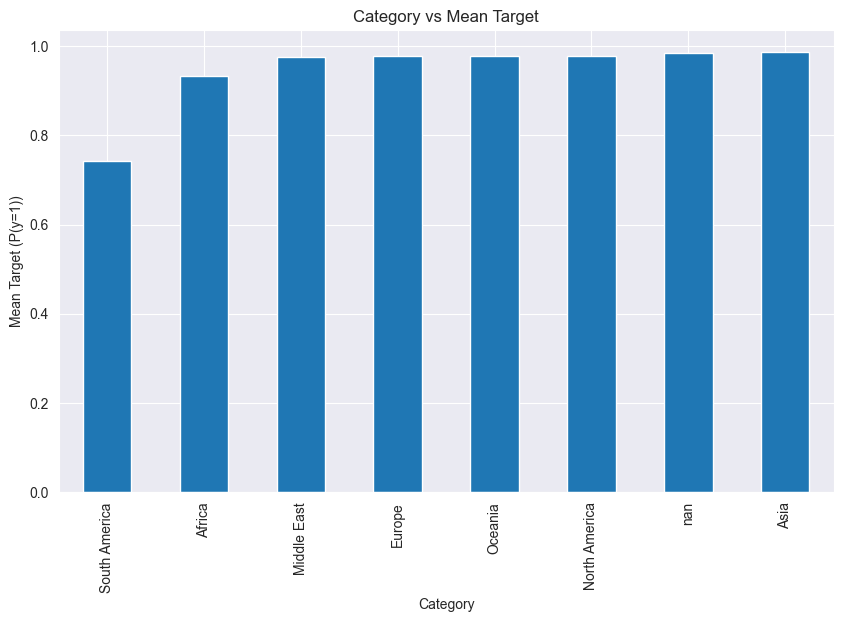

In [426]:
# Example for one categorical variable
category_target_mean = train_data[['shipping_method', 'currency_code', 'gateway', 'V1_link', 'V6_avs_result', 'V7_bill_ship_name_match', 'email_domain', 'year', 'month', 'season', 'day_of_week', 'is_weekend', 'billing_country_clean', 'shipping_country_clean', 'billing_region', 'shipping_region','label']].groupby('shipping_region')['label'].mean()
category_target_mean.sort_values().plot(kind='bar', figsize=(10, 6), title='Category vs Mean Target')
plt.ylabel('Mean Target (P(y=1))')
plt.xlabel('Category')
plt.show()

Linear Setting: The target means vary monotonically or follow a clear trend.
Example: As a category changes (e.g., Education: High School → Bachelor’s → Master’s), the probability of y=1 systematically increases or decreases.

Non-Linear Setting: No clear or monotonic relationship exists. Some categories might show irregular probabilities for y=1, or certain categories dominate the minority class.

The overall setting appears to be non-linear. Here's why:
- There is significant overlap between Class 0 and Class 1 in many features, such as month, season, day_of_week, and email_domain.
- Certain categories dominate the target variable (e.g., FL in V7_bill_ship_name_match), indicating that linear decision boundaries will struggle to separate the classes.
- The distributions are irregular, and no simple trends (e.g., monotonic increase/decrease in Class 1 proportions) are consistently observed.

In [427]:
# Initialize CatBoost Classifier
model = CatBoostClassifier(eval_metric='Recall', cat_features=categorical_columns, verbose=100)
# Train the model
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_dev, y_dev)], early_stopping_rounds=50)

Learning rate set to 0.10583
0:	learn: 1.0000000	test: 1.0000000	test1: 1.0000000	best: 1.0000000 (0)	total: 181ms	remaining: 3m
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1
bestIteration = 0

Shrink model to first 1 iterations.


the metric on the holdout set worsened (or didn’t improve), and the early-stopping mechanism cut off training. Essentially, the model never really “learned” and ended up with an over-simplistic solution (e.g. always predicting one class). no tuning class imbalance.

In [428]:
# Define the parameter grid
param_grid = {
    'eval_metric':['Recall'],
    'iterations': [500, 1000],
    'learning_rate': [0.05, 0.07, 0.1],
    'depth': [6, 8],
    'class_weights': [
        [1, len(y_train[y_train == 0]) / len(y_train[y_train == 1])], #treating class imbalance: first weight is for 0 (minority), second weight is for 1 (majority)
        None
    ],
    'random_state':[42],
    'verbose':[100]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=CatBoostClassifier(cat_features=categorical_columns),
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter combinations to try
    scoring='recall',  # Metric to optimize
    cv=3,  # 3-fold cross-validation
    random_state=42,
    n_jobs=-1  # Use all available processors
)

# Fit RandomizedSearchCV on the development set
random_search.fit(X_dev, y_dev)

# Get the best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Recall Score:", random_search.best_score_)

/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
36 fits failed out of a total of 72.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-p

0:	learn: 0.7878041	total: 183ms	remaining: 3m 3s
100:	learn: 0.9740799	total: 5.52s	remaining: 49.1s
200:	learn: 0.9893013	total: 11.3s	remaining: 44.8s
300:	learn: 0.9954148	total: 16.6s	remaining: 38.6s
400:	learn: 0.9977854	total: 21.7s	remaining: 32.4s
500:	learn: 0.9990331	total: 26.7s	remaining: 26.6s
600:	learn: 0.9994386	total: 31.5s	remaining: 20.9s
700:	learn: 0.9996569	total: 36.2s	remaining: 15.4s
800:	learn: 0.9997193	total: 40.5s	remaining: 10.1s
900:	learn: 0.9997505	total: 44.8s	remaining: 4.92s
999:	learn: 0.9997817	total: 49s	remaining: 0us
Best Parameters: {'verbose': 100, 'random_state': 42, 'learning_rate': 0.1, 'iterations': 1000, 'eval_metric': 'Recall', 'depth': 8, 'class_weights': [1, 0.02755466918037129]}
Best Recall Score: 0.996101062449836


CatBoost got the chance to:

Properly explore multiple configurations of hyperparameters.
Learn longer (up to 1000 iterations) with a moderate learning rate, avoiding early, abrupt overfitting.
Handle class imbalance by weighting the minority class more heavily, preventing the model from ignoring it.
Validate each parameter set via cross-validation, ensuring the best combination truly generalizes in terms of Recall.

Key Interview Sound Bites
Overfitting Detector: “Initially, CatBoost’s early-stopping kicked in at iteration 0, indicating it saw no improvement for the recall metric in subsequent iterations. This sometimes happens with certain default parameters or if the data is imbalanced and the model lumps everything into one class, giving an apparent local optimum after the first iteration.”

Hyperparameter Tuning: “By systematically searching over learning rates, tree depths, and class weights (for the imbalanced classes), we allowed CatBoost to find a configuration that balances exploring the training set thoroughly while preventing overfitting.”

Class Weights: “Because of significant class imbalance, specifying class_weights was crucial to ensure the minority class was not overlooked.”

Cross-Validation: “Using CV in the RandomizedSearchCV guaranteed that the improvement we see in recall is consistent across multiple splits of the data, rather than an artifact of a single hold-out set.”

In [ ]:
# best_model_RS_top10 = random_search.best_estimator_

In [429]:
best_model_RS = random_search.best_estimator_
feature_importances = best_model_RS.get_feature_importance()
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance}")

shipping_method: 5.2558012264778124
currency_code: 2.3107945561834686
gateway: 9.79355111698194
V1_link: 0.0027527457049310567
V4_our_age: 6.763679494508384
V5_merchant_age: 6.84096705675863
V6_avs_result: 4.90708521091348
V7_bill_ship_name_match: 2.3806372311062876
V8_ip: 0.26021337615222423
V9_cookie: 3.7183439120917603
V10_cookie: 8.231385993965166
V11_cookie: 5.512136053210644
email_domain: 5.223129514172624
year: 1.2166832366757525
month: 4.1830496775603825
season: 3.3497827810428573
day_of_week: 3.302418943563634
is_weekend: 0.7450940432637666
billing_country_clean: 2.777238415432682
shipping_country_clean: 2.874895338494958
total_spent_USD: 10.074602982305024
billing_region: 2.138739842631699
shipping_region: 0.9042680681595447
V2_V3_interaction: 7.232749182642502


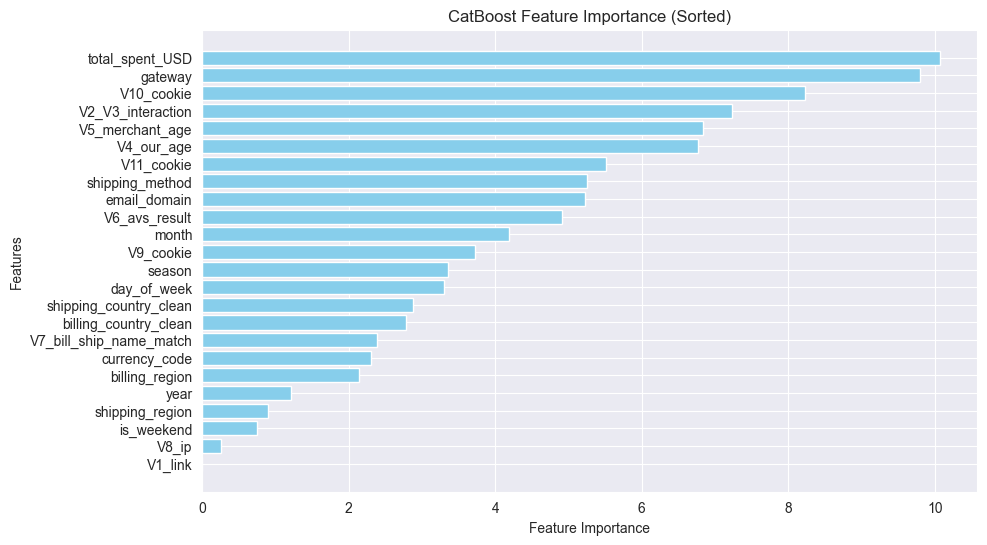

In [430]:
# Sort features and their importance values in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = X_train.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Plot the sorted feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('CatBoost Feature Importance (Sorted)')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.show()

In [431]:
sorted_features[:10]

Index(['total_spent_USD', 'gateway', 'V10_cookie', 'V2_V3_interaction',
       'V5_merchant_age', 'V4_our_age', 'V11_cookie', 'shipping_method',
       'email_domain', 'V6_avs_result'],
      dtype='object')

In [432]:
# Fit CatBoostClassifier

best_model_RS.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_dev, y_dev)], early_stopping_rounds=50)

0:	learn: 0.7794458	test: 0.7856625	test1: 0.7800998	best: 0.7800998 (0)	total: 302ms	remaining: 5m 1s
100:	learn: 0.9097170	test: 0.9113997	test1: 0.9028384	best: 0.9028384 (100)	total: 19.8s	remaining: 2m 56s
0:	learn: 0.7816974	total: 509ms	remaining: 4m 13s
100:	learn: 0.9395059	total: 20.3s	remaining: 1m 20s
200:	learn: 0.9667821	total: 41.3s	remaining: 1m 1s
300:	learn: 0.9775428	total: 1m 3s	remaining: 42s
400:	learn: 0.9833910	total: 1m 22s	remaining: 20.4s
499:	learn: 0.9882100	total: 1m 41s	remaining: 0us
0:	learn: 0.8434547	total: 291ms	remaining: 2m 25s
100:	learn: 0.9685599	total: 33s	remaining: 2m 10s
200:	learn: 0.9840460	total: 1m 3s	remaining: 1m 34s
300:	learn: 0.9922803	total: 1m 33s	remaining: 1m 2s
400:	learn: 0.9956021	total: 2m 9s	remaining: 32s
499:	learn: 0.9973332	total: 2m 43s	remaining: 0us
0:	learn: 0.8367099	total: 256ms	remaining: 2m 7s
100:	learn: 0.9831563	total: 39.6s	remaining: 2m 36s
200:	learn: 0.9957891	total: 1m 11s	remaining: 1m 46s
300:	learn: 0

In [729]:
dev_preds = best_model_RS.predict(X_dev)
dev_recall = recall_score(y_dev, dev_preds)
conf_matrix = confusion_matrix(y_dev, dev_preds)
tn, fp, fn, tp = conf_matrix.ravel()
dev_approval_rate = (tp+fp)/(tp+tn+fp+fn)
chargeback_rate_dev = fp/(tp+fp)
precision_dev = tp/(tp+fp)
f1_score_dev = 2 * (precision_dev * dev_recall) / (precision_dev + dev_recall)
true_negatives_dev = tn/(tn + fp)
# Display metrics
print("Dev Metrics:")
# print(f"  Negatives correctly classified: {true_negatives_test:.4f}")
# print(f"  Recall: {test_recall:.4f}")
# print(f"  Precision: {precision_test:.4f}")
print(f"  F1: {f1_score_test:.4f}")
print(f"  Approval Rate: {dev_approval_rate:.4f}")
# print(f"  Chargeback Rate: {chargeback_rate_test:.4f}")

Dev Metrics:
  F1: 0.9920
  Approval Rate: 0.9632


In [730]:
test_preds = best_model_RS.predict(X_test)
test_recall = recall_score(y_test, test_preds)
conf_matrix = confusion_matrix(y_test, test_preds)
tn, fp, fn, tp = conf_matrix.ravel()
test_approval_rate = (tp+fp)/(tp+tn+fp+fn)
chargeback_rate_test = fp/(tp+fp)
precision_test = tp/(tp+fp)
f1_score_test = 2 * (precision_test * test_recall) / (precision_test + test_recall)
true_negatives_test = tn/(tn + fp)
# Display metrics
print("Test Metrics:")
# print(f"  Negatives correctly classified: {true_negatives_test:.4f}")
# print(f"  Recall: {test_recall:.4f}")
# print(f"  Precision: {precision_test:.4f}")
print(f"  F1: {f1_score_test:.4f}")
print(f"  Approval Rate: {test_approval_rate:.4f}")
# print(f"  Chargeback Rate: {chargeback_rate_test:.4f}")

Test Metrics:
  F1: 0.9813
  Approval Rate: 0.9610


the approval rate is too high here. this means that riskified might potentially pay a lot of money (we have a lot of FP).

In [717]:
# Predicted probabilities for the positive class (e.g., legitimate)
proba_preds = best_model_RS.predict_proba(X_dev)[:, 1]

# We want 90% of rows to be predicted '1'
desired_approval_rate = 0.9
n_samples = len(proba_preds)
n_positives = int(np.ceil(desired_approval_rate * n_samples))

# --- METHOD A: Sort descending, pick the probability at index [n_positives-1] ---
sorted_probs_desc = np.sort(proba_preds)[::-1]
threshold_90 = sorted_probs_desc[n_positives - 1]

# we are taking the predicted probability above which lies 90% of the distribution - the approval rate being highly skewed.
print(f"Threshold for ~{round(desired_approval_rate*100)}% approval = {threshold_90:.4f}")

# # Now classify test samples using this threshold
# binary_preds_90 = (proba_preds >= threshold_90).astype(int)
#
# # Sanity-check the actual approval rate
# actual_approval_rate_90 = binary_preds_90.mean()
# print(f"Actual approval rate on test set = {actual_approval_rate_90:.4%}")


Threshold for ~90% approval = 0.8363
Actual approval rate on test set = 90.0015%


In [727]:
# Predicted probabilities for the positive class (e.g., legitimate)
proba_preds = best_model_RS.predict_proba(X_test)[:, 1]

# # We want 90% of rows to be predicted '1'
# desired_approval_rate = 0.9
# n_samples = len(proba_preds)
# n_positives = int(np.ceil(desired_approval_rate * n_samples))
#
# # --- METHOD A: Sort descending, pick the probability at index [n_positives-1] ---
# sorted_probs_desc = np.sort(proba_preds)[::-1]
# threshold_90 = sorted_probs_desc[n_positives - 1]
#
# # we are taking the predicted probability above which lies 90% of the distribution - the approval rate being highly skewed.
# print(f"Threshold for ~{round(desired_approval_rate*100)}% approval = {threshold_90:.4f}")

# Now classify test samples using this threshold
binary_preds_90 = (proba_preds >= threshold_90).astype(int)

# Sanity-check the actual approval rate
actual_approval_rate_90 = binary_preds_90.mean()
print(f"Actual approval rate on test set = {actual_approval_rate_90:.4%}")


Actual approval rate on test set = 89.3381%


(array([  64.,   35.,   19.,   39.,   40.,   55.,   72.,  125.,  325.,
        4272.]),
 array([0.0011578 , 0.10104201, 0.20092622, 0.30081043, 0.40069464,
        0.50057886, 0.60046307, 0.70034728, 0.80023149, 0.9001157 ,
        0.99999991]),
 <BarContainer object of 10 artists>)

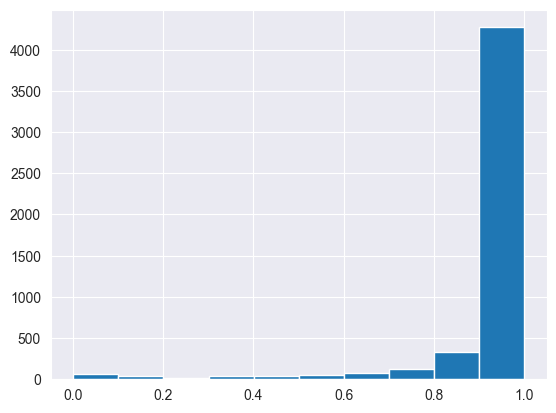

In [659]:
plt.hist(proba_preds)

In [660]:
sorted_probs_desc[n_positives - 1]

0.8275666072428405

In [669]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score

test_recall = recall_score(y_test, binary_preds_90)
precision_test = precision_score(y_test, binary_preds_90)
tn, fp, fn, tp = confusion_matrix(y_test, binary_preds_90).ravel()

approval_rate_90 = (tp + fp) / (tp + tn + fp + fn)
chargeback_rate_90 = fp / (tp + fp) if (tp + fp) else 0
f1_score_test_90 = 2 * (precision_test * test_recall) / (precision_test + test_recall)

print("Test Metrics:")
print(f"  Recall: {test_recall:.4f}")
print(f"  Precision: {precision_test:.4f}")
print(f"  F1: {f1_score_test_90:.4f}")
print(f"  Approval Rate: {approval_rate_90:.4f}")
print(f"  Chargeback Rate: {chargeback_rate_90:.4f}")


Test Metrics:
  Recall: 0.9114
  Precision: 0.9941
  F1: 0.9509
  Approval Rate: 0.9001
  Chargeback Rate: 0.0059


In [670]:
tn/(tn+fp+fn+tp), fp/(tn+fp+fn+tp), fn/(tn+fp+fn+tp), tp/(tn+fp+fn+tp)

(0.012881490289338089,
 0.00535077288941736,
 0.08699960364645264,
 0.8947681331747919)

In [671]:
1-(fp/(tp+fp))

0.9940554821664465

In [677]:
(tp+fp), fp, tp

(4542, 27, 4515)

In [672]:
fn/(tn+fn)

0.871031746031746

In [676]:
(tn+fn), fn, tn

(504, 439, 65)

In [567]:
# desired_approval_rate = 0.90
#
# threshold_90 = np.quantile(proba_preds, 1 - desired_approval_rate)
# # or  np.quantile(proba_preds, 0.10)  # same meaning
#
# binary_preds_90 = (proba_preds >= threshold_90).astype(int)
# actual_approval_rate_90 = binary_preds_90.mean()
# threshold_90

In [568]:
# from sklearn.metrics import confusion_matrix, recall_score, precision_score
#
# test_recall = recall_score(y_test, binary_preds_90)
# precision_test = precision_score(y_test, binary_preds_90)
# tn, fp, fn, tp = confusion_matrix(y_test, binary_preds_90).ravel()
#
# approval_rate_90 = (tp + fp) / (tp + tn + fp + fn)
# chargeback_rate_90 = fp / (tp + fp) if (tp + fp) else 0
# f1_score_test_90 = 2 * (precision_test * test_recall) / (precision_test + test_recall)
#
# print(f"Recall: {test_recall:.4f}")
# print(f"Precision: {precision_test:.4f}")
# print(f"F1: {f1_score_test_90:.4f}")
# print(f"Approval Rate: {approval_rate_90:.4f}")
# print(f"Chargeback Rate: {chargeback_rate_90:.4f}")


In [569]:
# proba_preds = best_model_RS.predict_proba(X_test)[:, 1]
# binary_preds = np.where(proba_preds >= 0.812, 1, 0)
# test_recall = recall_score(y_test, binary_preds)
# conf_matrix = confusion_matrix(y_test, binary_preds)
# tn, fp, fn, tp = conf_matrix.ravel()
# test_approval_rate = (tp+fp)/(tp+tn+fp+fn)
# chargeback_rate_test = fp/(tp+fp)
# precision_test = tp/(tp+fp)
# f1_score_test = 2 * (precision_test * precision_test) / (precision_test + precision_test)
# true_negatives_test = tn/(tn + fp)
# # Display metrics
# print("Test Metrics:")
# print(f"  Negatives correctly classified: {true_negatives_test:.4f}")
# print(f"  Recall: {test_recall:.4f}")
# print(f"  Precision: {precision_test:.4f}")
# print(f"  F1: {f1_score_test:.4f}")
# print(f"  Approval Rate: {test_approval_rate:.4f}")
# print(f"  Chargeback Rate: {chargeback_rate_test:.4f}")

In [570]:
y_test.value_counts()/y_test.value_counts().sum()

label
1    0.981768
0    0.018232
Name: count, dtype: float64

In [571]:
# Count occurrences
num_zeros = np.sum(test_preds == 0)
num_ones = np.sum(test_preds == 1)

print("Number of zeros:", num_zeros/(num_zeros+num_ones))
print("Number of ones:", num_ones/(num_zeros+num_ones))

Number of zeros: 0.03904082441537852
Number of ones: 0.9609591755846215


In [572]:
num_zeros = np.sum(binary_preds_90 == 0)
num_ones = np.sum(binary_preds_90 == 1)

print("Number of zeros:", num_zeros/(num_zeros+num_ones))
print("Number of ones:", num_ones/(num_zeros+num_ones))

Number of zeros: 0.09988109393579073
Number of ones: 0.9001189060642093


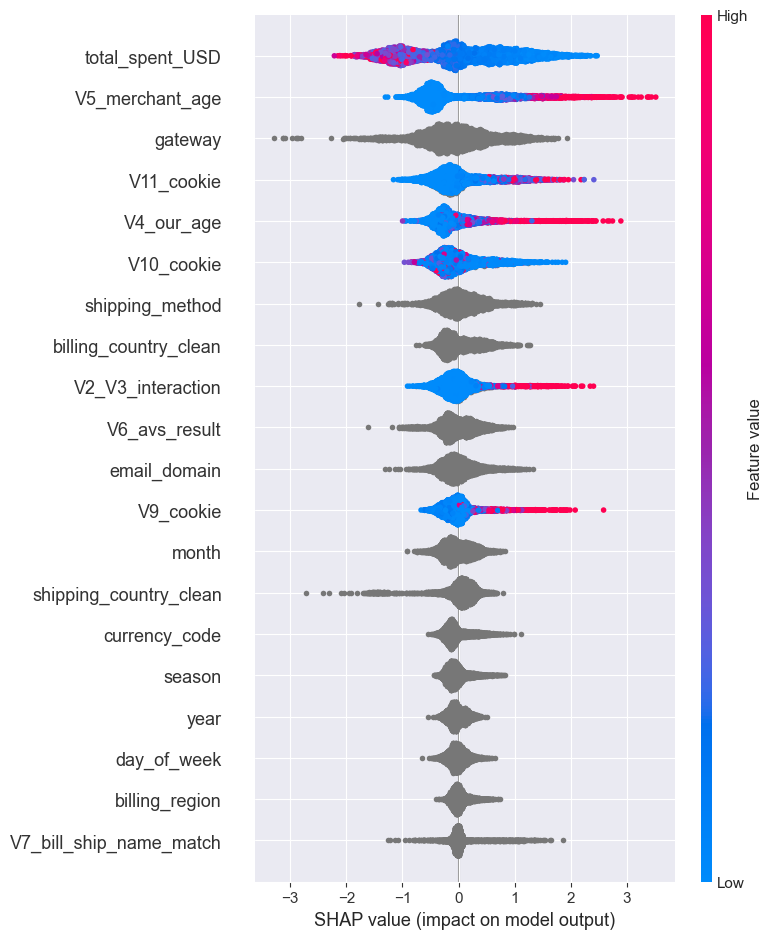

In [531]:
import shap

# Compute SHAP values
explainer = shap.TreeExplainer(best_model_RS)
shap_values = explainer.shap_values(X_test)

# Visualize feature importance
shap.summary_plot(shap_values, X_test)


In [499]:
# # SHAP values for Class 0 predictions (shap_values[0] for binary classification)
# shap_values_class_0 = shap_values[0]
#
# # Create a DataFrame of mean absolute SHAP values for Class 0
# shap_importance_class_0 = pd.DataFrame({
#     'feature': X_test.columns,
#     'mean_abs_shap_value': np.mean(np.abs(shap_values_class_0), axis=0)
# })
#
# # Sort by importance for Class 0
# shap_importance_class_0 = shap_importance_class_0.sort_values(by='mean_abs_shap_value', ascending=False)
#
# # Display the top 10 features for Class 0
# top_10_features_class_0 = shap_importance_class_0.head(10)
# print(top_10_features_class_0)

In [500]:
# from sklearn.inspection import permutation_importance
#
# # Filter the test set for Class 0
# X_test_class_0 = X_test[y_test == 0]
# y_test_class_0 = y_test[y_test == 0]
#
# # Calculate permutation importance
# perm_importance = permutation_importance(best_model_RS, X_test_class_0, y_test_class_0, scoring='precision')
#
# # Create a DataFrame of permutation importances
# perm_importance_df = pd.DataFrame({
#     'feature': X_test.columns,
#     'importance': perm_importance['importances_mean']
# })
#
# # Sort by importance
# perm_importance_df = perm_importance_df.sort_values(by='importance', ascending=False)
#
# # Display the top 10 features for Class 0
# top_10_features_perm = perm_importance_df.head(10)
# print(top_10_features_perm)


for V5_merchant_age, V4_our_age, V2_V3_interaction, V9_cookie we can see that higher value contribute to a higher likelihood of a legitimate transaction. while higher values of total spent contribute to e higher likelihood of a fraudulent transaction.

In [ ]:
# from sklearn.metrics import precision_recall_curve, classification_report
#
# # Predicted probabilities for the positive class (e.g., class 1)
# proba_preds = best_model_RS.predict_proba(X_test)[:, 1]
# # binary_preds = np.where(proba_preds >= 0.8937239305937068, 1, 0)
#
# # Step 1: Evaluate Precision, Recall, and F1-Score
# report = classification_report(np.array(y_test), test_preds, target_names=['Class 0', 'Class 1'])
# print("Classification Report:\n", report)

In [ ]:
# Step 2: Analyze Thresholds
# Calculate precision, recall, and thresholds
# precision, recall, thresholds = precision_recall_curve(np.array(y_test), proba_preds)
# f1 = 2 * (precision * recall)/(precision + recall)
# # Plot Precision-Recall vs Threshold
# plt.figure(figsize=(10, 6))
# plt.plot(thresholds, precision[:-1], label="Precision", marker='.')
# plt.plot(thresholds, recall[:-1], label="Recall", marker='.')
# plt.plot(thresholds, f1[:-1], label="F1", marker='.')
# plt.axvline(0.5, color='red', linestyle='--', label="Default Threshold (0.5)")
# plt.xlabel("Threshold")
# plt.ylabel("Score")
# plt.title("Precision-Recall-F1 vs Threshold")
# plt.legend()
# plt.grid()
# plt.show()

In [ ]:
# from sklearn.metrics import precision_recall_curve
#
# precision, recall, thresholds = precision_recall_curve(y_test, proba_preds, pos_label=0)
# f1 = 2 * (precision * recall)/(precision + recall)
# # Plot Precision-Recall vs Threshold
# plt.figure(figsize=(10, 6))
# plt.plot(thresholds, precision[:-1], label="Precision", marker='.')
# plt.plot(thresholds, recall[:-1], label="Recall", marker='.')
# plt.plot(thresholds, f1[:-1], label="F1", marker='.')
# plt.axvline(0.5, color='red', linestyle='--', label="Default Threshold (0.5)")
# plt.xlabel("Threshold")
# plt.ylabel("Score")
# plt.title("Precision-Recall-F1 vs Threshold")
# plt.legend()
# plt.grid()
# plt.show()

In [ ]:
# # Set a target precision and find the corresponding threshold
# target_precision = 0.7  # Example target precision
# optimal_idx = np.argmax(precision >= target_precision)
# optimal_threshold = thresholds[optimal_idx]
# optimal_threshold

In [ ]:
# from sklearn.calibration import calibration_curve
# import matplotlib.pyplot as plt
#
# fraction_of_positives, mean_predicted_value = calibration_curve(y_test, proba_preds, n_bins=10)
#
# plt.plot(mean_predicted_value, fraction_of_positives, marker='o')
# plt.plot([0, 1], [0, 1], linestyle='--')
# plt.title('Reliability Diagram')
# plt.xlabel('Mean Predicted Value')
# plt.ylabel('Fraction of Positives')
# plt.show()


If probabilities are calibrated and align well with observed outcomes, the default threshold may suffice.

Since your model already accounts for imbalance through class weights, its probability outputs are biased toward compensating for this imbalance. Additional calibration might unnecessarily distort these adjusted probabilities.

Class weights directly modify the loss function, influencing the probabilities to favor the minority class (Class 0).
This adjustment makes the probabilities inherently less reliable for representing true likelihoods but better suited for classification (e.g., precision-recall tradeoffs). Calibration might undo this beneficial bias introduced by class weighting.

--> skip calibration if your model already compensates for class imbalance using class weights or sampling techniques.

In [463]:
# from sklearn.metrics import average_precision_score, precision_recall_curve
#
# # Average precision score: Measures the area under the PR curve
# avg_precision = average_precision_score(np.array(y_test), proba_preds)
# precision, recall, thresholds = precision_recall_curve(np.array(y_test), proba_preds)
# # Plot the Precision-Recall Curve
# plt.figure(figsize=(8, 6))
# plt.plot(recall, precision, label=f"Precision-Recall Curve (AP={avg_precision:.2f})", marker='.')
# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.title("Precision-Recall Curve")
# plt.legend()
# plt.grid()
# plt.show()

- High precision and recall values over a wide range of thresholds indicate strong model performance.
- A steep drop-off indicates the threshold where recall is gained at the cost of precision.

The PR curve specifically evaluates the trade-off between precision (how many predicted positives are correct) and recall (how many actual positives are captured), which are critical for imbalanced datasets.
This is especially important when the minority class (Class 0) is the one you care about.

Class Imbalance:

The ROC curve includes the false positive rate (FPR), which can be misleading in imbalanced datasets because the majority class dominates the false positive count.

Interpreting Model Performance:

A high area under the PR curve (PR AUC) means the model maintains good precision even when recall is high, which is a better measure of performance when the dataset is imbalanced.

Why Not the ROC Curve?
The ROC curve evaluates the true positive rate (TPR) against the false positive rate (FPR):

For imbalanced datasets, the FPR can appear deceptively low because false positives (FP) are a small fraction of the majority class (Class 1).
This inflates the ROC AUC score, making the model seem better than it actually is at distinguishing the minority class (Class 0).

If your goal is to evaluate performance for the minority class (Class 0), focus on the Precision-Recall curve and its metrics (e.g., average precision score or F1-score).

In [464]:
# from sklearn.metrics import roc_curve, roc_auc_score
#
# fpr, tpr, thresholds = roc_curve(np.array(y_test), proba_preds)
# optimal_idx = np.argmax(tpr - fpr)
# optimal_threshold = thresholds[optimal_idx]
# print("Optimal Threshold (ROC):", optimal_threshold)


In [465]:
# # AUC (Area Under Curve)
# roc_auc = roc_auc_score(np.array(y_test), proba_preds)
#
# # Plot the ROC Curve
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label=f"ROC Curve (AUC={roc_auc:.2f})", marker='.')
# plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier")
# plt.xlabel("False Positive Rate (FPR)")
# plt.ylabel("True Positive Rate (TPR)")
# plt.title("ROC Curve")
# plt.legend()
# plt.grid()
# plt.show()

In [466]:
# # Calculate the optimal threshold (minimize distance to top-left corner)
# distance = np.sqrt((1 - tpr)**2 + (fpr)**2)
# optimal_threshold_index = np.argmin(distance)
# optimal_threshold = thresholds[optimal_threshold_index]
#
# print(f"Optimal Threshold (ROC): {optimal_threshold}")


both the precision-recall and the roc-auc curves suggest a threshold around 0.89-0.9 to maximize the TPR and minimize the FPR.

In [ ]:
# proba_preds = best_model_RS.predict_proba(X_test)[:, 1]
# binary_preds = np.where(proba_preds >= 0.9614937589504026, 1, 0)
# test_recall = recall_score(y_test, binary_preds)
# conf_matrix = confusion_matrix(y_test, binary_preds)
# tn, fp, fn, tp = conf_matrix.ravel()
# test_approval_rate = (tp+fp)/(tp+tn+fp+fn)
# chargeback_rate_test = fp/(tp+fp)
# precision_test = tp/(tp+fp)
# true_negatives_test = tn/(tn + fp)
# # Display metrics
# print("Test Metrics:")
# print(f"  Negatives correctly classified: {true_negatives_test:.4f}")
# print(f"  Recall: {test_recall:.4f}")
# print(f"  Precision: {precision_test:.4f}")
# print(f"  Approval Rate: {test_approval_rate:.4f}")
# print(f"  Chargeback Rate: {chargeback_rate_test:.4f}")
#


In [ ]:
# # Count occurrences
# num_zeros = np.sum(test_preds == 0)
# num_ones = np.sum(test_preds == 1)
#
# print("Number of zeros:", num_zeros/(num_zeros+num_ones))
# print("Number of ones:", num_ones/(num_zeros+num_ones))

In [ ]:
# num_zeros = np.sum(binary_preds == 0)
# num_ones = np.sum(binary_preds == 1)
#
# print("Number of zeros predicted threshold:", num_zeros/(num_zeros+num_ones))
# print("Number of ones predicted threshold:", num_ones/(num_zeros+num_ones))

In [ ]:
# y_test.value_counts()/y_test.value_counts().sum()

After fitting and tuning the parameters a first time - i got the following results for the test set, with the entire feature space:

Test Metrics:

Recall: 0.9710

Approval Rate: 0.9531

Chargeback Rate: 0.0086

The i took the 10 most important features and I re-fit to see if I could get a further improvement: 'total_spent_USD', 'gateway', 'V10_cookie', 'V2_V3_interaction', 'V5_merchant_age', 'V4_our_age', 'shipping_method', 'V11_cookie', 'email_domain', 'V6_avs_result'.

In [ ]:
# best_model_RS_top10.fit(X_train, y_train, eval_set=(X_dev, y_dev), early_stopping_rounds=50)
# test_preds = best_model_RS_top10.predict(X_test)
# test_recall = recall_score(y_test, test_preds)
# conf_matrix = confusion_matrix(y_test, test_preds)
# tn, fp, fn, tp = conf_matrix.ravel()
# test_approval_rate = (tp+fp)/(tp+tn+fp+fn)
# chargeback_rate_test = fp/(tp+fp)
# # Display metrics
# print("Test Metrics:")
# print(f"  Recall: {test_recall:.4f}")
# print(f"  Approval Rate: {test_approval_rate:.4f}")
# print(f"  Chargeback Rate: {chargeback_rate_test:.4f}")

The performance with the top10 features is slightly worse.

In [707]:
declined_test = df_declined[['shipping_method',
       'currency_code', 'gateway', 'V1_link',
       'V4_our_age', 'V5_merchant_age', 'V6_avs_result',
       'V7_bill_ship_name_match', 'V8_ip', 'V9_cookie', 'V10_cookie',
       'V11_cookie', 'email_domain', 'year', 'month',
       'season', 'day_of_week', 'is_weekend', 'billing_country_clean',
       'shipping_country_clean', 'total_spent_USD', 'billing_region', 'shipping_region', 'V2_V3_interaction']]

categorical_columns = [
    'shipping_method', 'currency_code', 'gateway', 'V1_link', 'V6_avs_result',
    'V7_bill_ship_name_match', 'email_domain', 'year','month','season','day_of_week','is_weekend',
    'billing_country_clean', 'shipping_country_clean', 'billing_region', 'shipping_region'
]

# Convert categorical columns and NaN values to strings
for col in categorical_columns:
    declined_test[col] = declined_test[col].astype(str)

/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_51231/2608876481.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  declined_test[col] = declined_test[col].astype(str)
/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_51231/2608876481.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  declined_test[col] = declined_test[col].astype(str)
/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_51231/2608876481.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [708]:
decline_preds = best_model_RS.predict(declined_test)

In [709]:
df_declined['predictions'] = (decline_preds >= threshold_90).astype(int)

In [710]:
df_declined.columns

Index(['order_id', 'status', 'email_anoni', 'billing_country_code',
       'shipping_country_code', 'shipping_method', 'created_at', 'total_spent',
       'currency_code', 'gateway', 'V1_link', 'V4_our_age', 'V5_merchant_age',
       'V6_avs_result', 'V7_bill_ship_name_match', 'V8_ip', 'V9_cookie',
       'V10_cookie', 'V11_cookie', 'email_domain', 'year', 'month', 'season',
       'day_of_week', 'is_weekend', 'billing_country_clean',
       'shipping_country_clean', 'total_spent_USD', 'billing_region',
       'shipping_region', 'V2_V3_interaction', 'is_approved_or_cb',
       'is_chargeback', 'predictions'],
      dtype='object')

In [646]:
# top5_predicted = df_declined[df_declined.predictions == 1].groupby(['shipping_method', 'currency_code','gateway','V1_link','V7_bill_ship_name_match', 'is_weekend','billing_region','shipping_region'], as_index=False).agg(total_declined=('order_id', 'nunique'), total_declined_spent=('total_spent_USD', 'sum')).sort_values(by=['total_declined'], ascending=False).head(5)

In [711]:
approved_declined = df_declined[df_declined.predictions == 1].groupby(['shipping_method', 'currency_code',  'gateway','V1_link',
           'V6_avs_result', 'V7_bill_ship_name_match', 'email_domain', 'billing_region','shipping_region'], as_index=False).agg(total_declined=('order_id', 'nunique'), total_declined_spent=('total_spent_USD', 'sum')).sort_values(by=['total_declined'], ascending=False)

In [712]:
approved_declined_pred = pd.merge(declined_in_good_segments, approved_declined, how='inner', on=['shipping_method', 'currency_code',  'gateway','V1_link',
           'V6_avs_result', 'V7_bill_ship_name_match', 'email_domain', 'billing_region','shipping_region'])
approved_declined_pred

,shipping_method,currency_code,gateway,V1_link,V6_avs_result,V7_bill_ship_name_match,email_domain,billing_region,shipping_region,total_orders,total_transaction_value,approval_rate,chargeback_rate,total_declined,total_declined_spent
0,value_1059,USD,value_136,False,No Match,FL,gmail,North America,North America,130,36599.01,0.022556,0.000000,54,7832.98
1,value_1059,USD,value_136,False,No Match,FL,yahoo,North America,North America,113,32064.06,0.058333,0.000000,99,26790.16
2,value_1059,USD,value_245,False,Full Match,FL,gmail,North America,North America,236,55287.90,0.687417,0.000000,235,55054.42
3,value_1059,USD,value_245,False,Full Match,FL,personal_domain,North America,North America,97,26465.17,0.660839,0.010582,97,26465.17
4,value_1059,USD,value_245,False,No Match,FL,gmail,North America,North America,312,56473.24,0.126050,0.000000,277,44571.36
5,value_1059,USD,value_245,False,No Match,FL,hotmail,North America,North America,127,22178.77,0.164474,0.000000,127,22178.77
6,value_1059,USD,value_245,False,No Match,FL,personal_domain,North America,North America,119,38191.30,0.137681,0.000000,118,37407.40
7,value_1059,USD,value_245,False,Unsupported,FL,163,North America,North America,214,116292.17,0.298361,0.000000,214,116292.17
8,value_1059,USD,value_245,False,Unsupported,FL,personal_domain,North America,North America,258,49095.63,0.538462,0.003322,250,47050.19
9,value_1059,USD,value_245,False,Unsupported,FL,qq,North America,North America,198,82258.64,0.211155,0.000000,197,82106.68


In [713]:
top5_predicted = df_declined[df_declined.predictions == 1].groupby(['shipping_method', 'currency_code',  'gateway','V1_link',
           'V6_avs_result', 'V7_bill_ship_name_match', 'email_domain', 'billing_region','shipping_region'], as_index=False).agg(total_declined=('order_id', 'nunique'), total_declined_spent=('total_spent_USD', 'sum')).sort_values(by=['total_declined'], ascending=False).head(5)

In [714]:
top5_predicted

,shipping_method,currency_code,gateway,V1_link,V6_avs_result,V7_bill_ship_name_match,email_domain,billing_region,shipping_region,total_declined,total_declined_spent
249,value_1059,USD,value_245,False,Unsupported,FL,gmail,North America,North America,488,107344.59
206,value_1059,USD,value_245,False,No Match,FL,gmail,North America,North America,277,44571.36
264,value_1059,USD,value_245,False,Unsupported,FL,personal_domain,North America,North America,250,47050.19
160,value_1059,USD,value_245,False,Full Match,FL,gmail,North America,North America,235,55054.42
244,value_1059,USD,value_245,False,Unsupported,FL,163,North America,North America,214,116292.17


The model reached +95% in both recall and approval rate. in addition - the model successfully spots the FN in the declined orders by predicting 1 for those segments that demonstrated a suboptimal performance when we compared between declined and approved transactions in section 1.

# 3. Based on the performance of the model you trained, what should be the fee that we should quote the merchant if we want the total cost of chargebacks to be 50% of our total revenue?

Solving for fee, the fee should be twice the total_spend_(FP)/total_spend_(TP+FP), and TP+FP are the total approved orders.

In [580]:
def calculate_fee(chargeback_cost, total_approved_volume):
    """
    Calculate the fee to ensure chargeback cost is 50% of total revenue.

    Parameters:
        chargeback_cost (float): Total spent on chargebacks.
        total_approved_volume (float): Total spent on approved orders.

    Returns:
        float: Fee to charge as a percentage of the approved volume.
    """
    if total_approved_volume == 0:
        return 0  # Avoid division by zero
    fee = 2 * (chargeback_cost / total_approved_volume)
    return fee

test_data['predictions'] = test_preds
test_data['predictions_90'] = binary_preds_90

In [581]:
chargeback_cost = test_data[(test_data.label==0) & (test_data.predictions == 1)]['total_spent_USD'].sum()
total_approved_volume = test_data[(test_data.predictions == 1)]['total_spent_USD'].sum()
calculate_fee(chargeback_cost=chargeback_cost, total_approved_volume=total_approved_volume)

0.022208594391461504

In [582]:
chargeback_cost = test_data[(test_data.label==0) & (test_data.predictions_90 == 1)]['total_spent_USD'].sum()
total_approved_volume = test_data[(test_data.predictions_90 == 1)]['total_spent_USD'].sum()
calculate_fee(chargeback_cost=chargeback_cost, total_approved_volume=total_approved_volume)

0.013456502427228331

In [583]:
chargeback_cost

6719.4338797622195

In [584]:
total_approved_volume

998689.5058504795